# Libraries

In [1]:
#dataframe
import pandas as pd

# time filter
import datetime

# basic math and stats formulas and plots
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
     
#nan visualization
import missingno as mno

#train - test
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# model metrics validation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

#neural network
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

# Import dataset

In [2]:
df = pd.read_csv('Dataset/DatiSynop_16429.csv', sep = ';')
df.head()

date  idstazione   lon    lat  altezza  pressure  \
0  1996-01-01 00:00       16429  12.5  37.92        9  100270.0   
1  1996-01-01 03:00       16429  12.5  37.92        9  100280.0   
2  1996-01-01 06:00       16429  12.5  37.92        9  100310.0   
3  1996-01-01 09:00       16429  12.5  37.92        9  100490.0   
4  1996-01-01 12:00       16429  12.5  37.92        9  100520.0   

   three_hour_pressure_change  char_pressure_tendency  wind_direction  \
0                        70.0                     1.0           270.0   
1                        10.0                     3.0           270.0   
2                        30.0                     3.0           270.0   
3                       180.0                     1.0           270.0   
4                        30.0                     0.0           280.0   

   wind_speed  relative_humidity  visibility  present_weather  past_weather1  \
0     15.5504                NaN     10000.0              2.0            1.0   
1     17.4942                NaN     10000.0              2.0            1.0   
2     13.6066                NaN     14000.0              2.0            1.0   
3      9.7190                NaN     18000.0              2.0            1.0   
4     13.6066                NaN     18000.0              2.0            1.0   

   past_weather2  cloud_cover  height_of_base_of_cloud  cloud_type  drybulb  \
0            1.0          5.0                    450.0          35      NaN   
1            1.0          4.0                    250.0          35      NaN   
2            1.0          2.0                    450.0          35      NaN   
3            1.0          3.0                    800.0          35      NaN   
4            1.0          6.0                    800.0          35      NaN   

   dewpoint  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [3]:
df = df.drop(['relative_humidity', 'lon', 'lat', 'altezza', 'idstazione','three_hour_pressure_change','char_pressure_tendency','height_of_base_of_cloud',], axis = 1)
df['date']= pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
print(f"Dataset shape: {df.shape}\n{df.isna().sum()}")

Dataset shape: (162245, 12)
date                   0
pressure             157
wind_direction        62
wind_speed            63
visibility            23
present_weather      115
past_weather1        124
past_weather2        119
cloud_cover           56
cloud_type             0
drybulb            96861
dewpoint           96862
dtype: int64


# Date Features

In [4]:
def get_year(dt):
    '''Takes a time timestamp as input and returns the year'''
    return dt.year

def get_month(dt):
    '''Takes a time timestamp as input and returns the month'''
    return dt.month

def get_day(dt):
    '''Takes a time timestamp as input and returns the day'''
    return dt.day

def get_hour(dt):
    '''Takes a time timestamp as input and returns the hour'''
    return dt.hour

def get_julian(dt):
    return dt.to_julian_date()

def hourfromtd(td):
    sec = td.total_seconds()
    hours = sec/3600
    return hours


# Adding the new variables to the dataframe

df['Year'] = df['date'].apply(get_year)
df['Month'] = df['date'].apply(get_month)
df['Day'] = df['date'].apply(get_day)
df['Hour'] = df['date'].apply(get_hour)

df['Julian'] = df['date'].apply(get_julian)

df['date_diff'] = df['date'].diff()
df['date_diff'] = df['date_diff'].apply(hourfromtd)
df['date_diff'] = df['date_diff'].fillna(0.0)
df['date_diff'] = df['date_diff'].astype(int)

In [5]:
df.describe().applymap('{:,.2f}'.format)

pressure wind_direction  wind_speed  visibility present_weather  \
count  162,088.00     162,183.00  162,182.00  162,222.00      162,130.00   
mean   101,482.35         190.23        8.00   15,574.26            6.09   
std        595.16         113.82        6.03    4,592.27           14.66   
min     90,660.00           0.00        0.00       30.00            0.00   
25%    101,170.00         110.00        3.89   12,000.00            2.00   
50%    101,490.00         170.00        7.78   15,000.00            2.00   
75%    101,810.00         300.00       11.66   20,000.00            2.00   
max    107,100.00         500.00      320.73   75,000.00           99.00   

      past_weather1 past_weather2 cloud_cover  cloud_type    drybulb  \
count    162,121.00    162,126.00  162,189.00  162,245.00  65,384.00   
mean           1.57          1.22        3.50       39.11      18.21   
std            1.72          0.94        2.58       11.62       6.27   
min            0.00          0.00        0.00       17.00       1.25   
25%            1.00          1.00        1.00       32.00      13.45   
50%            1.00          1.00        3.00       35.00      17.45   
75%            1.00          1.00        6.00       38.00      23.05   
max           20.00         19.00        8.00       62.00      60.05   

        dewpoint        Year       Month         Day        Hour  \
count  65,383.00  162,245.00  162,245.00  162,245.00  162,245.00   
mean       14.10    2,010.98        6.46       15.69       11.37   
std         5.66        6.35        3.43        8.76        6.92   
min       -29.95    1,996.00        1.00        1.00        0.00   
25%        10.05    2,007.00        4.00        8.00        6.00   
50%        13.55    2,011.00        6.00       16.00       12.00   
75%        18.45    2,016.00        9.00       23.00       18.00   
max        48.95    2,022.00       12.00       31.00       23.00   

             Julian   date_diff  
count    162,245.00  162,245.00  
mean   2,455,735.28        1.41  
std        2,322.28        8.65  
min    2,450,083.50        0.00  
25%    2,454,142.38        1.00  
50%    2,455,876.38        1.00  
75%    2,457,591.08        1.00  
max    2,459,591.46    2,931.00

# Time series visualization

In [6]:
# first_date = df['date'].min()
# last_date = df['date'].max()
# begins_1h =  pd.to_datetime("2005-03-15 18:00:00", format='%Y-%m-%d %H:%M:%S')

# time_series_3h = pd.Series(pd.date_range(start = first_date, end = begins_1h, freq='3H'), name = 'real1')
# time_series_1h = pd.Series(pd.date_range(start = begins_1h, end = last_date, freq='1H'), name = 'real2')

# df1 = df.copy()
# df1['plot'] = 10

# complete_range = time_series_3h.append(time_series_1h)
# merged_df = df1.set_index('date').reindex(complete_range)


In [7]:
# # plt.figure(figsize=(20, 10))

# tmp1 =  merged_df[(merged_df.index >= first_date) & (merged_df.index <= pd.to_datetime("2000-06-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))].copy()
# tmp2 =  merged_df[(merged_df.index >= pd.to_datetime("2000-06-01 00:00:00", format='%Y-%m-%d %H:%M:%S')) & (merged_df.index <= begins_1h)].copy()
# tmp3 =  merged_df[(merged_df.index >= begins_1h) & (merged_df.index <= pd.to_datetime("2009-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))].copy()
# tmp4 =  merged_df[(merged_df.index >= pd.to_datetime("2009-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')) & (merged_df.index <= pd.to_datetime("2013-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))].copy()
# tmp5 =  merged_df[(merged_df.index >= pd.to_datetime("2013-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')) & (merged_df.index <= pd.to_datetime("2017-06-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))].copy()
# tmp6 =  merged_df[(merged_df.index >= pd.to_datetime("2017-06-01 00:00:00", format='%Y-%m-%d %H:%M:%S')) & (merged_df.index <= last_date)].copy()

# fig, axes = plt.subplots(3, 2, figsize = (30, 25))
# axes[0,0].bar(tmp1.index, tmp1['plot'])
# axes[0,0].set_xlabel('Timestamp')
# axes[0,0].set_ylabel('Value')
# axes[0,0].tick_params(labelrotation=45)
# # plt.xticks(rotation=45)
# axes[0,1].bar(tmp2.index, tmp2['plot'])
# axes[0,1].set_xlabel('Timestamp')
# axes[0,1].set_ylabel('Value')
# axes[0,1].tick_params(labelrotation=45)

# axes[1,0].bar(tmp3.index, tmp3['plot'])
# axes[1,0].set_xlabel('Timestamp')
# axes[1,0].set_ylabel('Value')
# axes[1,0].tick_params(labelrotation=45)

# axes[1,1].bar(tmp4.index, tmp4['plot'])
# axes[1,1].set_xlabel('Timestamp')
# axes[1,1].set_ylabel('Value')
# axes[1,1].tick_params(labelrotation=45)

# axes[2,0].bar(tmp5.index, tmp5['plot'])
# axes[2,0].set_xlabel('Timestamp')
# axes[2,0].set_ylabel('Value')
# axes[2,0].tick_params(labelrotation=45)

# axes[2,1].bar(tmp6.index, tmp6['plot'])
# axes[2,1].set_xlabel('Timestamp')
# axes[2,1].set_ylabel('Value')
# axes[2,1].tick_params(labelrotation=45)


# plt.show()

# Date selection

In [8]:
df = df[df['date'] >= pd.to_datetime("2005-03-15 18:00:00", format='%Y-%m-%d %H:%M:%S')]
df = df[df['date'] < pd.to_datetime("2019-01-01 00:00:00", format='%Y-%m-%d %H:%M:%S')]

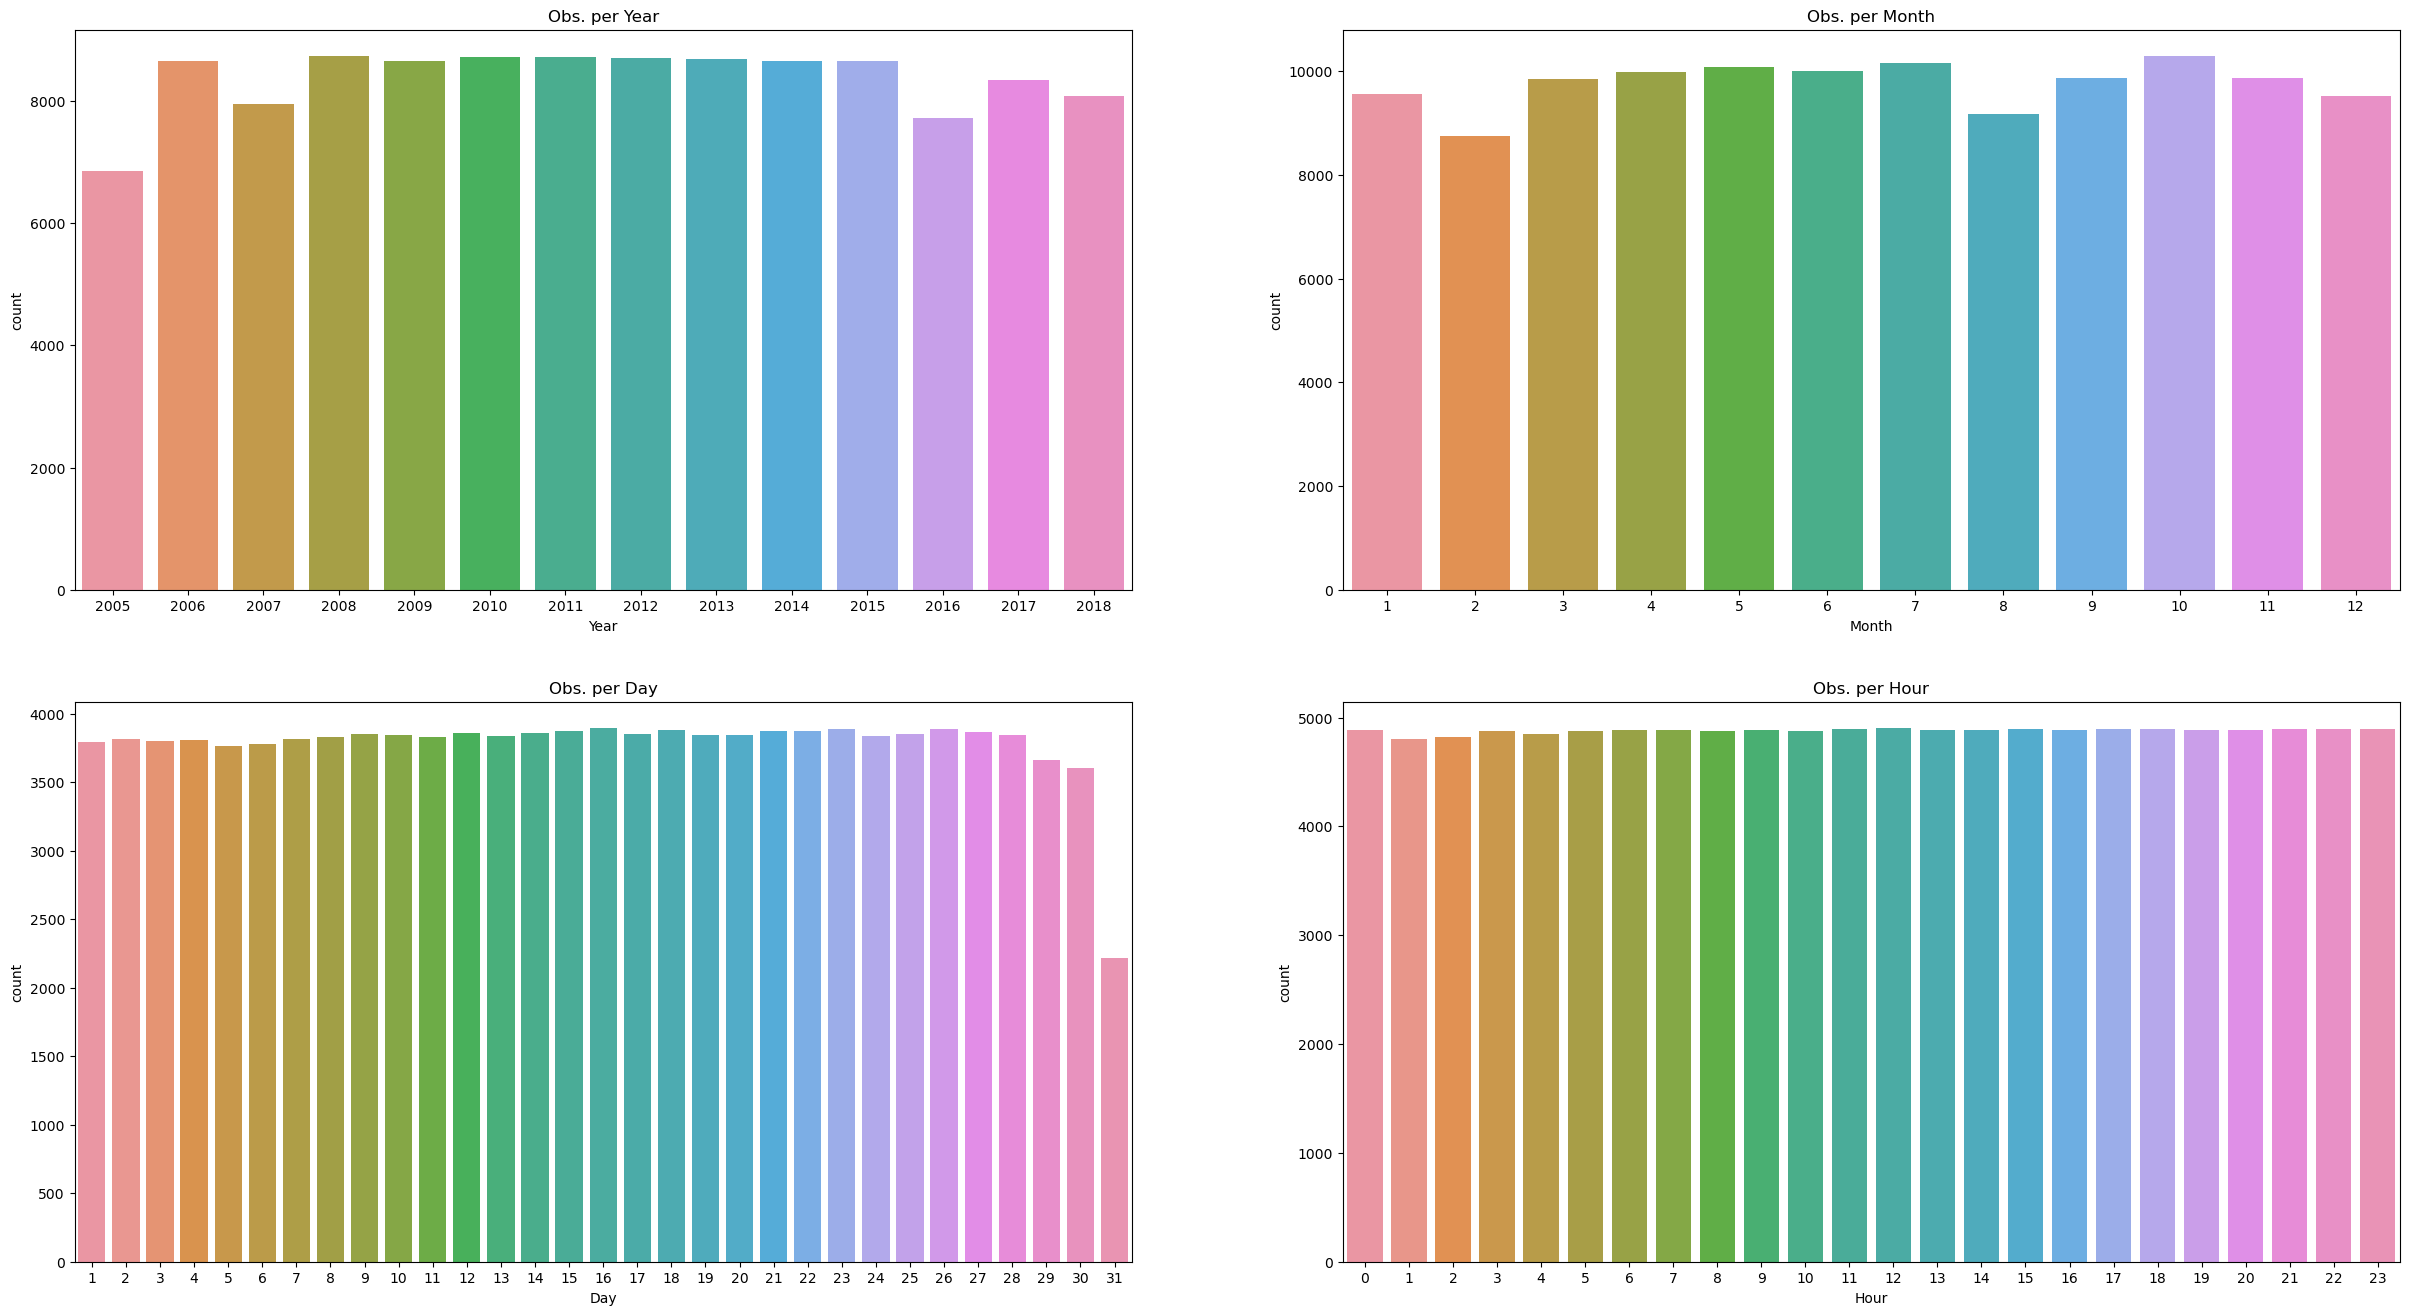

In [9]:
fig, axes = plt.subplots(2,2,figsize = (30,16))
sns.countplot(data = df, x = 'Year', ax = axes[0,0])
axes[0,0].set_title('Obs. per Year')
sns.countplot(data = df, x = 'Month', ax = axes[0,1])
axes[0,1].set_title('Obs. per Month')
sns.countplot(data = df, x = 'Day', ax = axes[1,0])
axes[1,0].set_title('Obs. per Day')
sns.countplot(data = df, x = 'Hour', ax = axes[1,1])
axes[1,1].set_title('Obs. per Hour')
plt.show()

date  pressure  wind_direction  wind_speed  visibility  present_weather  \
NaN     0        24              12          13          10               15   

     past_weather1  past_weather2  cloud_cover  cloud_type  drybulb  dewpoint  \
NaN             23             17           12           0    72782     72783   

     Year  Month  Day  Hour  Julian  date_diff  
NaN     0      0    0     0       0          0

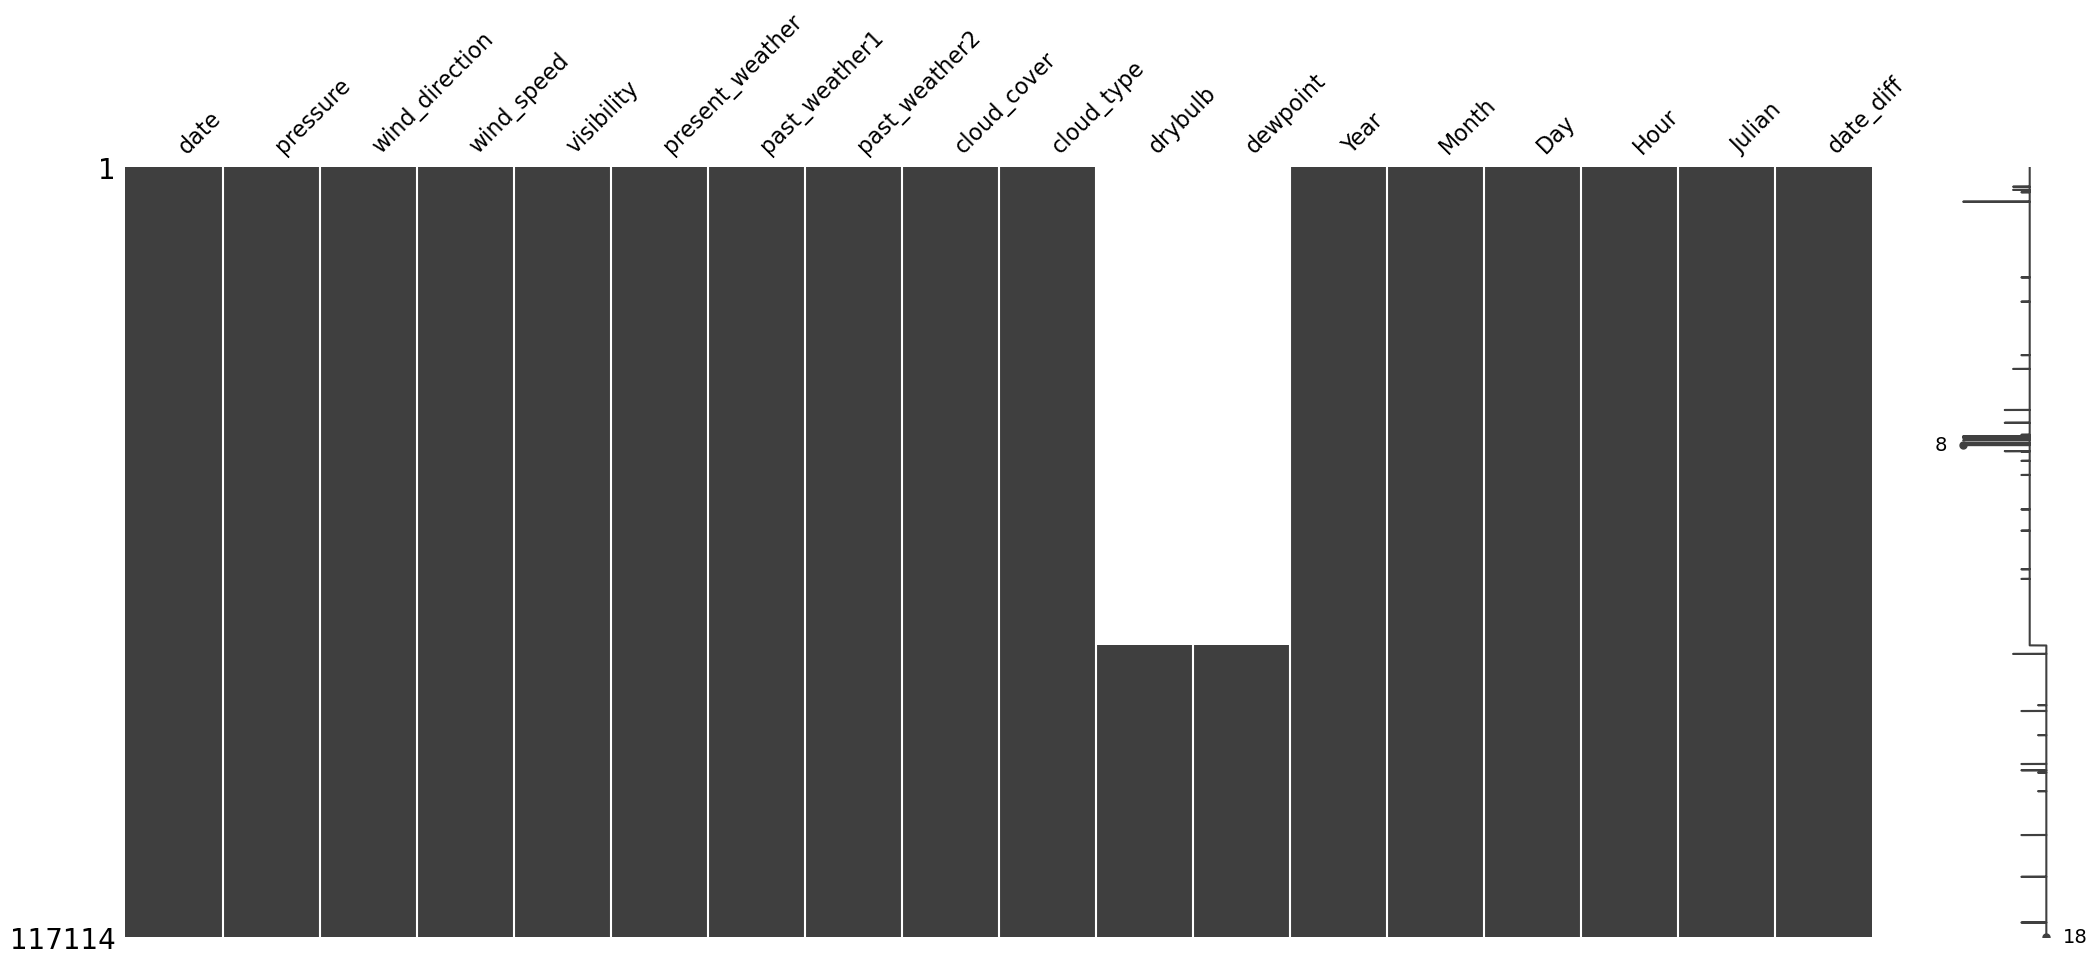

In [10]:
mno.matrix(df)
pd.DataFrame(df.isna().sum(), columns = ['NaN']).T

In [11]:
df.isna().sum()

date                   0
pressure              24
wind_direction        12
wind_speed            13
visibility            10
present_weather       15
past_weather1         23
past_weather2         17
cloud_cover           12
cloud_type             0
drybulb            72782
dewpoint           72783
Year                   0
Month                  0
Day                    0
Hour                   0
Julian                 0
date_diff              0
dtype: int64

# EDA

## Visibility

In [12]:
print(f"{df['visibility'].isna().sum()} Nan out of {df.shape[0]} data")

10 Nan out of 117114 data


In [13]:
var = 'visibility'
nan_ind = list(df[var][df[var].isna()].index)

prob = False
for ind in nan_ind:
    if (ind - 1) in nan_ind or (ind + 1) in nan_ind:
        print(f'There is a consecutive Nan for this variable at index {ind}!')
        prob = True
if prob is False:
    print("There aren't consecutive Nan for this variable!")

There aren't consecutive Nan for this variable!


In [14]:
tmp = []

for i in nan_ind:
    tmp.append(i)
    tmp.append(i+1)

b = df[[var, 'date_diff']][df.index.isin(tmp)]
if b[b['date_diff'] > 3].shape[0] > 0:
    
    display(b[b['date_diff'] > 3])
    
for ind in nan_ind:
    df[var][ind] = (df[var][ind-1] + df[var][ind+1])/2

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\122593258.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][ind] = (df[var][ind-1] + df[var][ind+1])/2


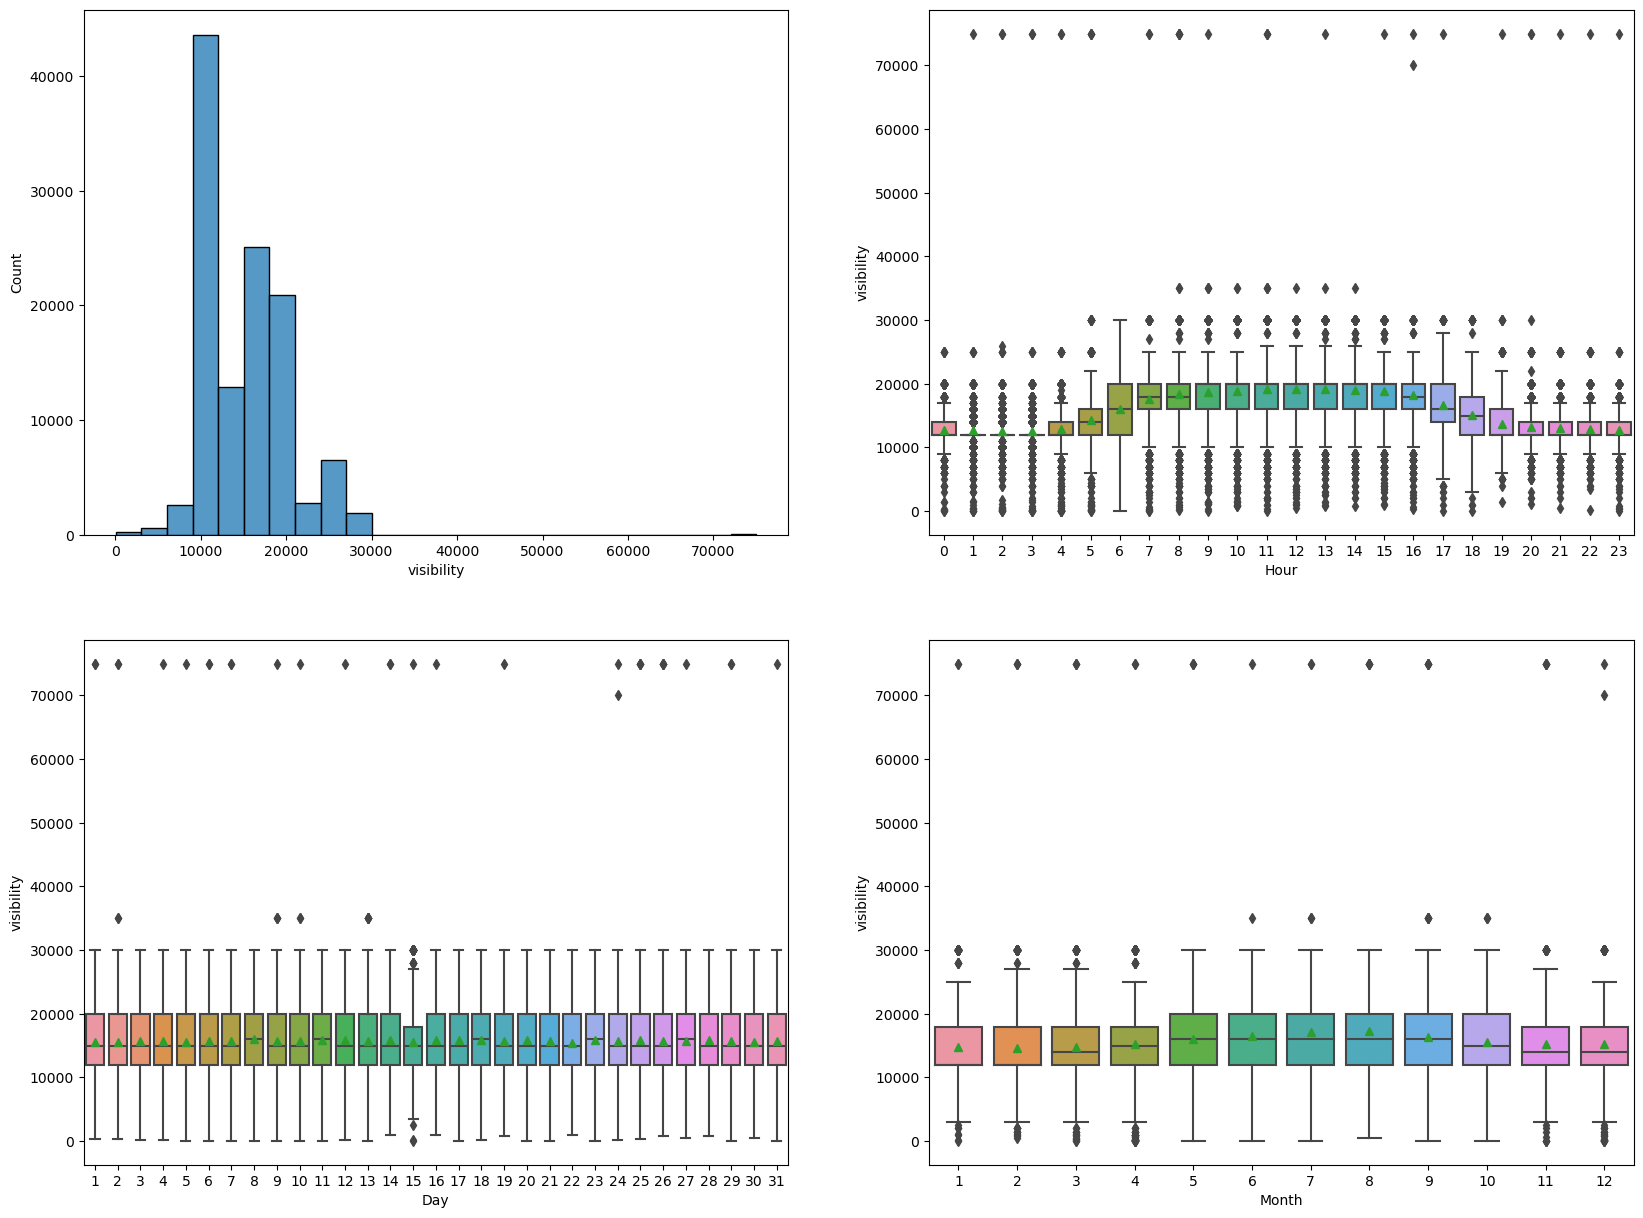

In [15]:

fig, ax = plt.subplots(2,2, figsize = (20,15))
sns.histplot(x= var, data=df, ax = ax[0, 0], bins = 25)
sns.boxplot(data = df, x = 'Hour', y = var, ax = ax[0, 1], showmeans=True)
sns.boxplot(data = df, x = 'Day', y = var, ax = ax[1, 0], showmeans=True)
sns.boxplot(data = df, x = 'Month', y = var, ax = ax[1, 1], showmeans=True)
plt.show()

c:\Users\gltut\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='visibility'>

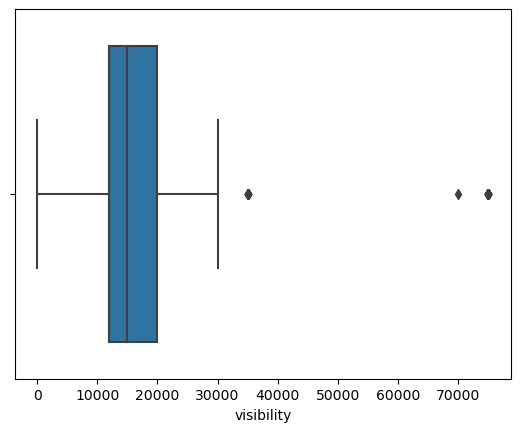

In [16]:
sns.boxplot(df[var])

In [17]:


q1=df[var].quantile(0.25)
q3=df[var].quantile(0.75)

IQR=q3-q1

outliers = df[((df[var]<(q1-1.5*IQR)) | (df[var]>(q3+1.5*IQR)))]

print(outliers.shape)
outliers



(46, 18)


date  pressure  wind_direction  wind_speed  visibility  \
26140  2005-06-10 08:00:00  101430.0           330.0      7.7752     35000.0   
26706  2005-07-04 16:00:00  101160.0           330.0      9.7190     75000.0   
27338  2005-07-31 05:00:00  101090.0           360.0      3.8876     75000.0   
27398  2005-08-02 19:00:00  101300.0           320.0      3.8876     75000.0   
28387  2005-09-13 09:00:00  101610.0            70.0      7.7752     35000.0   
28388  2005-09-13 10:00:00  101610.0            80.0      3.8876     35000.0   
28389  2005-09-13 11:00:00  101600.0           330.0      7.7752     35000.0   
28390  2005-09-13 12:00:00  101590.0           340.0      9.7190     35000.0   
28391  2005-09-13 13:00:00  101590.0           330.0      9.7190     35000.0   
28392  2005-09-13 14:00:00  101610.0           350.0      9.7190     35000.0   
28832  2005-10-02 08:00:00  101630.0           210.0      5.8314     35000.0   
28833  2005-10-02 09:00:00  101660.0           220.0      9.7190     35000.0   
33863  2006-05-05 20:00:00  101720.0           210.0      5.8314     75000.0   
39409  2006-12-24 16:00:00  101700.0           110.0      3.8876     70000.0   
63680  2009-11-10 08:00:00  100300.0           280.0     19.4380     75000.0   
63896  2009-11-19 08:00:00  102540.0           110.0      3.8876     75000.0   
70913  2010-09-09 08:00:00  101410.0           160.0      5.8314     75000.0   
80028  2011-09-26 03:00:00  101660.0           140.0      1.9438     75000.0   
80372  2011-10-10 11:00:00  101790.0           340.0     11.6628     35000.0   
91375  2013-01-14 20:00:00  101360.0             0.0      0.0000     75000.0   
96685  2013-08-25 02:00:00  101220.0           150.0      5.8314     75000.0   
101777 2014-03-27 11:00:00  100070.0           240.0     23.3256     75000.0   
105456 2014-08-29 04:00:00  101270.0           360.0      7.7752     75000.0   
109456 2015-02-14 08:00:00  101770.0           130.0      5.8314     75000.0   
111599 2015-05-15 01:00:00  101160.0           130.0     11.6628     75000.0   
114046 2015-08-26 07:00:00  101500.0           230.0      1.9438     75000.0   
117174 2016-01-06 05:00:00  100430.0           220.0      5.8314     75000.0   
119059 2016-03-25 02:00:00  101100.0            20.0      5.8314     75000.0   
121905 2016-08-25 21:00:00  101410.0            10.0      1.9438     75000.0   
127678 2017-05-12 08:00:00  100780.0           320.0      7.7752     75000.0   
128758 2017-06-26 09:00:00  101270.0           260.0      3.8876     75000.0   
129066 2017-07-09 09:00:00  101480.0           250.0      5.8314     35000.0   
129067 2017-07-09 10:00:00  101500.0           260.0      7.7752     35000.0   
129068 2017-07-09 11:00:00  101500.0           260.0      9.7190     35000.0   
130364 2017-09-06 11:00:00  101940.0           310.0      9.7190     75000.0   
132044 2017-11-16 11:00:00  101140.0           350.0      7.7752     75000.0   
132286 2017-11-26 13:00:00  101660.0           290.0     19.4380     75000.0   
134426 2018-02-24 17:00:00  100700.0           180.0      5.8314     75000.0   
134456 2018-02-25 23:00:00  100260.0           130.0      5.8314     75000.0   
134556 2018-03-02 03:00:00   99990.0           140.0      5.8314     75000.0   
135867 2018-04-26 22:00:00  100980.0           110.0      3.8876     75000.0   
135924 2018-04-29 07:00:00  100810.0           320.0      3.8876     75000.0   
138320 2018-09-01 04:00:00  101510.0           120.0      5.8314     75000.0   
138465 2018-09-07 05:00:00  101200.0           300.0      5.8314     75000.0   
139735 2018-11-01 05:00:00  101690.0           110.0     11.6628     75000.0   
140605 2018-12-07 15:00:00  102050.0           340.0      5.8314     75000.0   

        present_weather  past_weather1  past_weather2  cloud_cover  \
26140               2.0            1.0            1.0          3.0   
26706               2.0            1.0            1.0          0.0   
27338              10.0            1.0            1

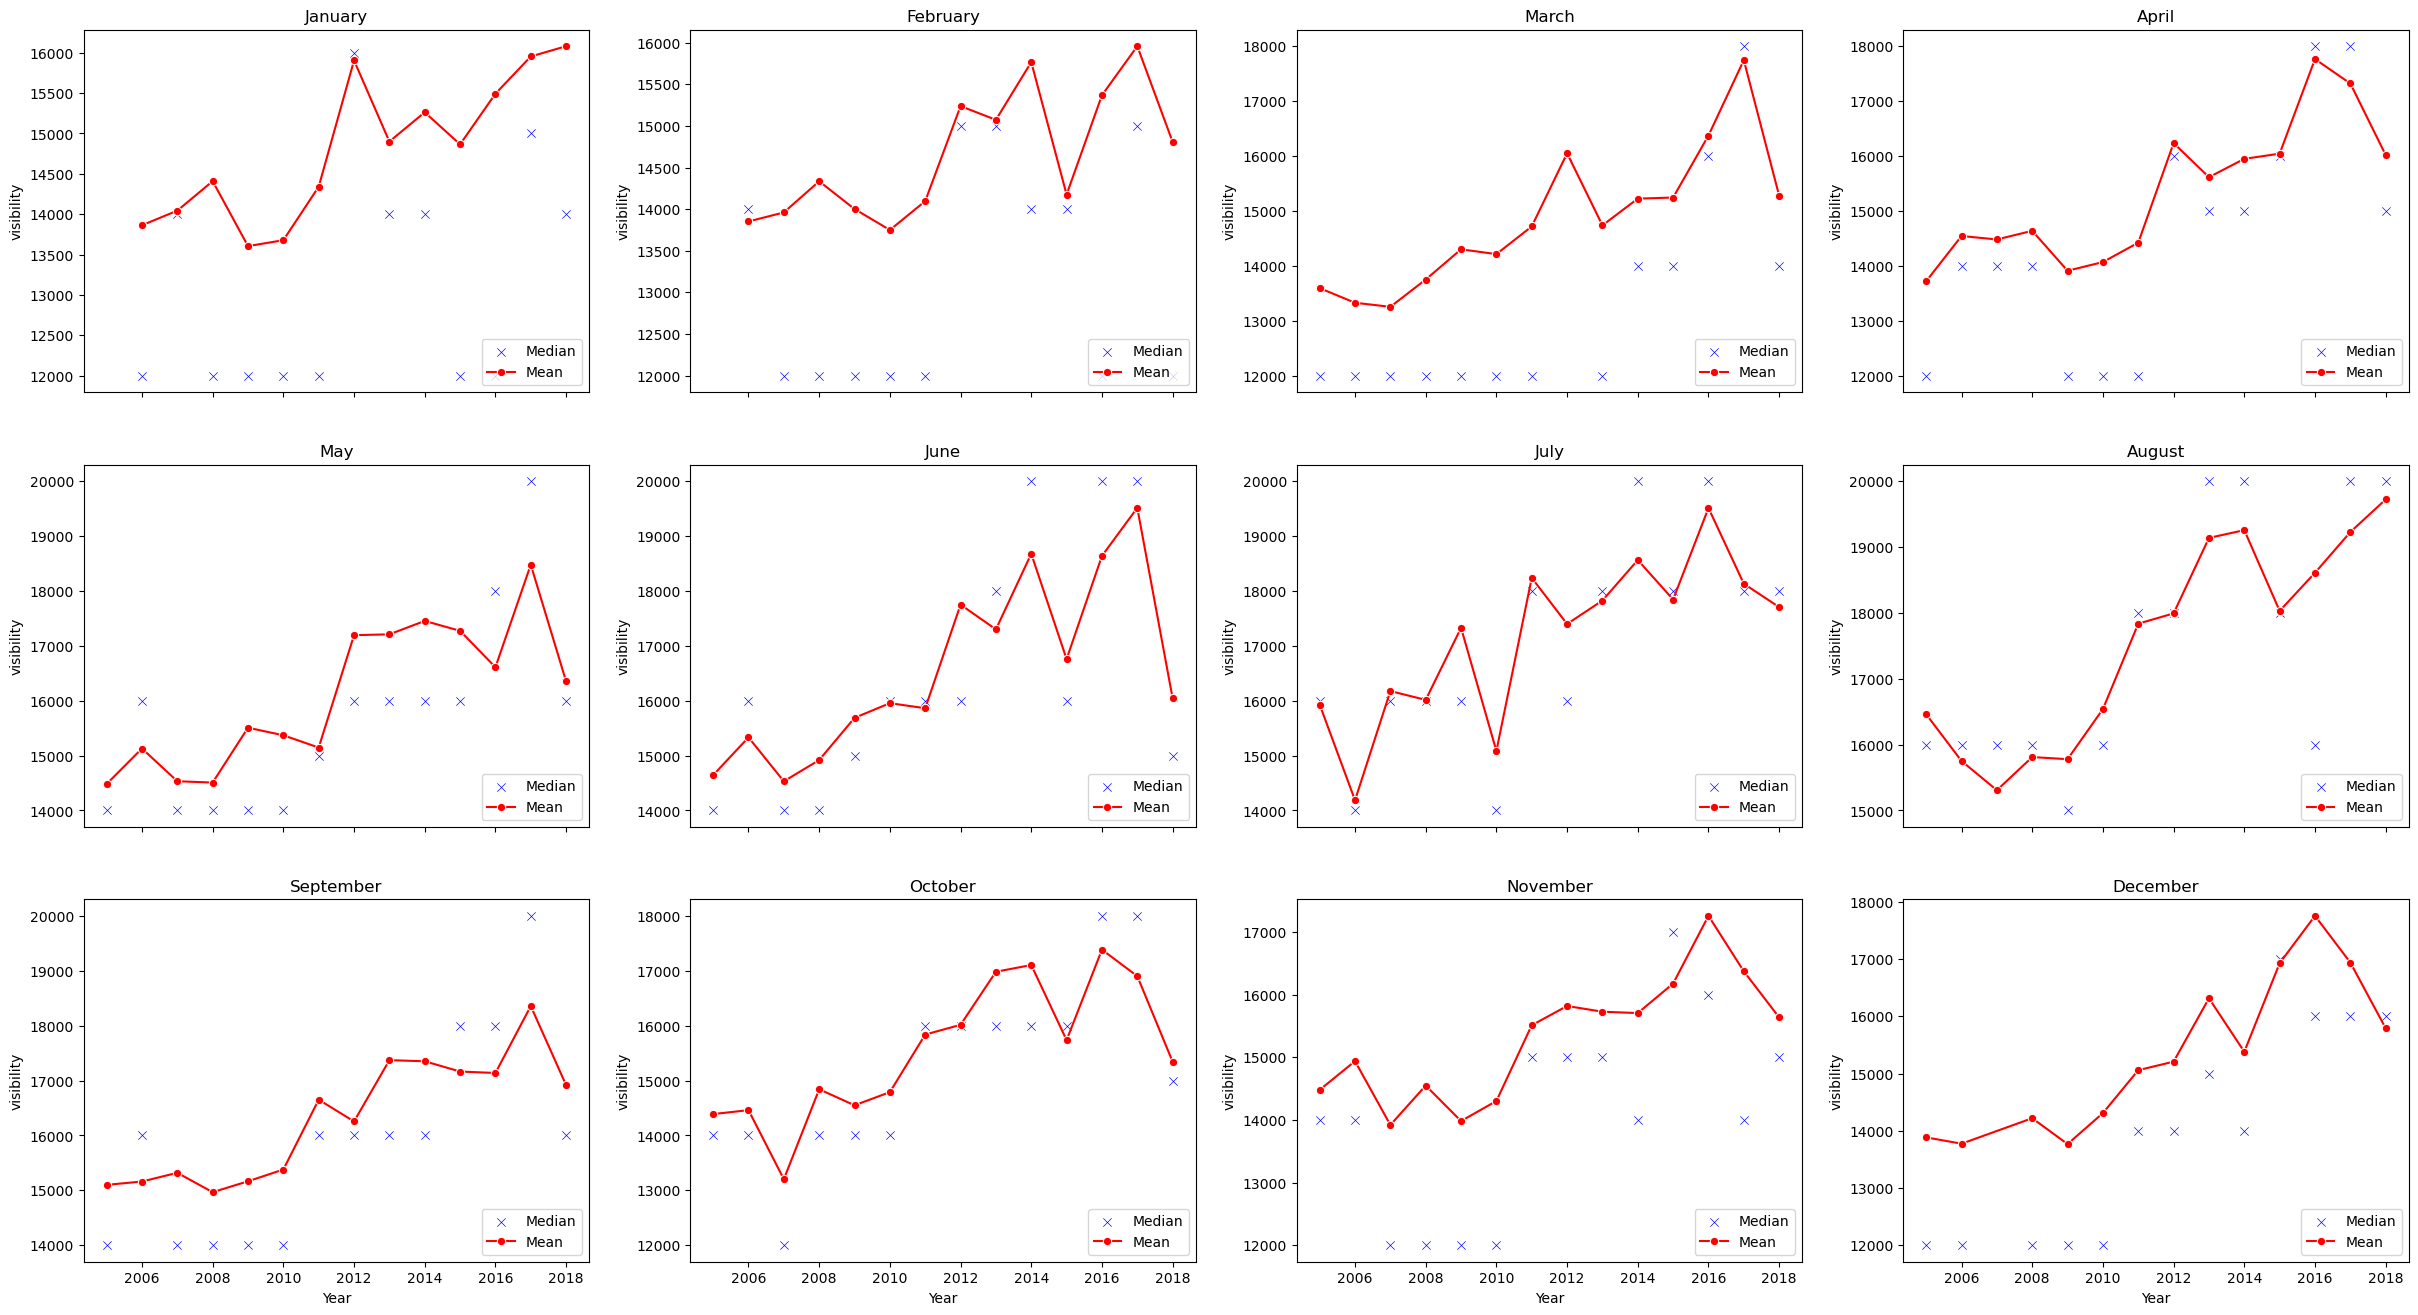

In [18]:
tst = df.groupby(['Year', 'Month'], as_index=False).agg(median=('visibility','median'), mean=('visibility','mean'))
fig,axes = plt.subplots(3, 4, figsize = (30,16), sharex=True)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.scatterplot(data = tst[tst['Month'] == i], x = 'Year', y = 'median', marker = 'x', color = 'blue', ax = ax, label = 'Median')
    sns.lineplot(data = tst[tst['Month'] == i], x = 'Year', y = 'mean', marker = 'o', color = 'red', ax = ax, label = 'Mean')

    ax.set_title(months[i-1])
    ax.set_ylabel('visibility')
    ax.legend(loc='lower right')

    col += 1
    if col % 4 == 0:
        col = 0
        row += 1



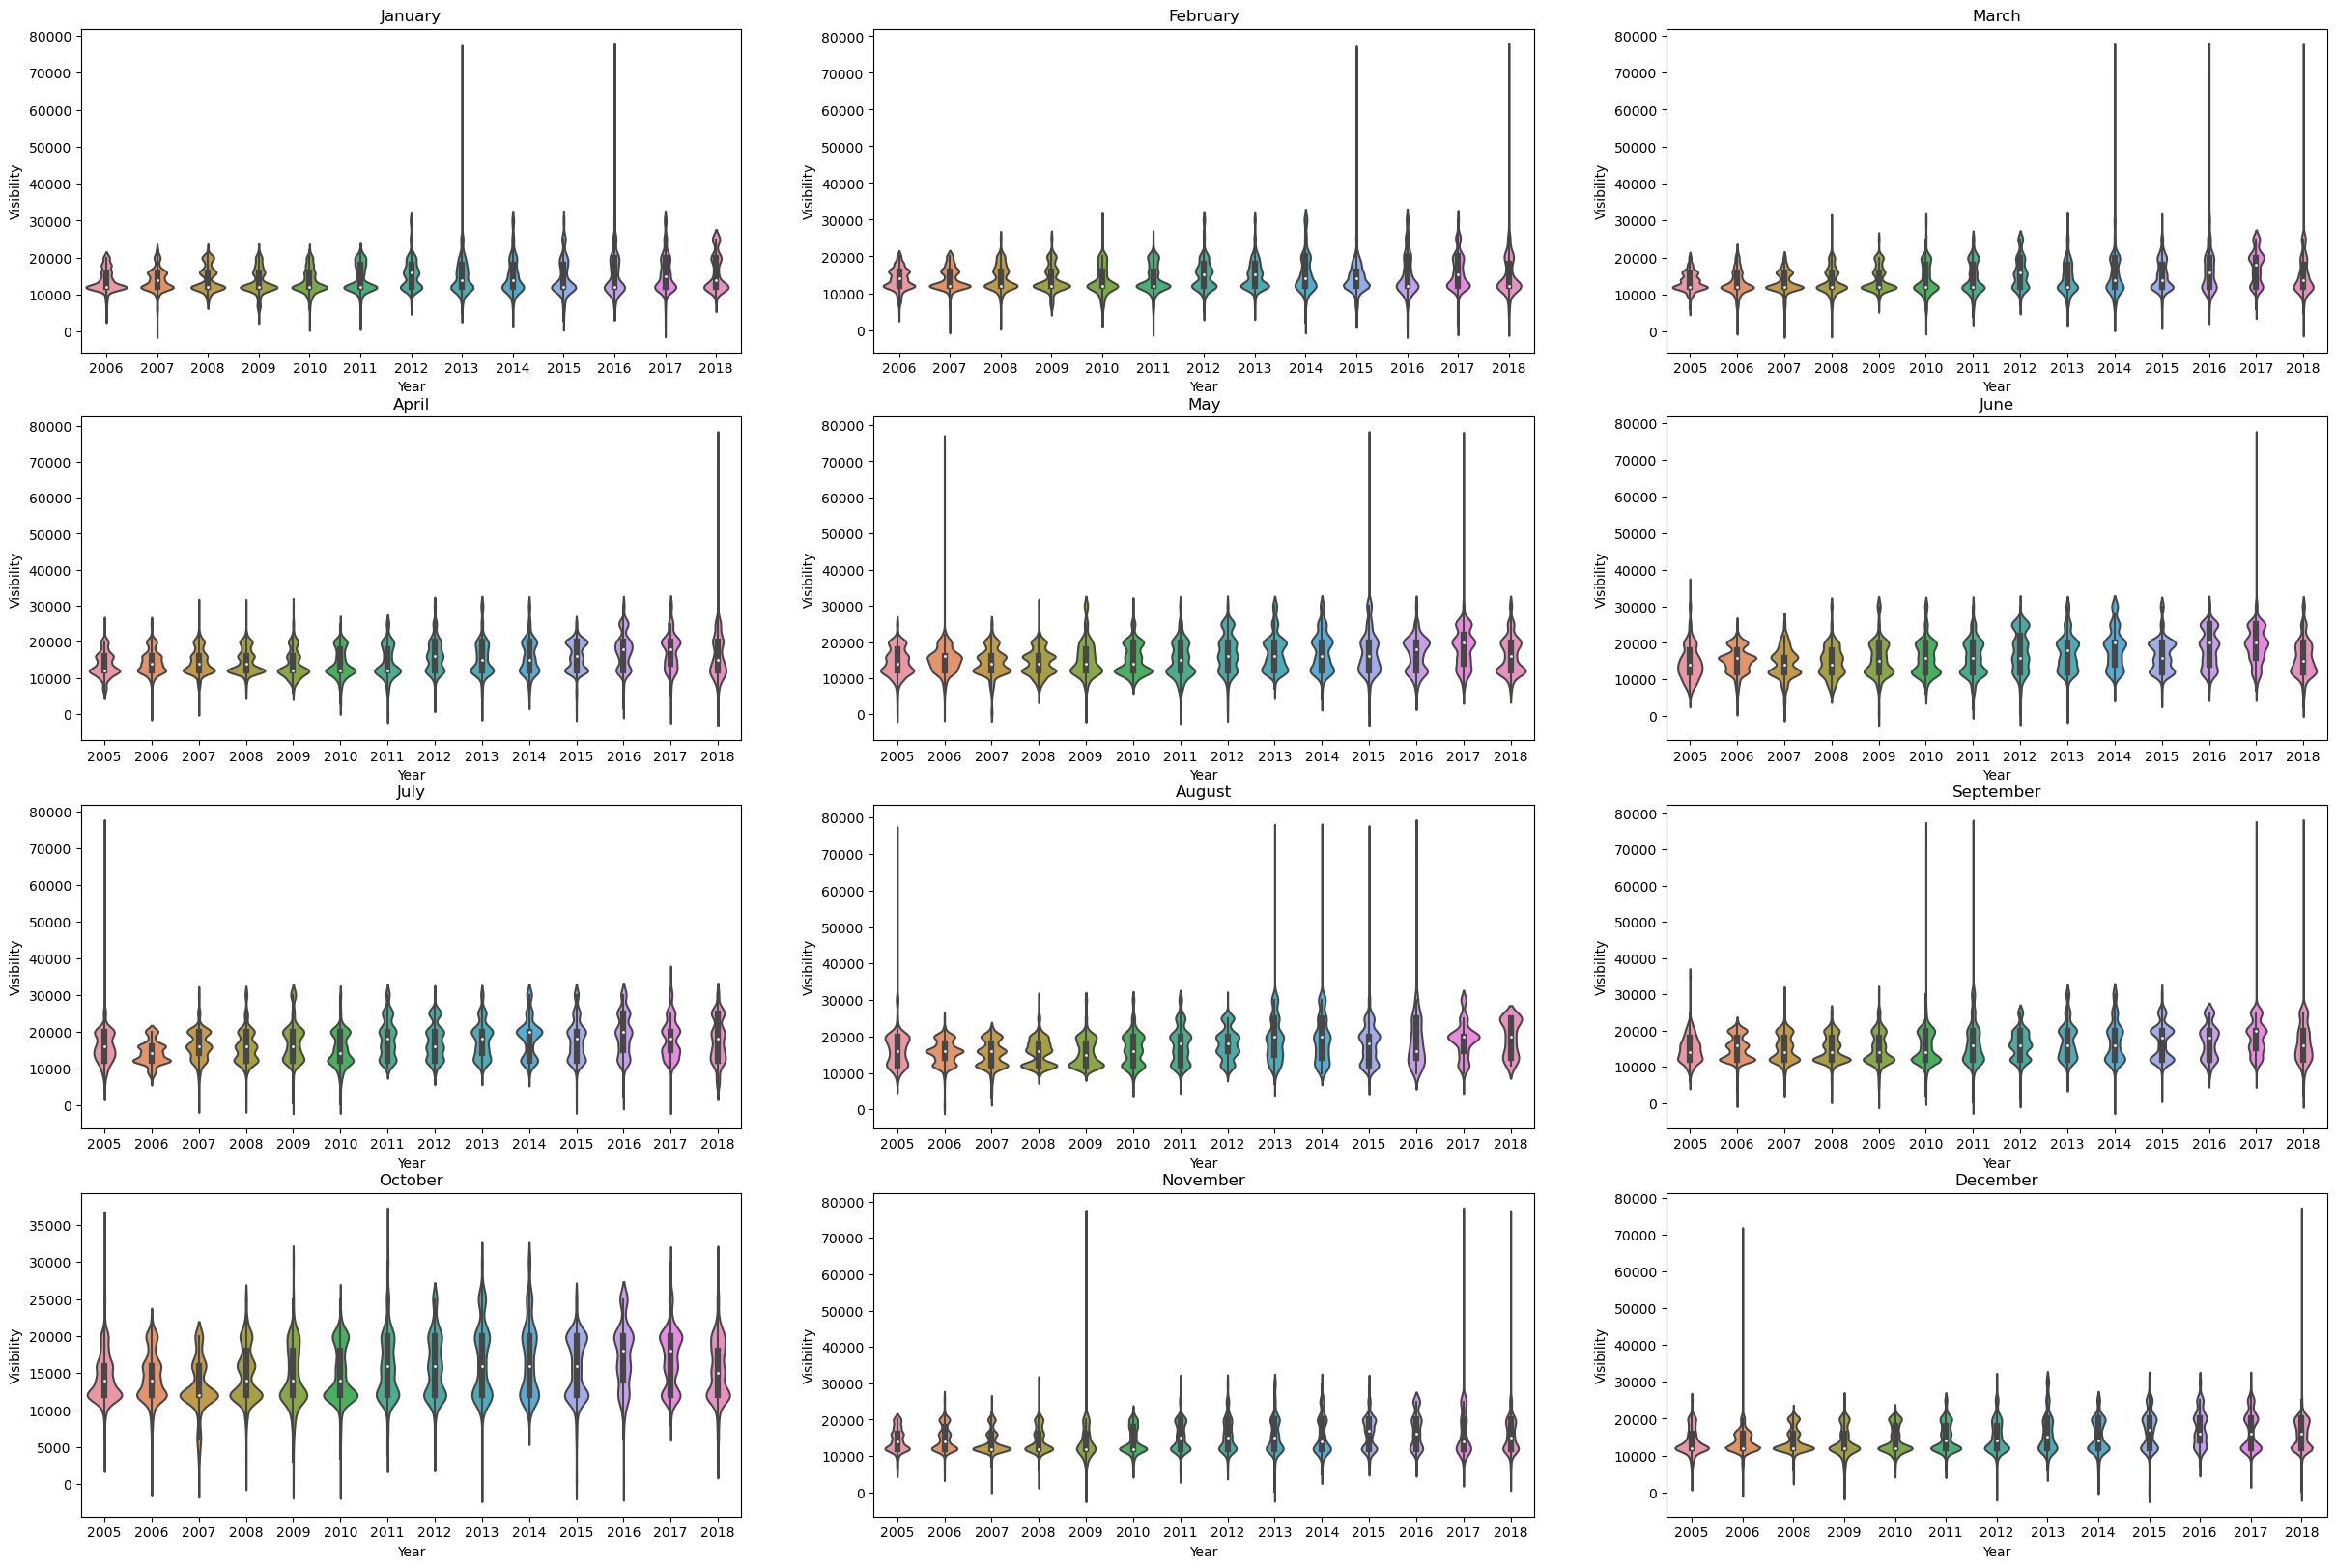

In [19]:
fig,axes = plt.subplots(4, 3, figsize = (30,20))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.violinplot(data = df[df['Month'] == i], x = 'Year', y = 'visibility', marker = 'x', ax = ax)
    

    ax.set_title(months[i-1])
    ax.set_ylabel('Visibility')
    

    col += 1
    if col % 3 == 0:
        col = 0
        row += 1

## Fog

In [20]:
df['fog']=0
df['fog'][df['visibility']<=1000]=1

frac = df[df['fog'] == 1].shape[0] / df.shape[0]
pct = round(frac * 100, 4)
print(f'The percentage of fog cases is {pct}%')


The percentage of fog cases is 0.0973%


C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\645179362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fog'][df['visibility']<=1000]=1


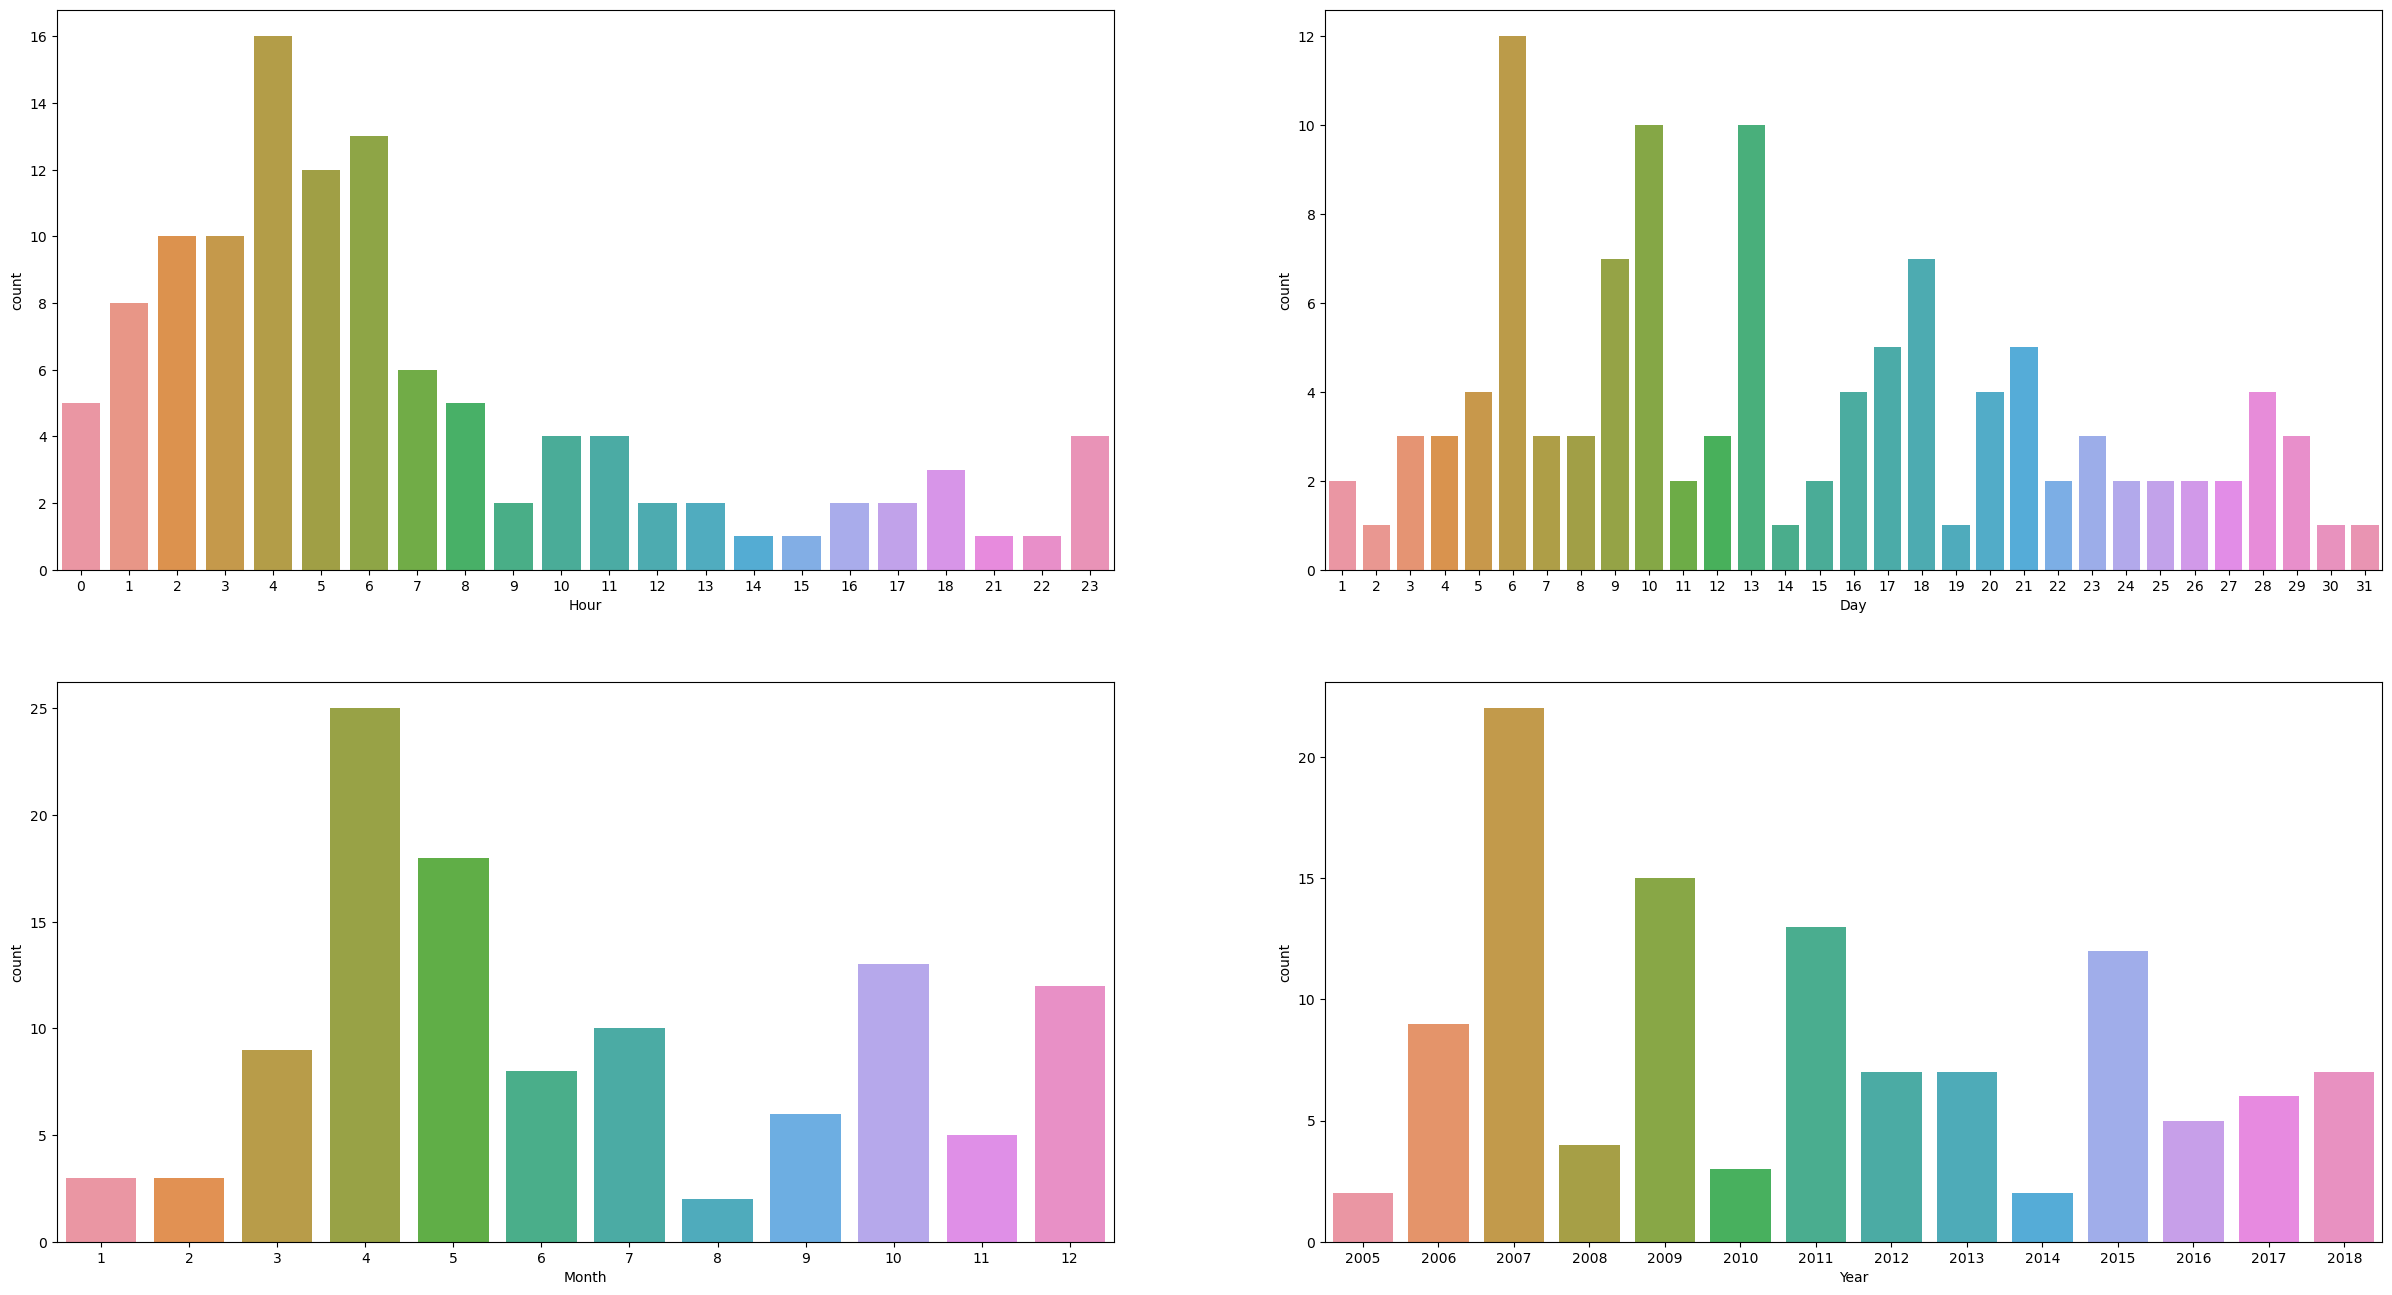

In [21]:
fig, ax = plt.subplots(2,2, figsize = (30,16))

sns.countplot(data = df[df['fog'] == 1], x = 'Hour', ax = ax[0, 0])
sns.countplot(data = df[df['fog'] == 1], x = 'Day', ax = ax[0, 1])
sns.countplot(data = df[df['fog'] == 1], x = 'Month', ax = ax[1, 0])
sns.countplot(data = df[df['fog'] == 1], x = 'Year', ax = ax[1, 1])
plt.show()

## Pressure

In [22]:
var = 'pressure'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

24 Nan out of 117114 data


### NaN imputation

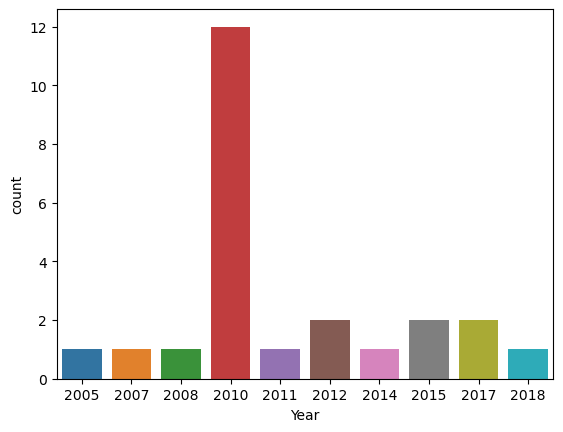

In [23]:
sns.countplot(data = df[['Year']][df[var].isna()], x = 'Year')
plt.show()

In [24]:
nan_ind = list(df[var][df[var].isna()].index)

prob = False
for ind in nan_ind:
    if (ind - 1) in nan_ind or (ind + 1) in nan_ind:
        print(f'There is a consecutive Nan for this variable at index {ind}!')
        prob = True
if prob is False:
    print("There aren't consecutive Nan for this variable!")

There is a consecutive Nan for this variable at index 66370!
There is a consecutive Nan for this variable at index 66371!


In [25]:
tmp = []

for i in nan_ind:
    tmp.append(i)
    tmp.append(i+1)

b = df[[var, 'date_diff']][df.index.isin(tmp)]
if b[b['date_diff'] > 3].shape[0] > 0:
    
    display(b[b['date_diff'] > 3])
    
for ind in nan_ind:
    df[var][ind] = (df[var][ind-1] + df[var][ind+1])/2

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\122593258.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][ind] = (df[var][ind-1] + df[var][ind+1])/2


In [26]:
df['pressure'] = df['pressure'].fillna(np.mean(df['pressure'][~(df['pressure'].isna())]))

### Visualization

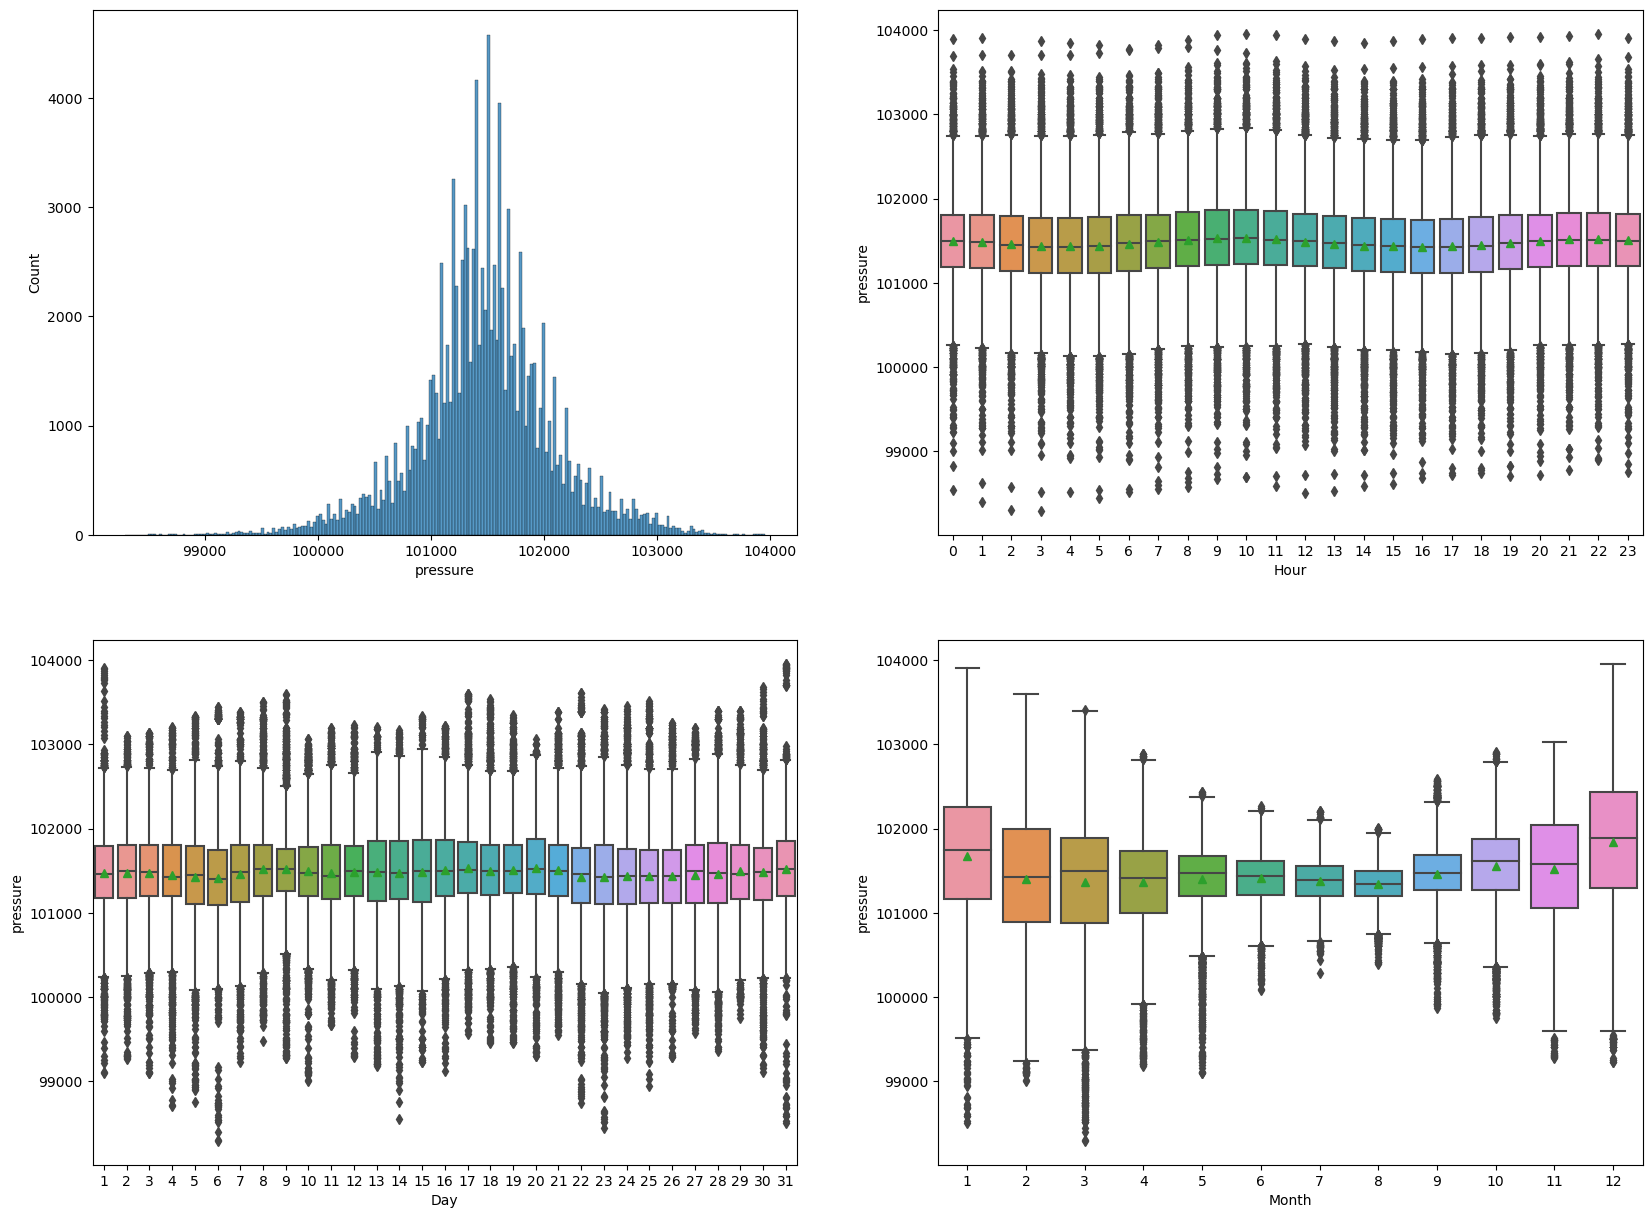

In [27]:
fig, ax = plt.subplots(2,2, figsize = (20,15))
sns.histplot(x= var, data=df, ax = ax[0, 0])
sns.boxplot(data = df, x = 'Hour', y = var, ax = ax[0, 1], showmeans=True)
sns.boxplot(data = df, x = 'Day', y = var, ax = ax[1, 0], showmeans=True)
sns.boxplot(data = df, x = 'Month', y = var, ax = ax[1, 1], showmeans=True)
plt.show()

In [28]:
kurtosis = df['pressure'].kurt(axis = 0)
kurtosis = round(kurtosis, 3)
skew = df['pressure'].skew(axis = 0)
skew = round(skew, 3)
print(f'The kurtosis is: {kurtosis}\nThe skewness is: {skew}')

The kurtosis is: 1.346
The skewness is: -0.122


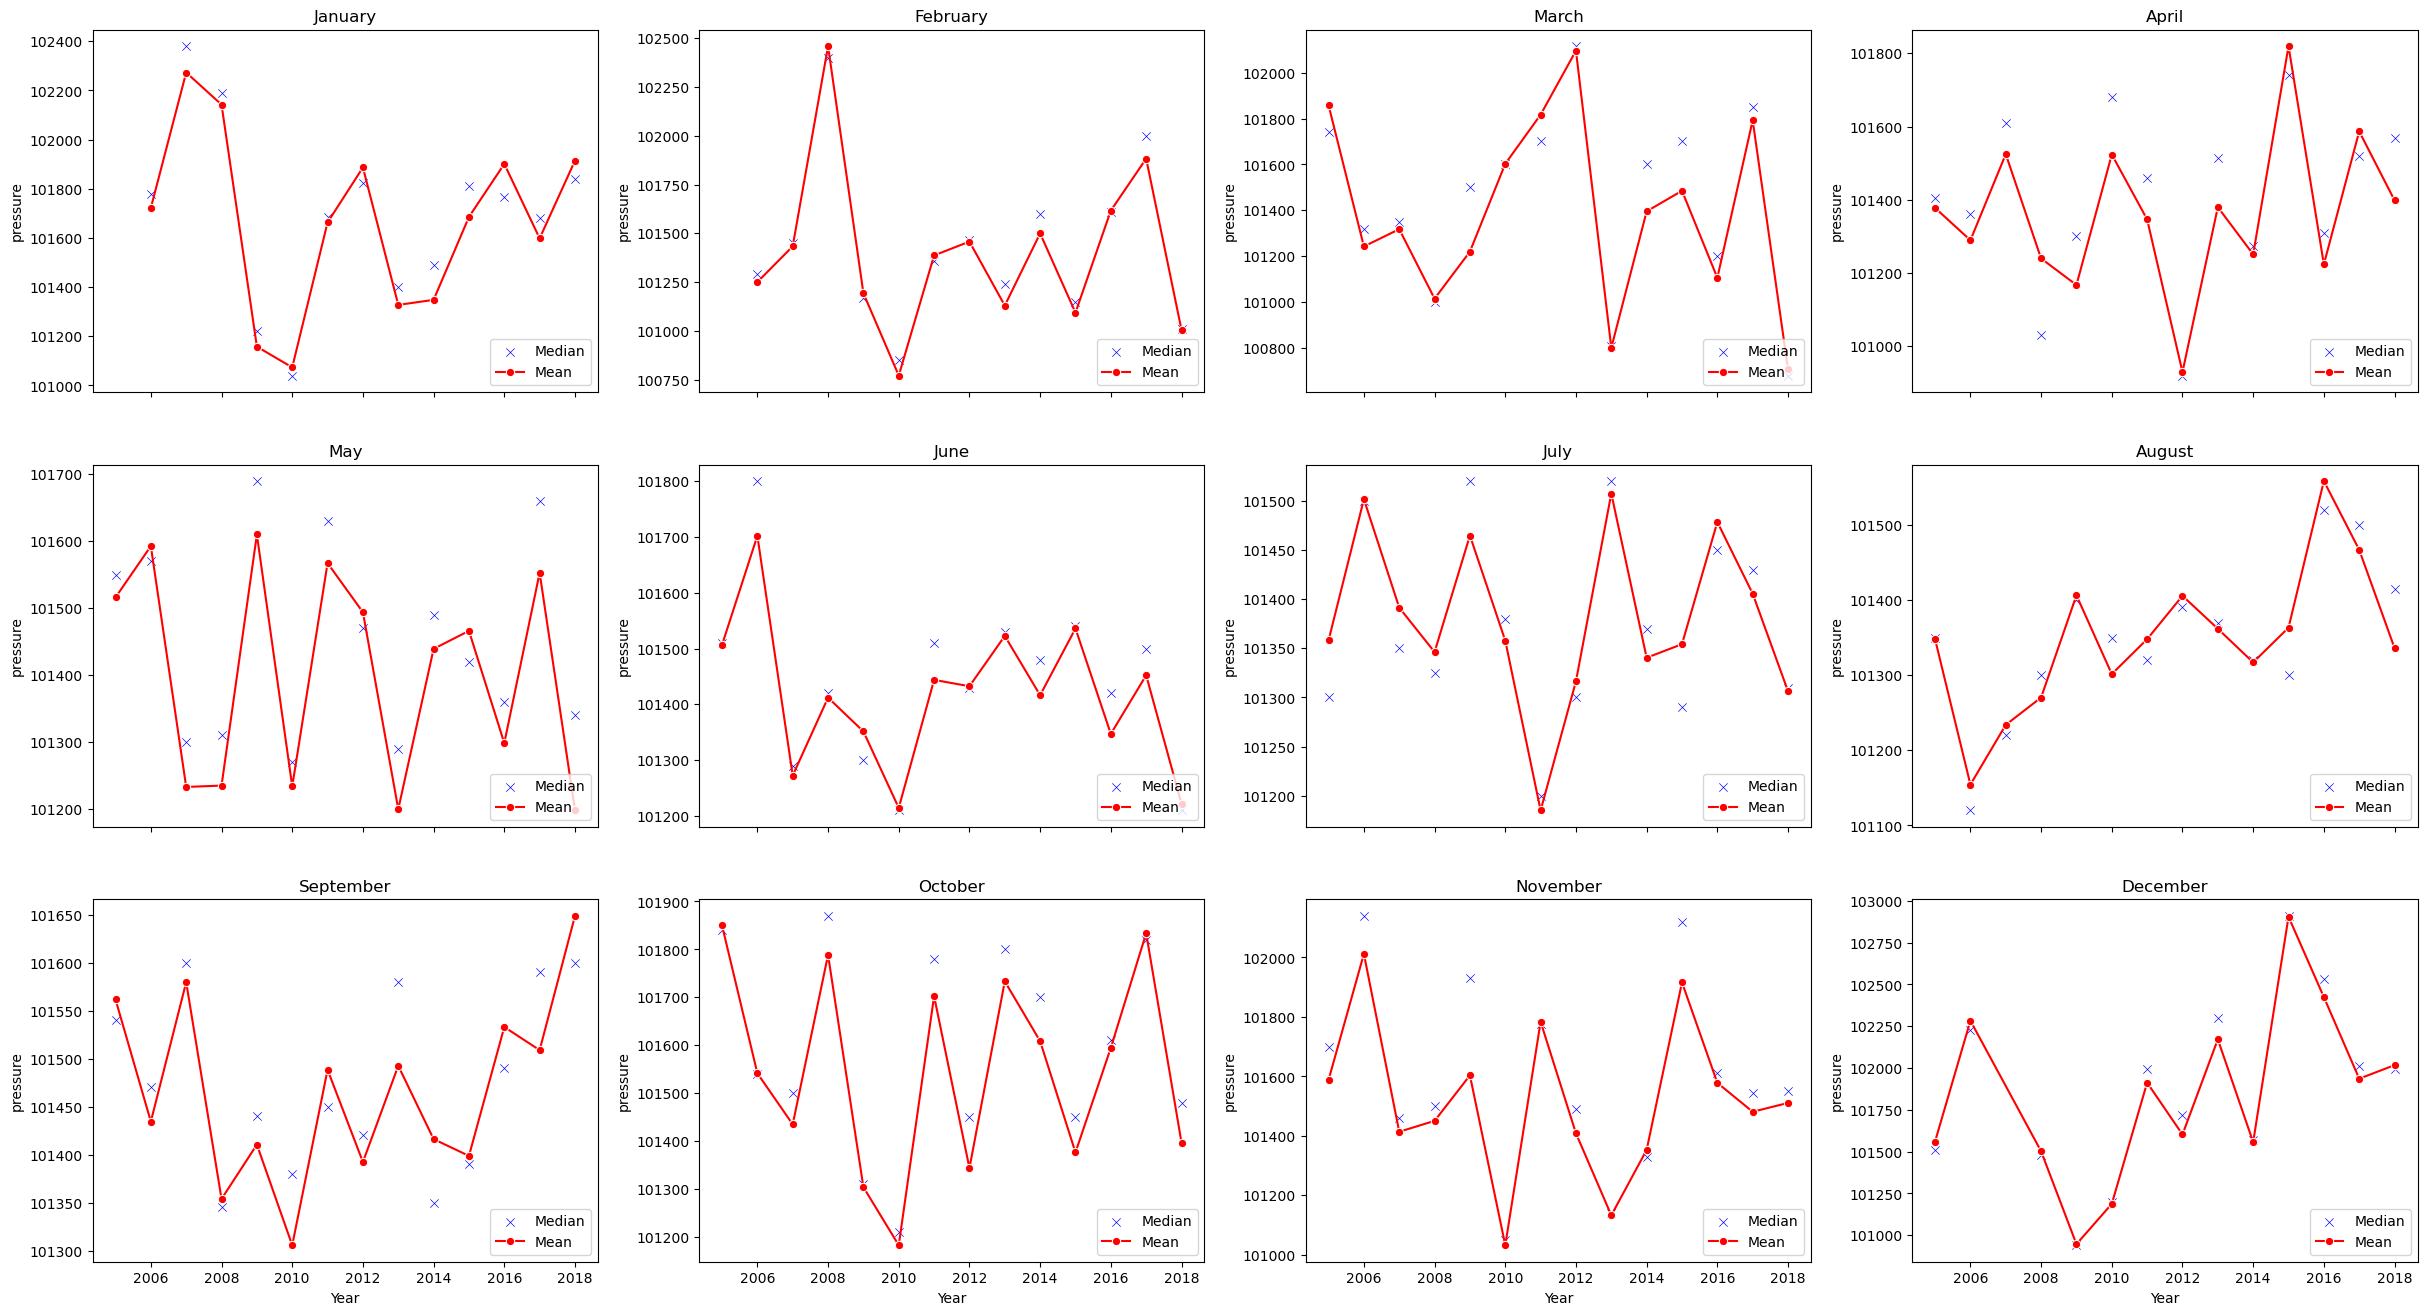

In [29]:
tst = df.groupby(['Year', 'Month'], as_index=False).agg(median=('pressure','median'), mean=('pressure','mean'))
fig,axes = plt.subplots(3, 4, figsize = (30,16), sharex=True)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.scatterplot(data = tst[tst['Month'] == i], x = 'Year', y = 'median', marker = 'x', color = 'blue', ax = ax, label = 'Median')
    sns.lineplot(data = tst[tst['Month'] == i], x = 'Year', y = 'mean', marker = 'o', color = 'red', ax = ax, label = 'Mean')

    ax.set_title(months[i-1])
    ax.set_ylabel('pressure')
    ax.legend(loc='lower right')

    col += 1
    if col % 4 == 0:
        col = 0
        row += 1

## Present weather

In [30]:
var = 'present_weather'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

15 Nan out of 117114 data


In [31]:
## NaN imputation

nan_ind = list(df[df['present_weather'].isna()].index)

for ind in nan_ind:
    if df['present_weather'][ind-1] == df['present_weather'][ind+1]:
        df['present_weather'][ind] = df['present_weather'][ind+1]
    else:
        df['present_weather'][ind] = np.median([df['present_weather'][ind+1], df['present_weather'][ind-1]])


df['present_weather'] = df['present_weather'].astype(int)

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\2307809812.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['present_weather'][ind] = df['present_weather'][ind+1]
C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\2307809812.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['present_weather'][ind] = np.median([df['present_weather'][ind+1], df['present_weather'][ind-1]])


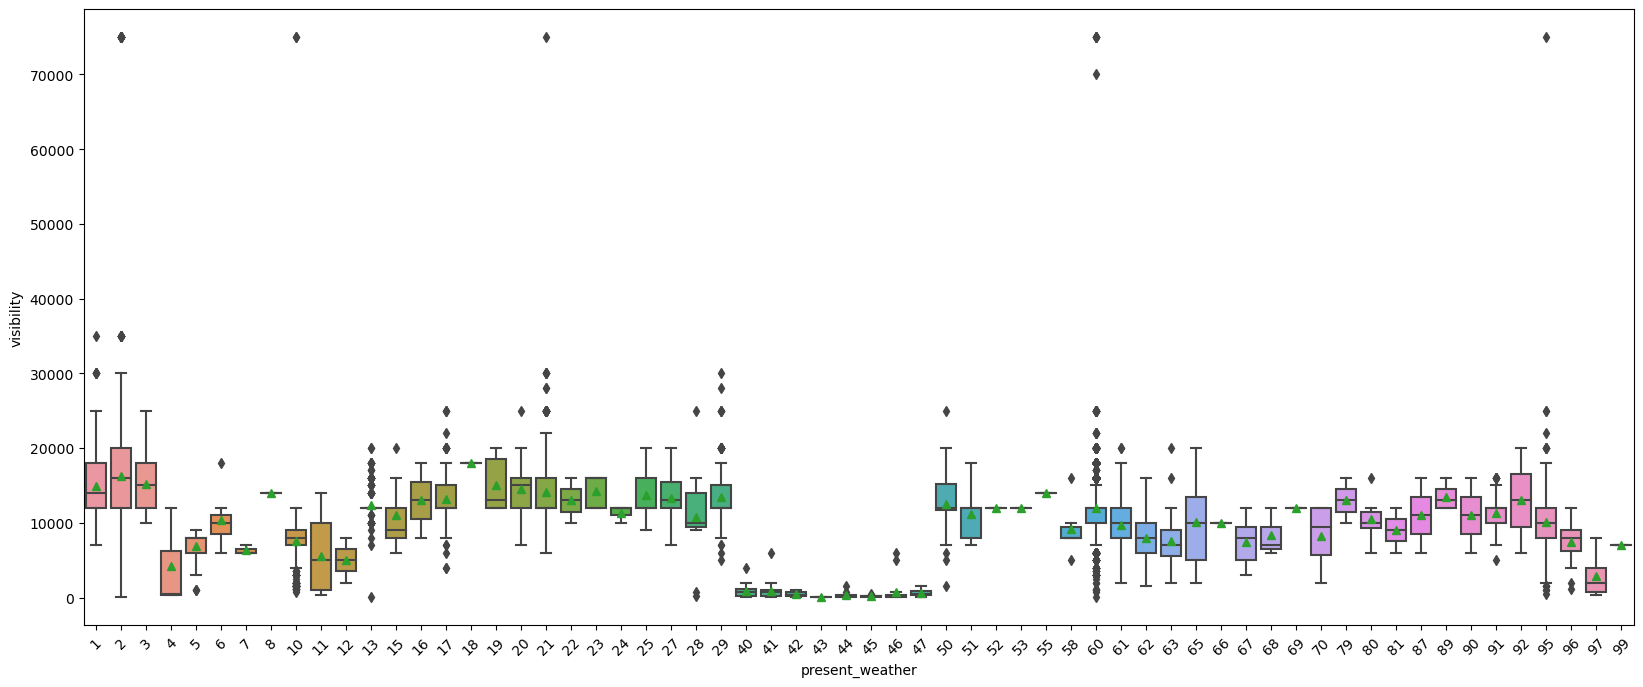

In [32]:
fig, axes = plt.subplots(1,1, figsize = (20, 8))
sns.boxplot(data = df, x  ='present_weather', y = 'visibility', showmeans = True)
plt.xticks(rotation = 45)
plt.show()

### New Present Weather

In [33]:
values = [(0,1,2,3), (4,5,6,7,8,9), (10,), (11,12), (13,), (14, 15, 16), (17,), (18,), (19,),
          (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), range(30,40), range(40, 50), range(50,60),
          range(60,70), range(70, 80), range(80, 100)]

values_new = list(range(1, 26))

df['new_pres_weath'] = 0

for i in range(len(values)):
    df['new_pres_weath'][df['present_weather'].isin(values[i])] = values_new[i]

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\898635501.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_pres_weath'][df['present_weather'].isin(values[i])] = values_new[i]
C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\898635501.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_pres_weath'][df['present_weather'].isin(values[i])] = values_new[i]
C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\898635501.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

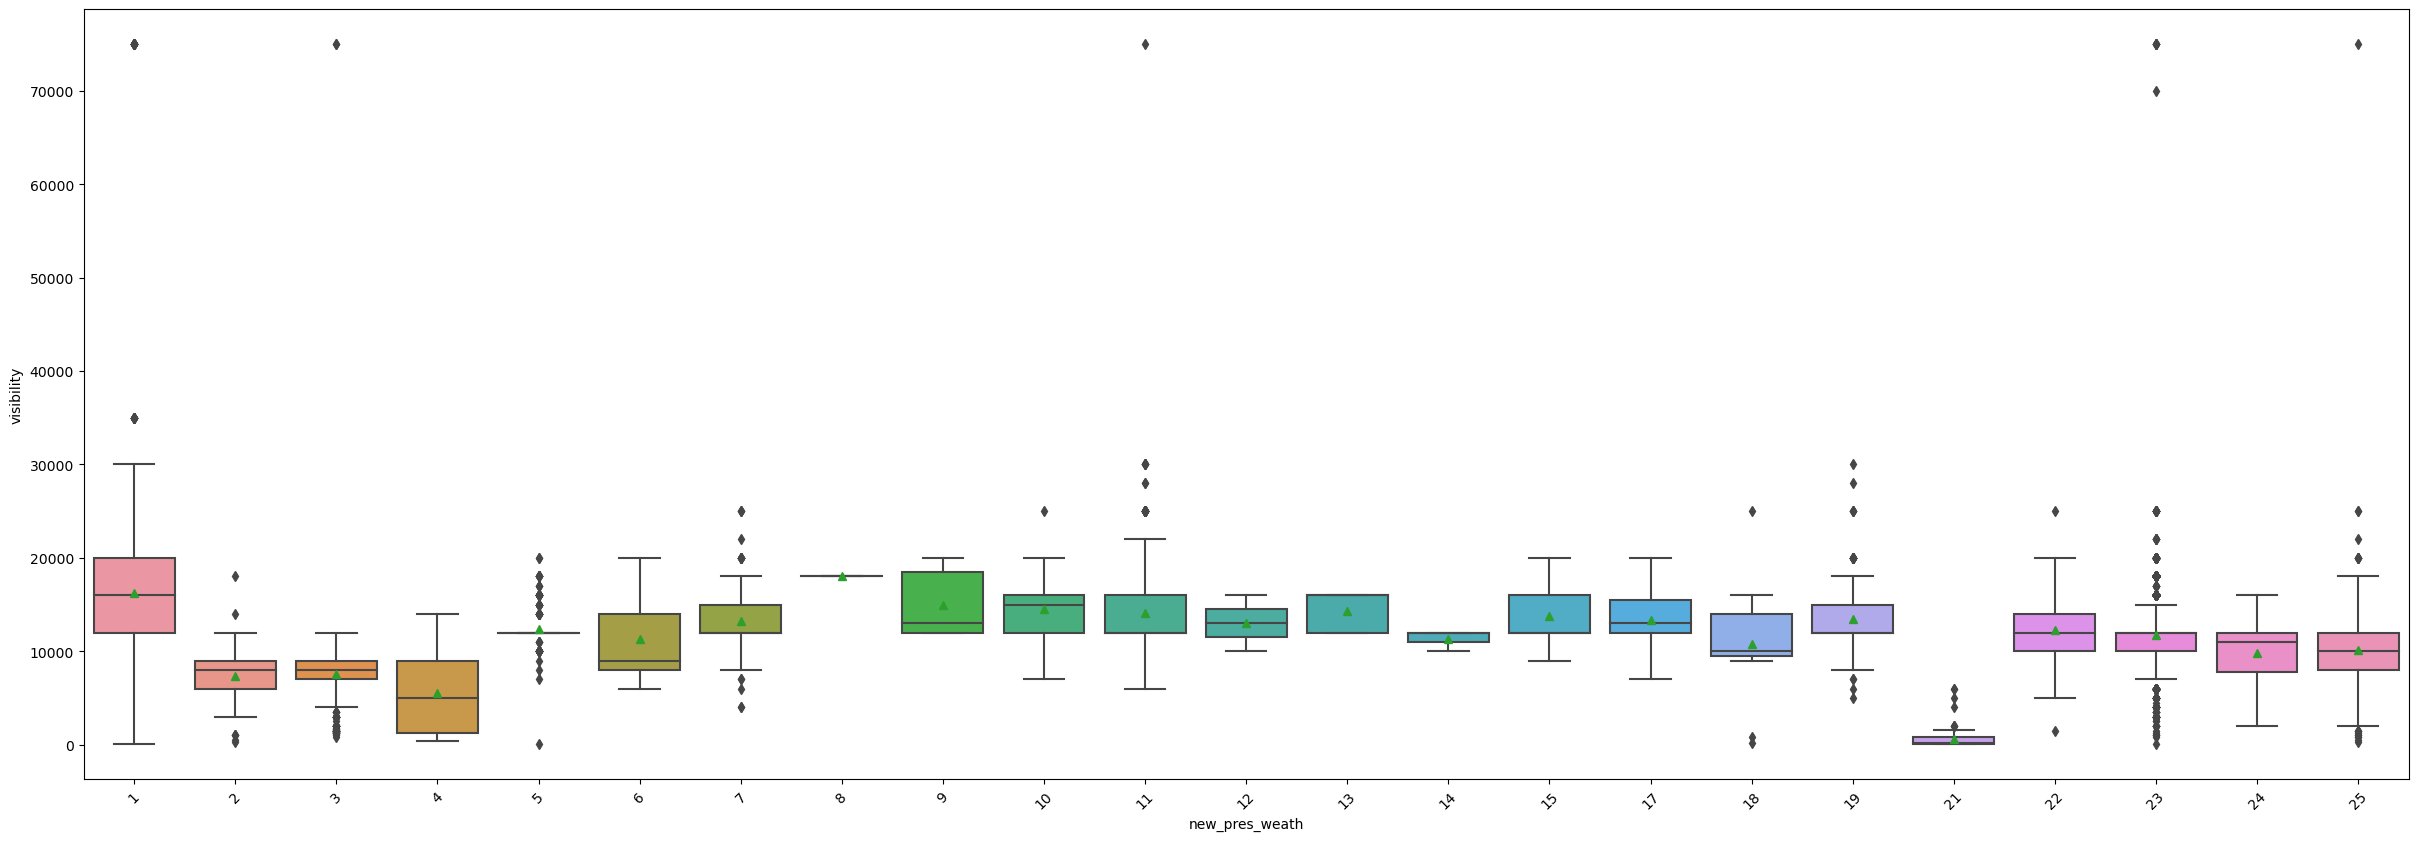

In [34]:
fig, axes = plt.subplots(1,1, figsize = (30, 10))
sns.boxplot(data = df, x  ='new_pres_weath', y = 'visibility', showmeans = True)
plt.xticks(rotation = 45)
plt.show()

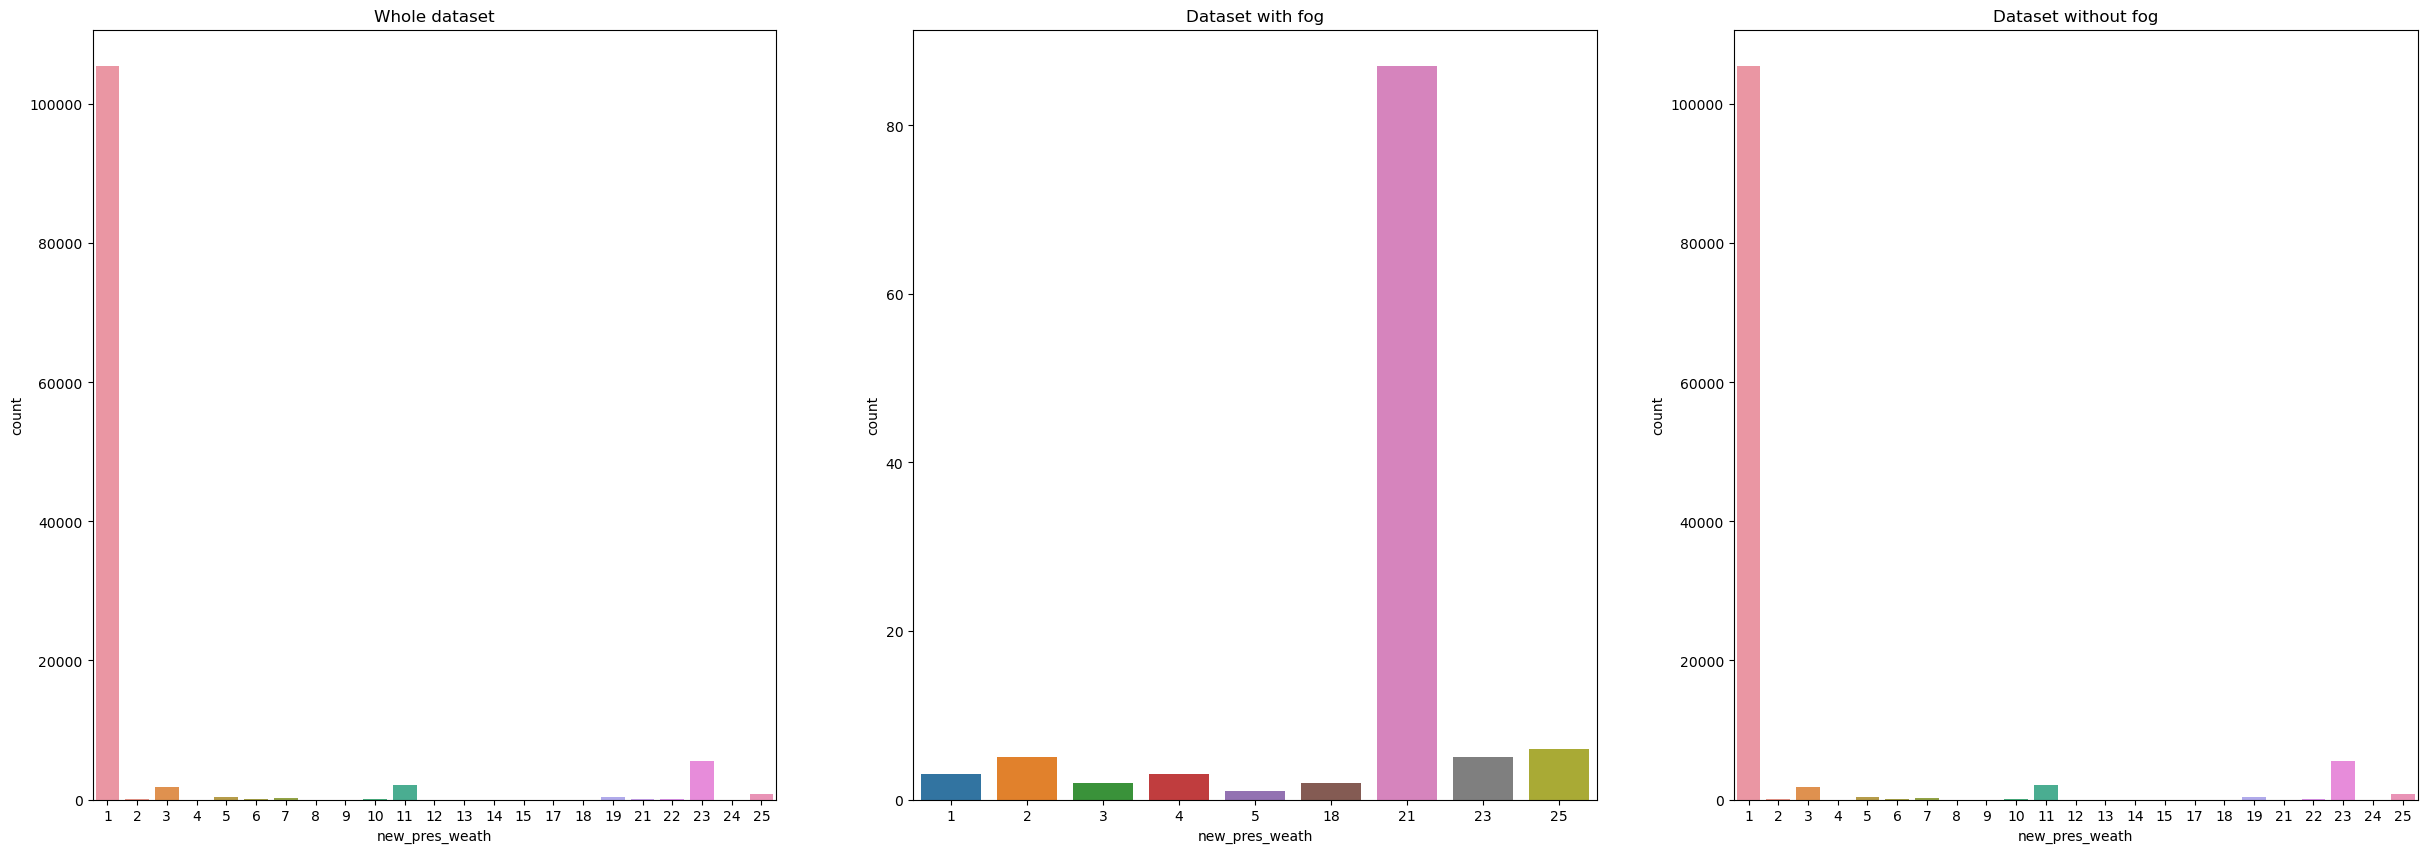

In [35]:
fig, axes = plt.subplots(1,3,figsize = (30,10))
sns.countplot(data = df, x = 'new_pres_weath', ax = axes[0])
sns.countplot(data = df[df['fog'] == 1], x = 'new_pres_weath', ax = axes[1])
sns.countplot(data = df[df['fog'] == 0], x = 'new_pres_weath', ax = axes[2])

axes[0].set_title('Whole dataset')
axes[1].set_title('Dataset with fog')
axes[2].set_title('Dataset without fog')
plt.show()

## Past weather 1/2

In [36]:
var = 'past_weather1'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

23 Nan out of 117114 data


In [37]:
## NaN imputation

nan_ind = list(df[df['past_weather1'].isna()].index)

for ind in nan_ind:
    df['past_weather1'][ind] = df['past_weather2'][ind + 1]

df['past_weather1'] = df['past_weather1'].astype(int)

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\1465452116.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['past_weather1'][ind] = df['past_weather2'][ind + 1]


In [38]:
var = 'past_weather2'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

17 Nan out of 117114 data


In [39]:
## NaN imputation

nan_ind = list(df[df['past_weather2'].isna()].index)

for ind in nan_ind:
    df['past_weather2'][ind] = df['past_weather1'][ind - 1]

df['past_weather2'] = df['past_weather2'].astype(int)

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\612731425.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['past_weather2'][ind] = df['past_weather1'][ind - 1]


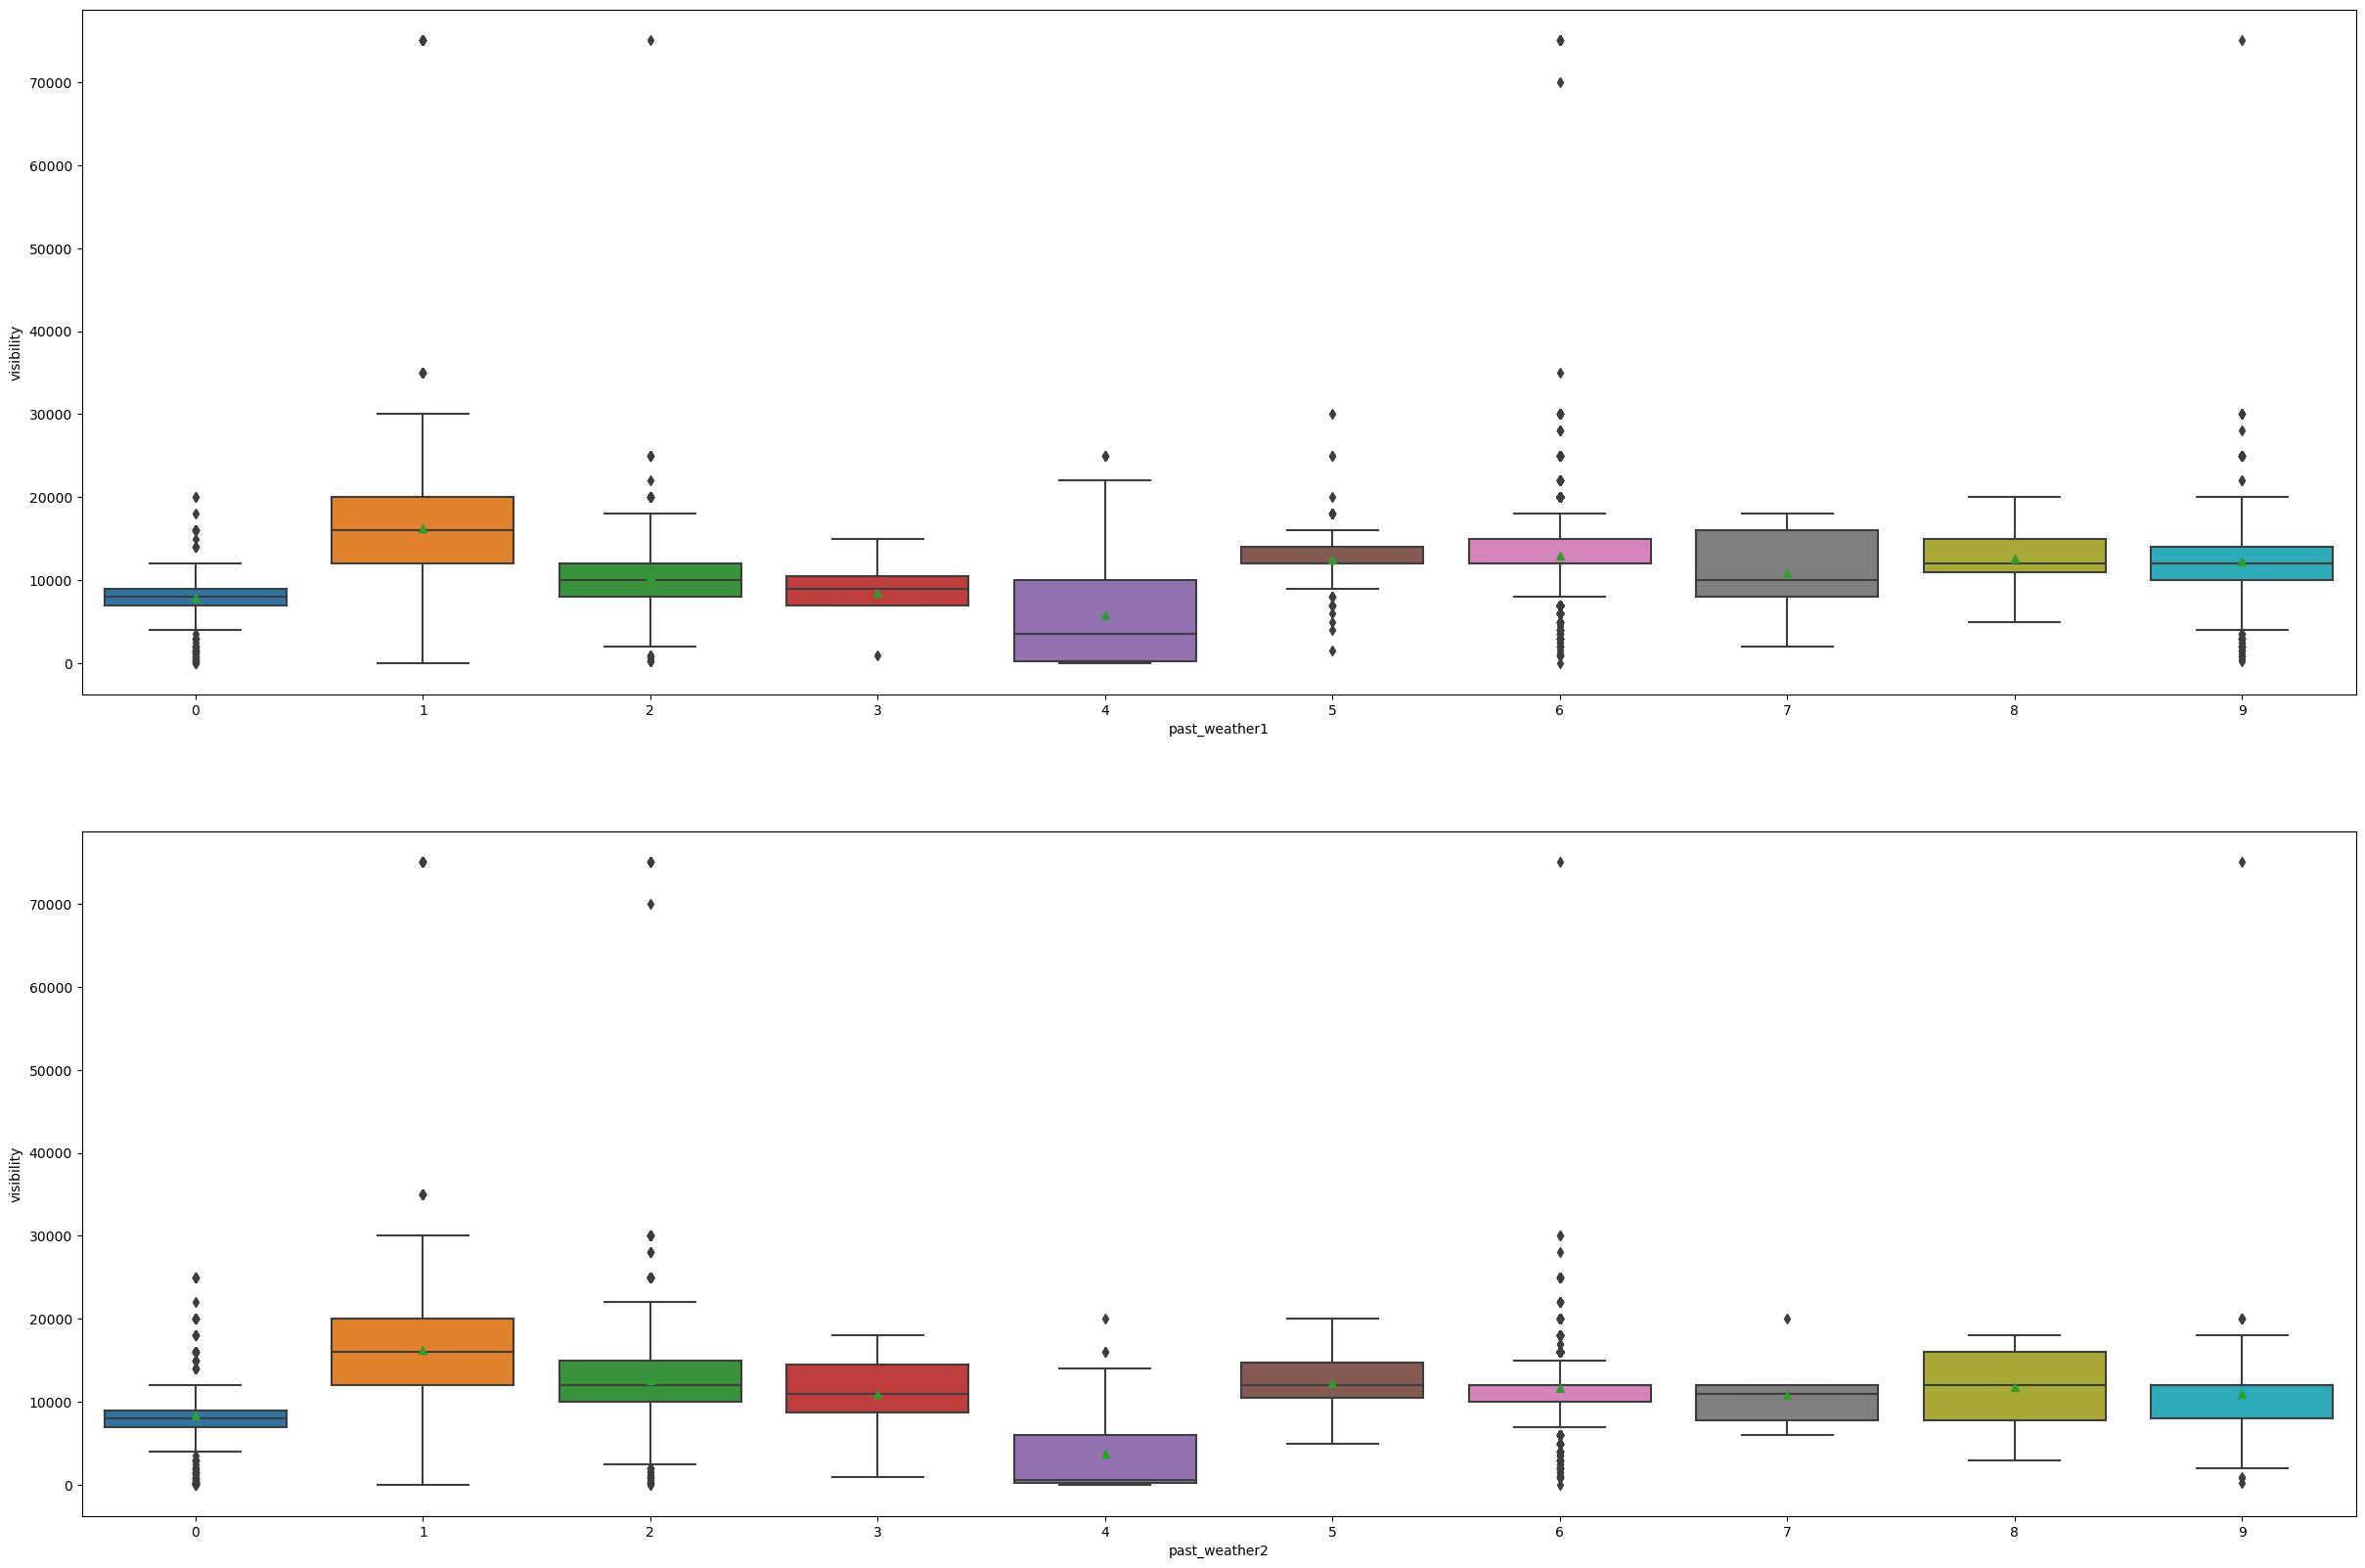

In [40]:
fig, axes = plt.subplots(2,1, figsize = (30, 20))
sns.boxplot(data = df, x  ='past_weather1', y = 'visibility', showmeans = True, ax = axes[0])
sns.boxplot(data = df, x  ='past_weather2', y = 'visibility', showmeans = True, ax = axes[1])
plt.show()

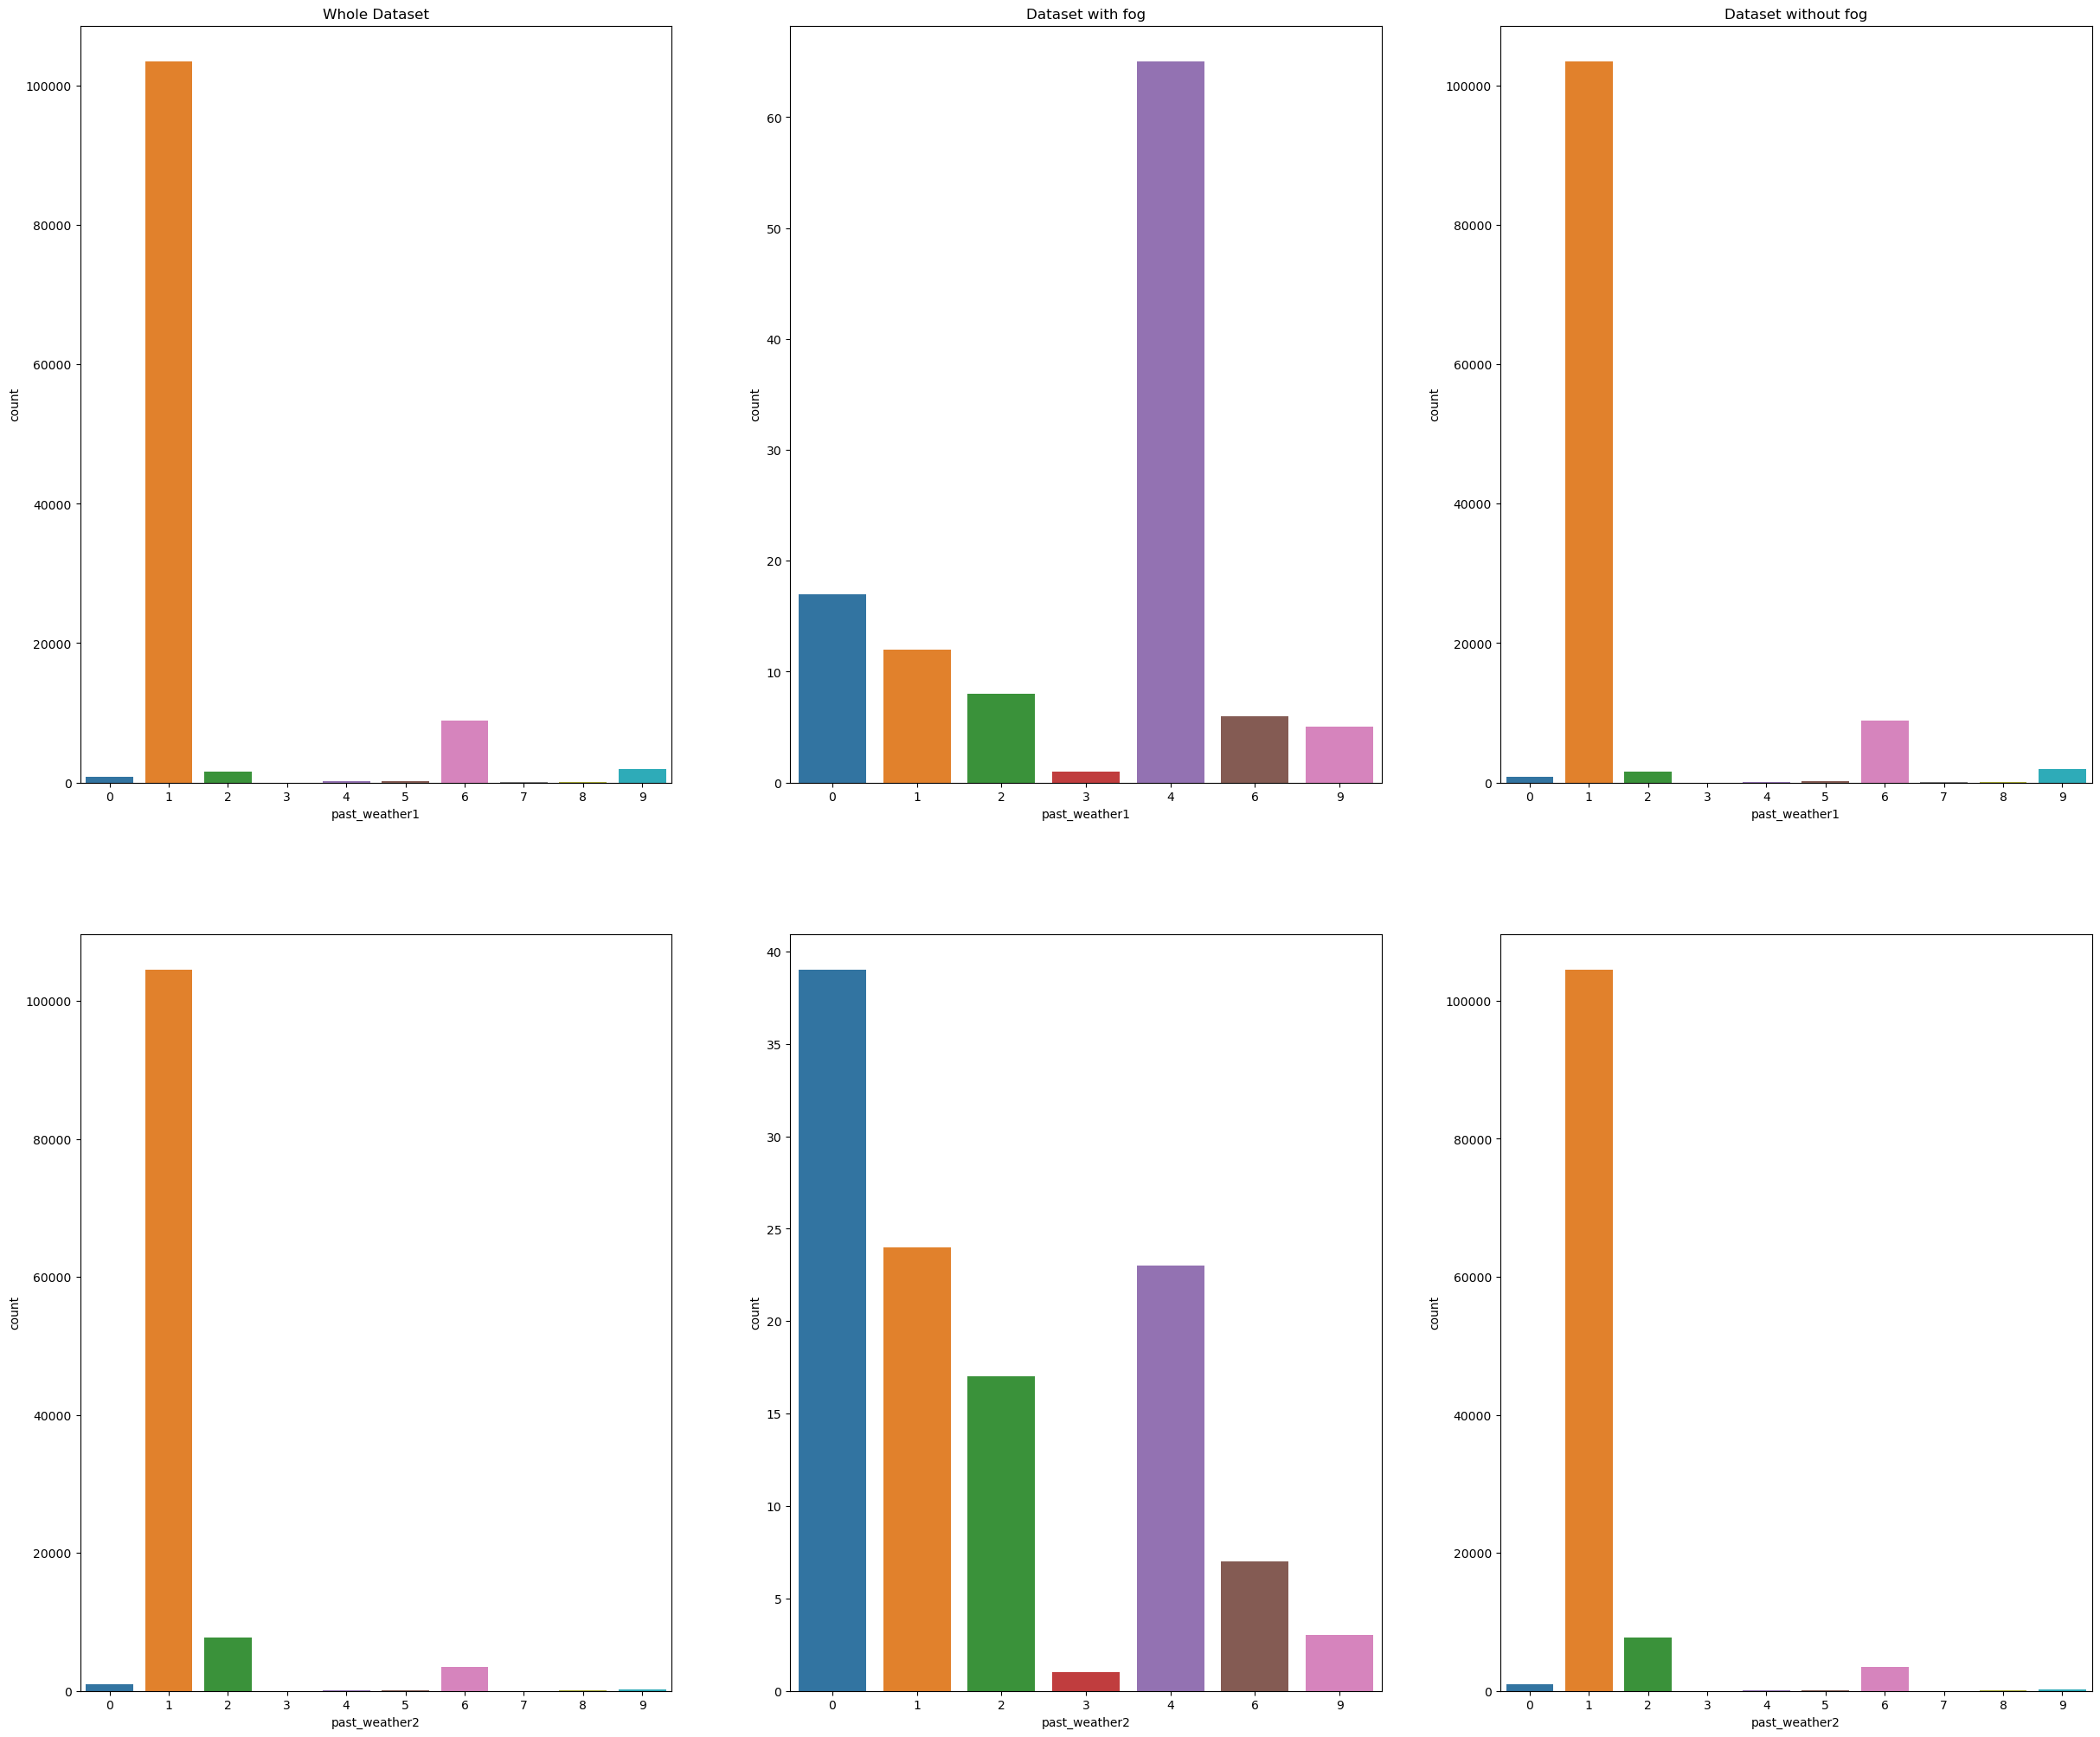

In [41]:
fig, axes = plt.subplots(2,3,figsize = (30,25))

sns.countplot(data = df, x = 'past_weather1', ax = axes[0, 0])
sns.countplot(data = df[df['fog'] == 1], x = 'past_weather1', ax = axes[0, 1])
sns.countplot(data = df[df['fog'] == 0], x = 'past_weather1', ax = axes[0, 2])

sns.countplot(data = df, x = 'past_weather2', ax = axes[1, 0])
sns.countplot(data = df[df['fog'] == 1], x = 'past_weather2', ax = axes[1, 1])
sns.countplot(data = df[df['fog'] == 0], x = 'past_weather2', ax = axes[1, 2])

axes[0,0].set_title('Whole Dataset')
axes[0,1].set_title('Dataset with fog')
axes[0,2].set_title('Dataset without fog')

plt.show()

## Wind Direction

In [42]:
var = 'wind_direction'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

12 Nan out of 117114 data


In [43]:
df['wind_direction'].unique()

array([190., 160., 100., 230., 220., 110., 130.,  70.,   0., 140., 120.,
       300., 260., 270., 290., 310., 320., 330., 360.,  40., 170., 150.,
       340.,  20.,  30.,  80.,  10., 350.,  60., 250., 280., 240., 180.,
       200.,  90.,  50., 210.,  nan,  39.,  37., 500.])

In [44]:
df['wind_direction'][df['wind_direction'] == 500] = 140
df['wind_direction'][df['wind_direction'] == 360] = 0

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\3348832018.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wind_direction'][df['wind_direction'] == 500] = 140
C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\3348832018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wind_direction'][df['wind_direction'] == 360] = 0


In [45]:
df['wind_direction'].unique()

array([190., 160., 100., 230., 220., 110., 130.,  70.,   0., 140., 120.,
       300., 260., 270., 290., 310., 320., 330.,  40., 170., 150., 340.,
        20.,  30.,  80.,  10., 350.,  60., 250., 280., 240., 180., 200.,
        90.,  50., 210.,  nan,  39.,  37.])

In [46]:
nan_ind = list(df[var][df[var].isna()].index)

prob = False
for ind in nan_ind:
    if (ind - 1) in nan_ind or (ind + 1) in nan_ind:
        print(f'There is a consecutive Nan for this variable at index {ind}!')
        prob = True
if prob is False:
    print("There aren't consecutive Nan for this variable!")

There aren't consecutive Nan for this variable!


In [47]:
tmp = []

for i in nan_ind:
    tmp.append(i)
    tmp.append(i+1)

b = df[[var, 'date_diff']][df.index.isin(tmp)]
if b[b['date_diff'] > 3].shape[0] > 0:
    
    display(b[b['date_diff'] > 3])
    
for ind in nan_ind:
    df[var][ind] = np.median([df[var][ind-1], df[var][ind+1]])

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\3471183847.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][ind] = np.median([df[var][ind-1], df[var][ind+1]])


In [48]:
df['wind_direction'] = df['wind_direction'].fillna(np.median(df.dropna()['wind_direction']))

In [49]:
def round_10(num):
    intero = num // 10
    resto = num % 10
    if resto >= 5:
        return (intero + 1) * 10
    else:
        return intero * 10
    
df['wind_direction'] = df['wind_direction'].astype(int)
df['wind_direction'] = df['wind_direction'].apply(round_10)
df['wind_direction'][df['wind_direction']==360] = 0

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\4082880089.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wind_direction'][df['wind_direction']==360] = 0


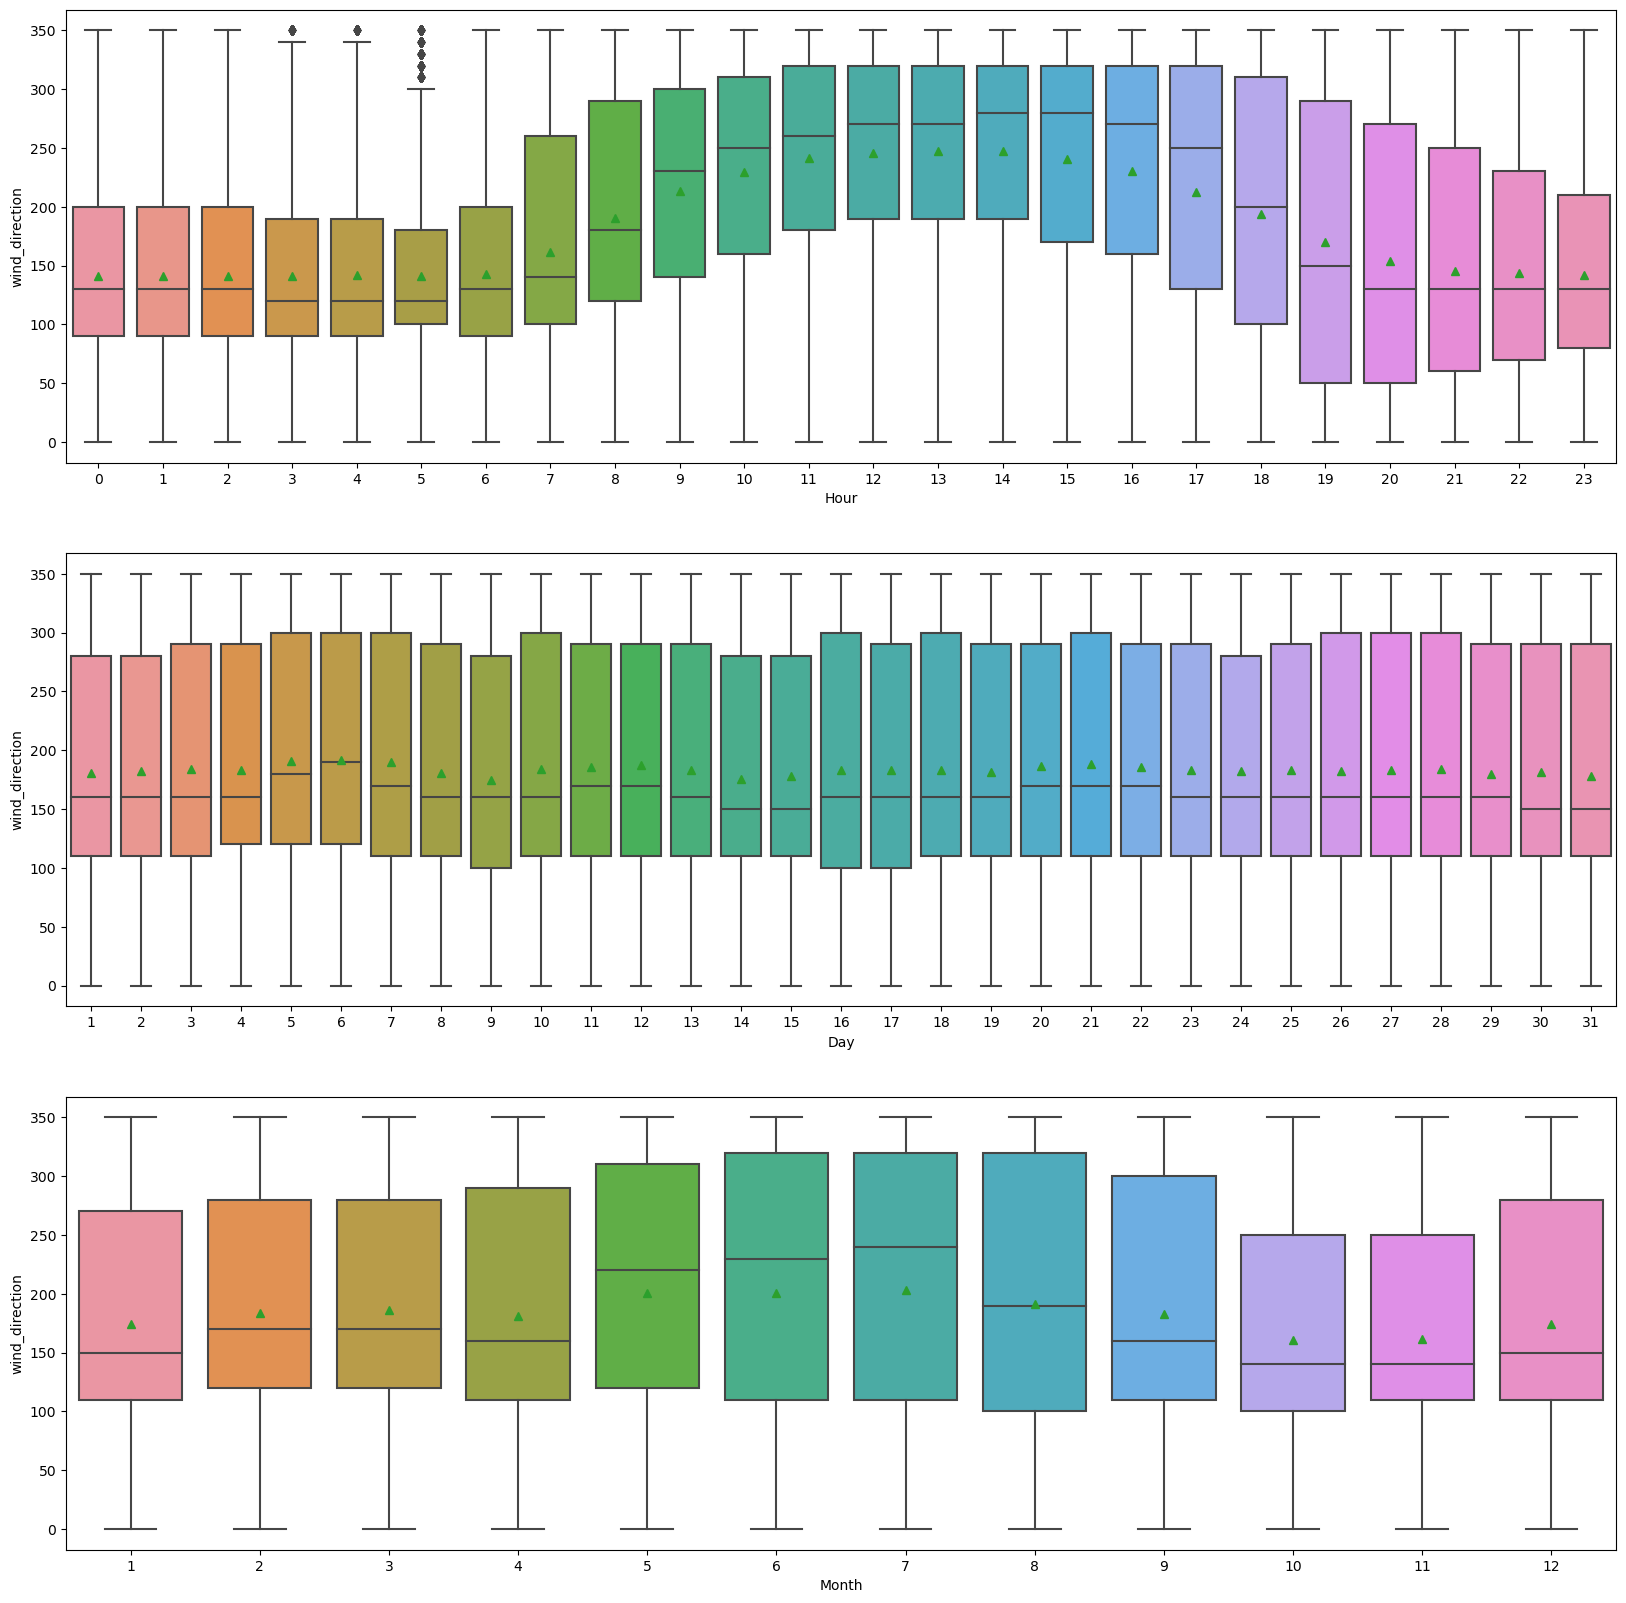

In [50]:
fig, ax = plt.subplots(3,1, figsize = (20,20))
sns.boxplot(data = df, x = 'Hour', y = var, ax = ax[0], showmeans=True)
sns.boxplot(data = df, x = 'Day', y = var, ax = ax[1], showmeans=True)
sns.boxplot(data = df, x = 'Month', y = var, ax = ax[2], showmeans=True)
plt.show()

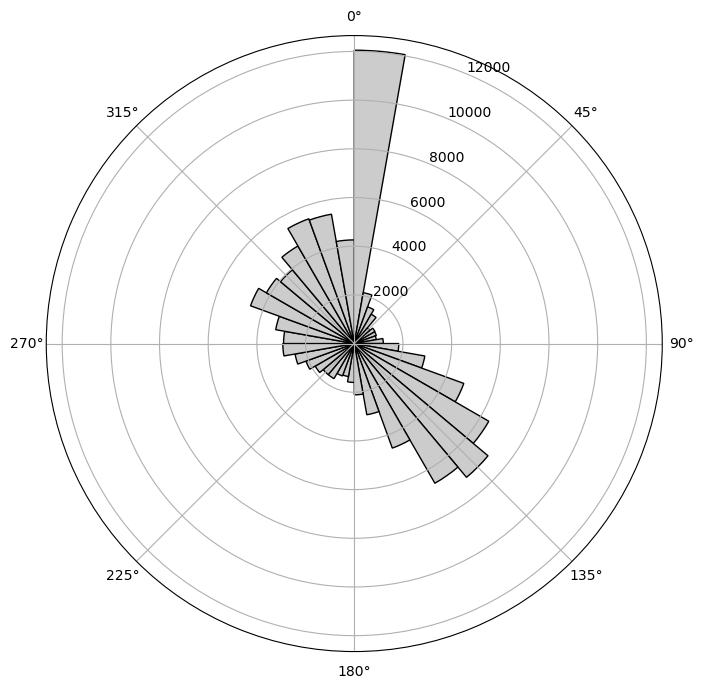

In [51]:
degrees = df['wind_direction']
radians = np.deg2rad(degrees)


bin_size = 10
a , b=np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size))
centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='polar')
ax.bar(centers, a, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.show()


## Wind Speed

In [52]:
var = 'wind_speed'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

13 Nan out of 117114 data


In [53]:
nan_ind = list(df[var][df[var].isna()].index)

prob = False
for ind in nan_ind:
    if (ind - 1) in nan_ind or (ind + 1) in nan_ind:
        print(f'There is a consecutive Nan for this variable at index {ind}!')
        prob = True
if prob is False:
    print("There aren't consecutive Nan for this variable!")

There aren't consecutive Nan for this variable!


In [54]:
tmp = []

for i in nan_ind:
    tmp.append(i)
    tmp.append(i+1)

b = df[[var, 'date_diff']][df.index.isin(tmp)]
if b[b['date_diff'] > 3].shape[0] > 0:
    
    display(b[b['date_diff'] > 3])
    
for ind in nan_ind:
    df[var][ind] = np.mean([df[var][ind-1], df[var][ind+1]])

C:\Users\gltut\AppData\Local\Temp\ipykernel_11932\2364628812.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var][ind] = np.mean([df[var][ind-1], df[var][ind+1]])


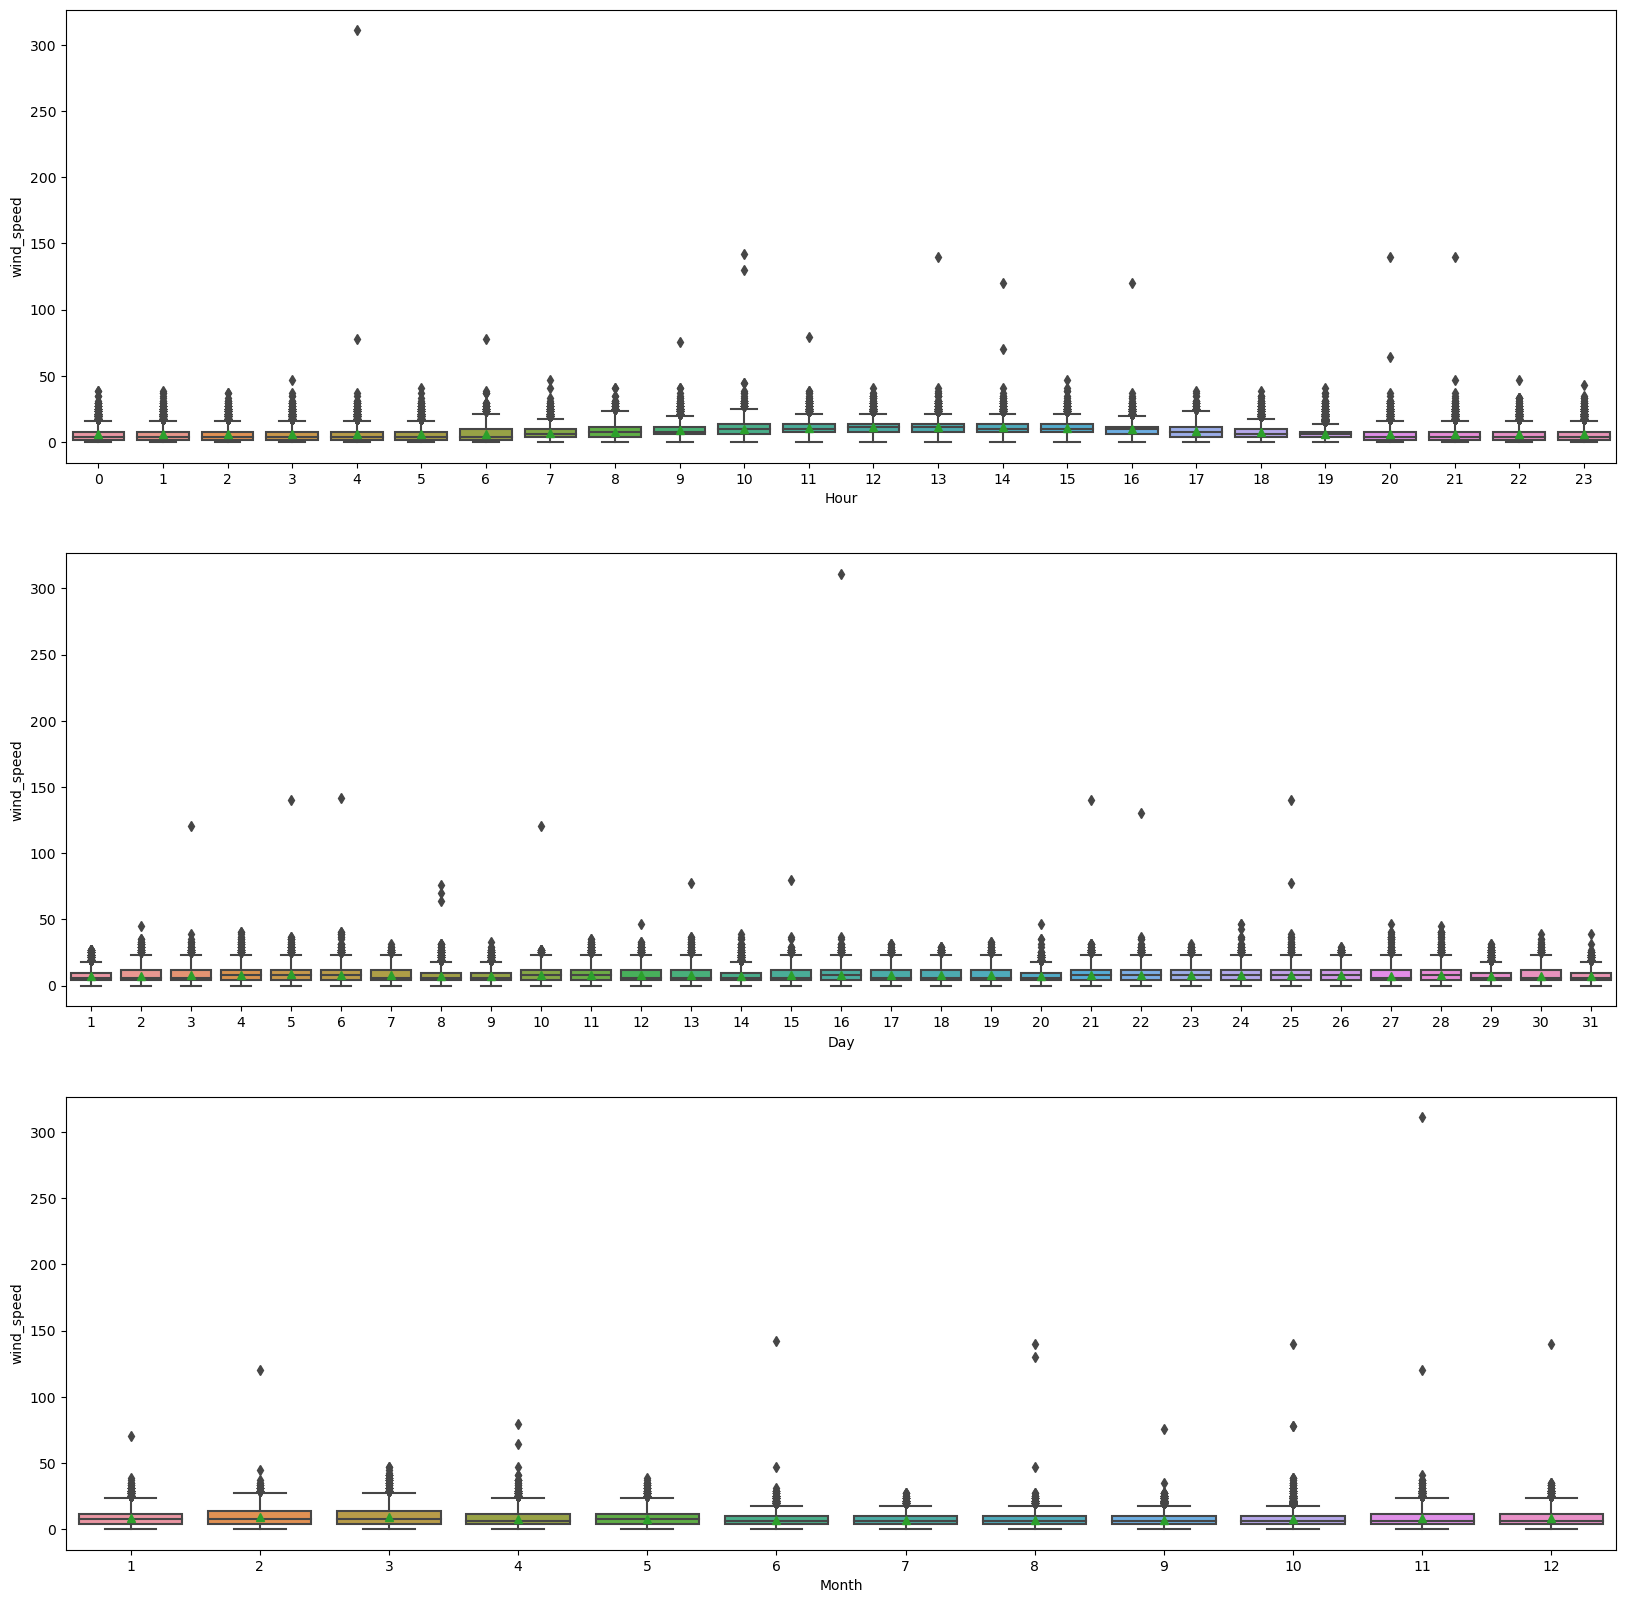

In [55]:
fig, ax = plt.subplots(3,1, figsize = (20,20))
sns.boxplot(data = df, x = 'Hour', y = var, ax = ax[0], showmeans=True)
sns.boxplot(data = df, x = 'Day', y = var, ax = ax[1], showmeans=True)
sns.boxplot(data = df, x = 'Month', y = var, ax = ax[2], showmeans=True)
plt.show()

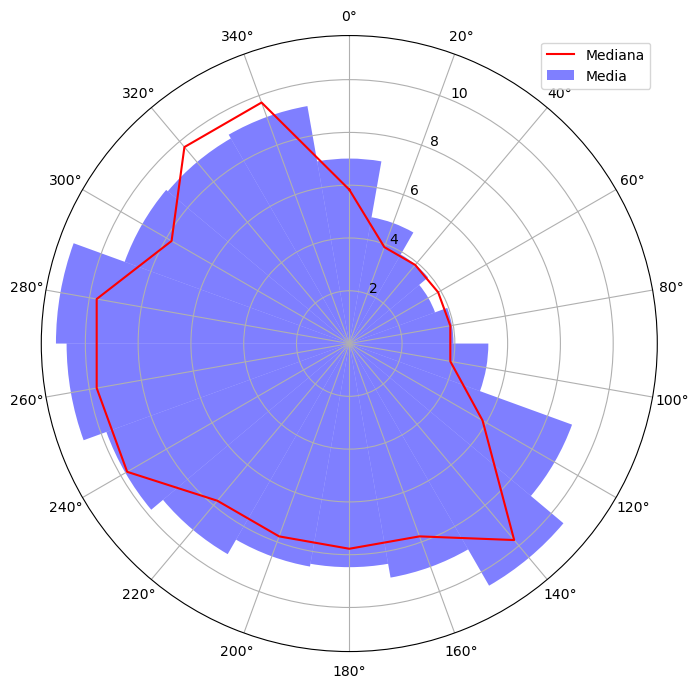

In [56]:
# Definisci i bin per le direzioni del vento
bin_size = 20  #dimensione del bin
bins = np.arange(0, 360 + bin_size, bin_size)

# Raggruppa i dati per direzione del vento
df['direction_bin'] = pd.cut(df['wind_direction'], bins=bins, labels=bins[:-1])

# Calcola la media e la mediana delle velocità del vento per ogni direzione
grouped = df.groupby('direction_bin')['wind_speed'].agg(['mean', 'median'])


# Crea un plot circolare
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='polar')

# Angoli per le direzioni
directions = np.deg2rad(grouped.index.astype(float))

# Barre per la media
ax.bar(directions, grouped['mean'], width=np.deg2rad(bin_size), bottom=0.0, color='b', alpha=0.5, label='Media')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(directions)
ax.set_xticklabels([str(int(deg)) + '°' for deg in grouped.index])

median = list(grouped['median'])
median.append(grouped['median'][0])

directions = list(directions)
directions.append(directions[0])


# Linee per la mediana
ax.plot(directions, median, color='r', label='Mediana')
ax.legend(loc='best')

plt.show()



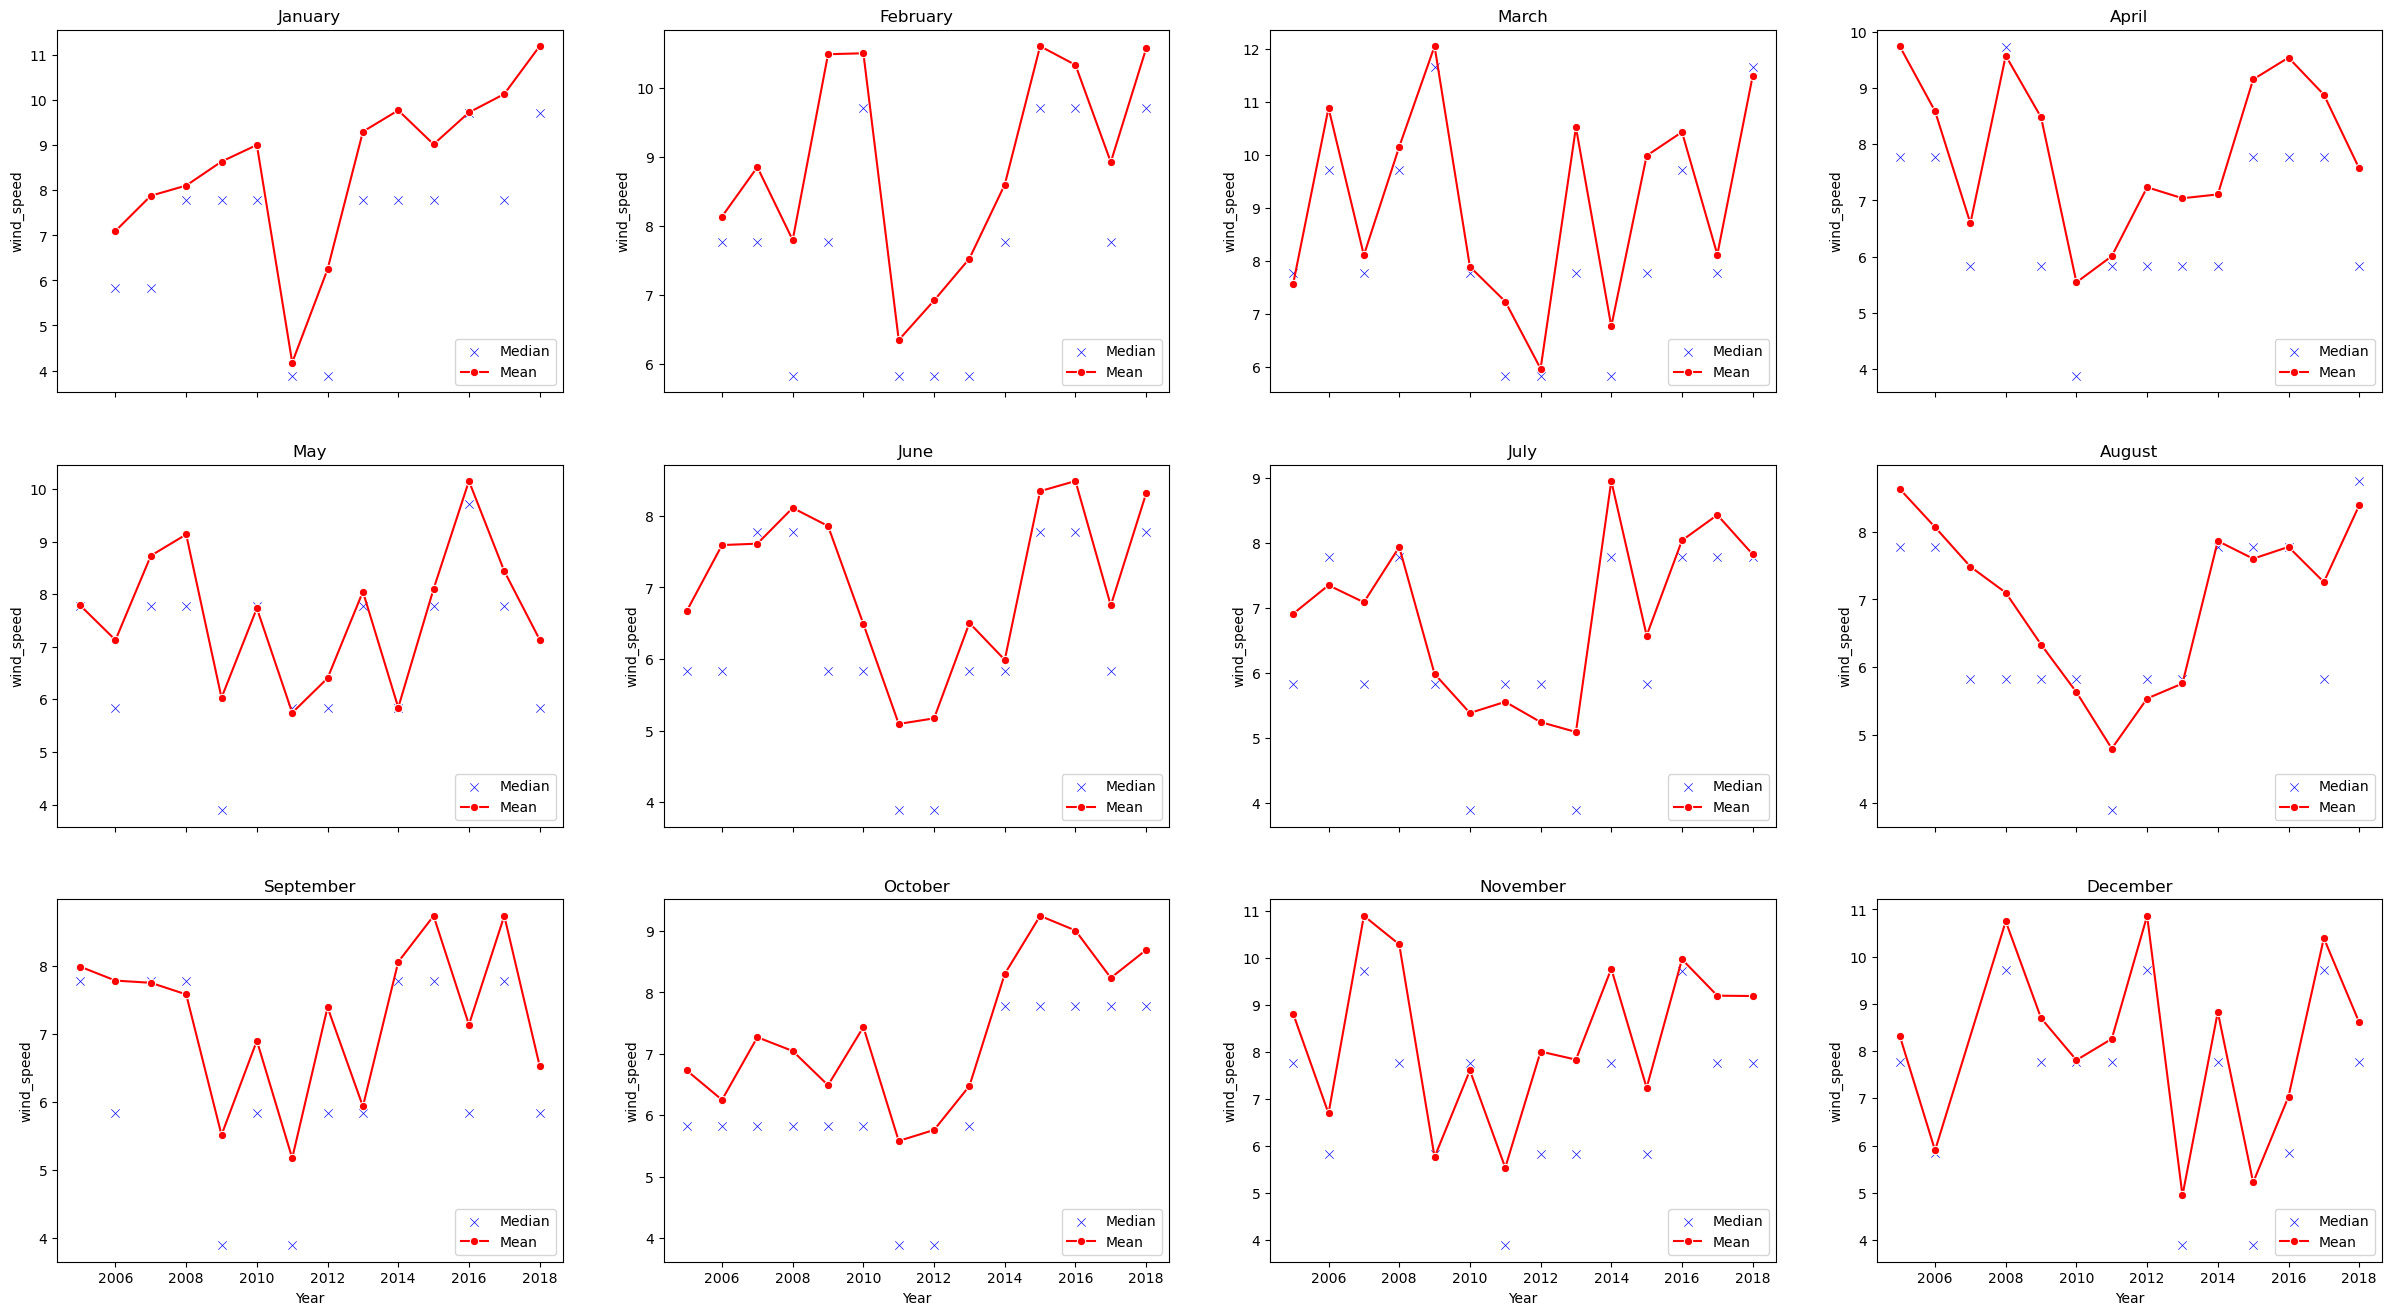

In [57]:
tst = df.groupby(['Year', 'Month'], as_index=False).agg(median=('wind_speed','median'), mean=('wind_speed','mean'))
fig,axes = plt.subplots(3, 4, figsize = (30,16), sharex=True)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.scatterplot(data = tst[tst['Month'] == i], x = 'Year', y = 'median', marker = 'x', color = 'blue', ax = ax, label = 'Median')
    sns.lineplot(data = tst[tst['Month'] == i], x = 'Year', y = 'mean', marker = 'o', color = 'red', ax = ax, label = 'Mean')

    ax.set_title(months[i-1])
    ax.set_ylabel('wind_speed')
    ax.legend(loc='lower right')

    col += 1
    if col % 4 == 0:
        col = 0
        row += 1

## Cloud Cover

In [58]:
var = 'cloud_cover'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

12 Nan out of 117114 data


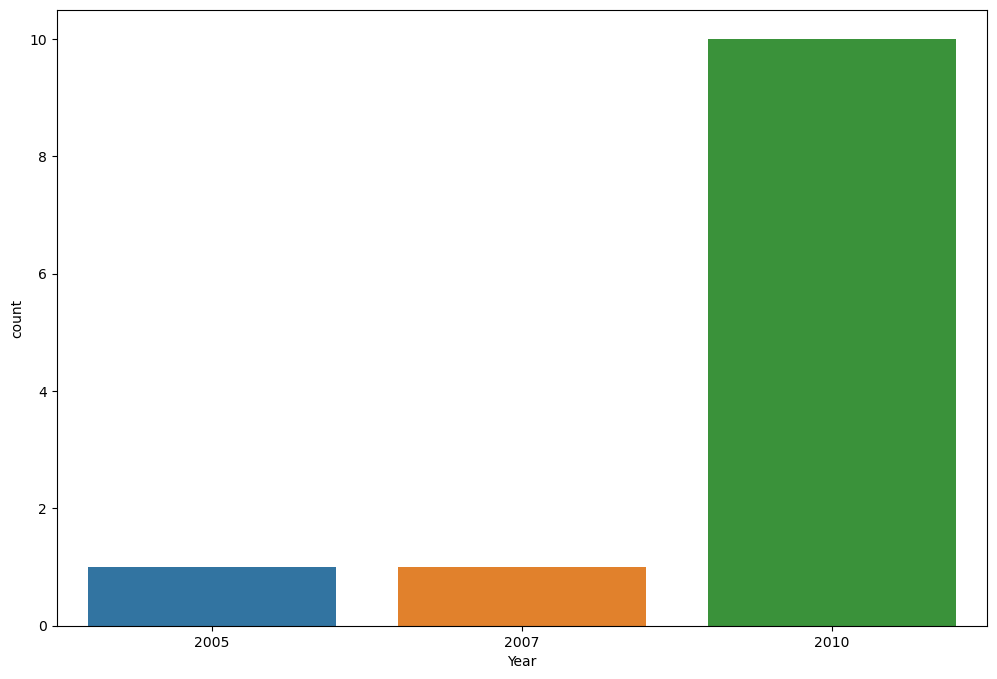

In [59]:
plt.figure(figsize = (12, 8))
sns.countplot(data = df[['Year']][df[var].isna()], x = 'Year')
plt.show()

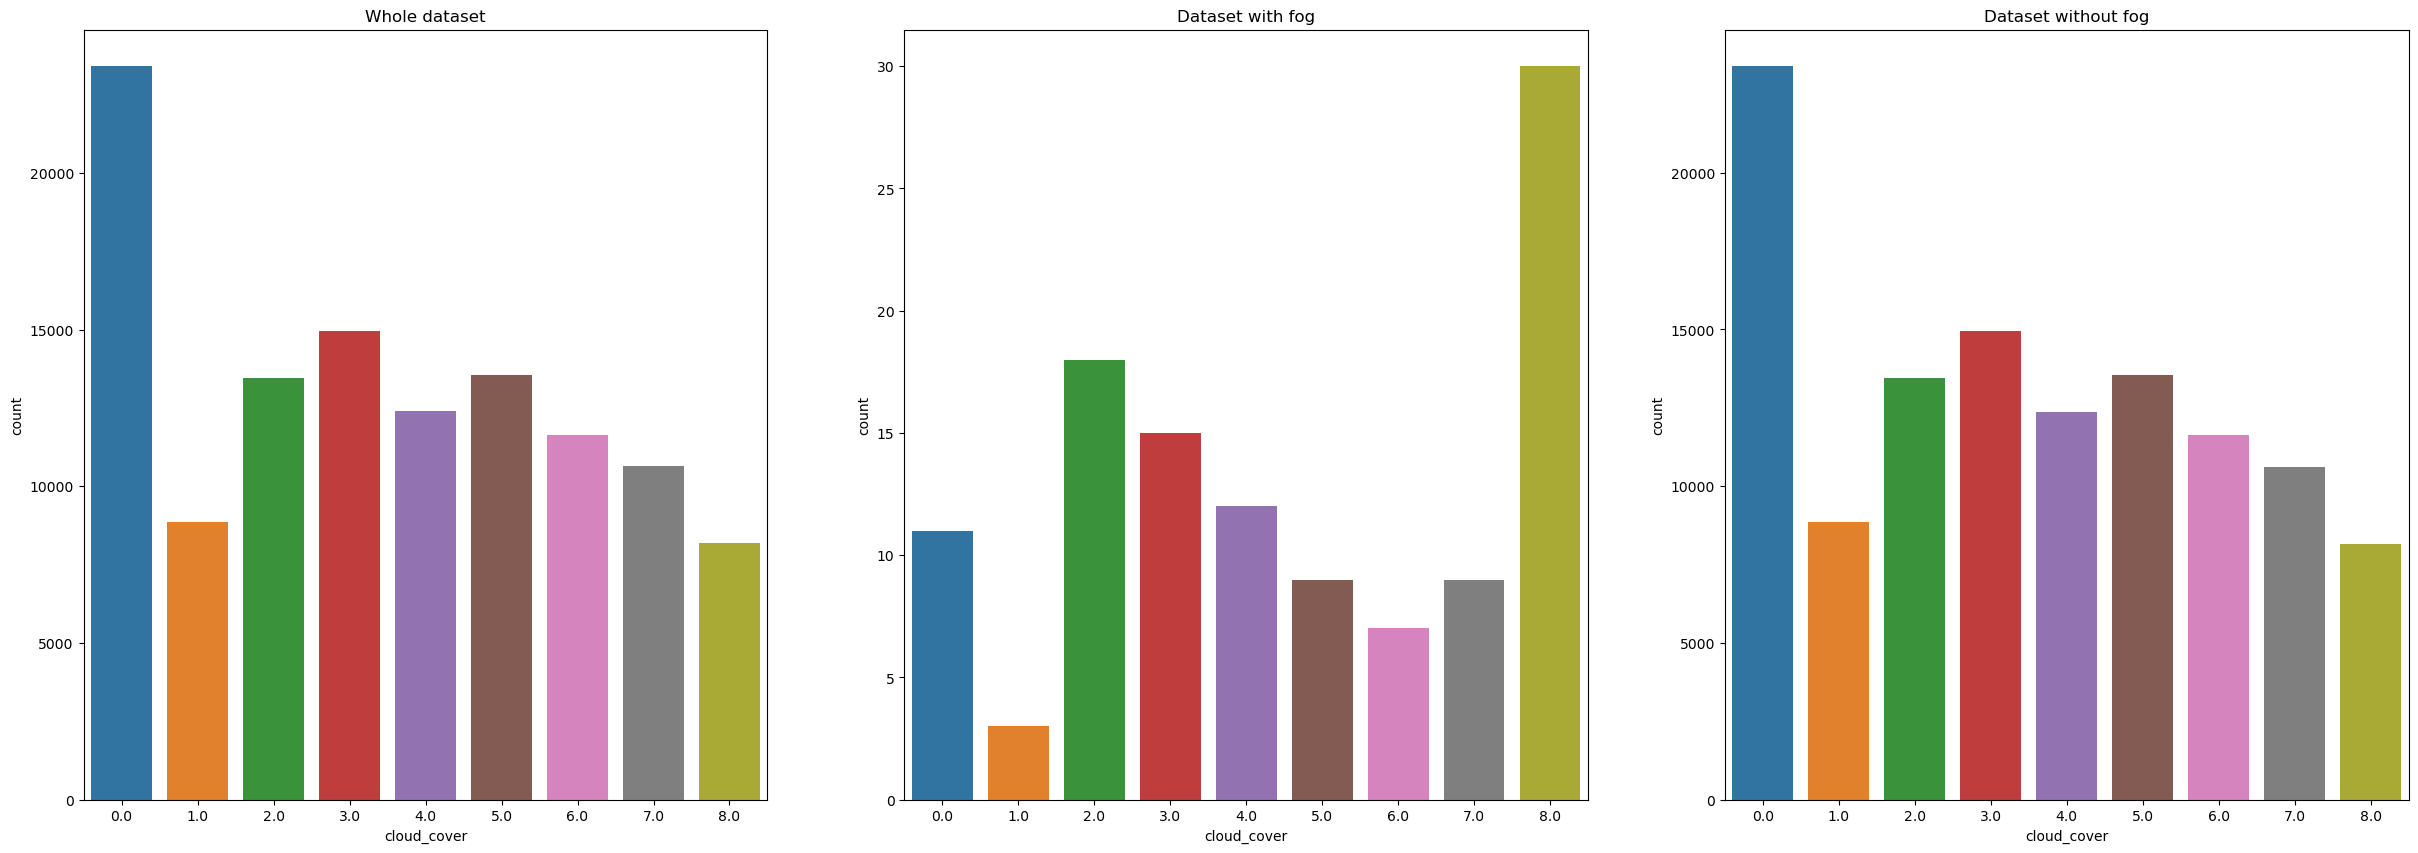

In [60]:
fig, axes = plt.subplots(1,3,figsize = (30,10))
sns.countplot(data = df, x = 'cloud_cover', ax = axes[0])
sns.countplot(data = df[df['fog'] == 1], x = 'cloud_cover', ax = axes[1])
sns.countplot(data = df[df['fog'] == 0], x = 'cloud_cover', ax = axes[2])

axes[0].set_title('Whole dataset')
axes[1].set_title('Dataset with fog')
axes[2].set_title('Dataset without fog')
plt.show()

## Cloud Type

In [61]:
var = 'cloud_type'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

0 Nan out of 117114 data


Text(0.5, 1.0, 'Dataset without fog')

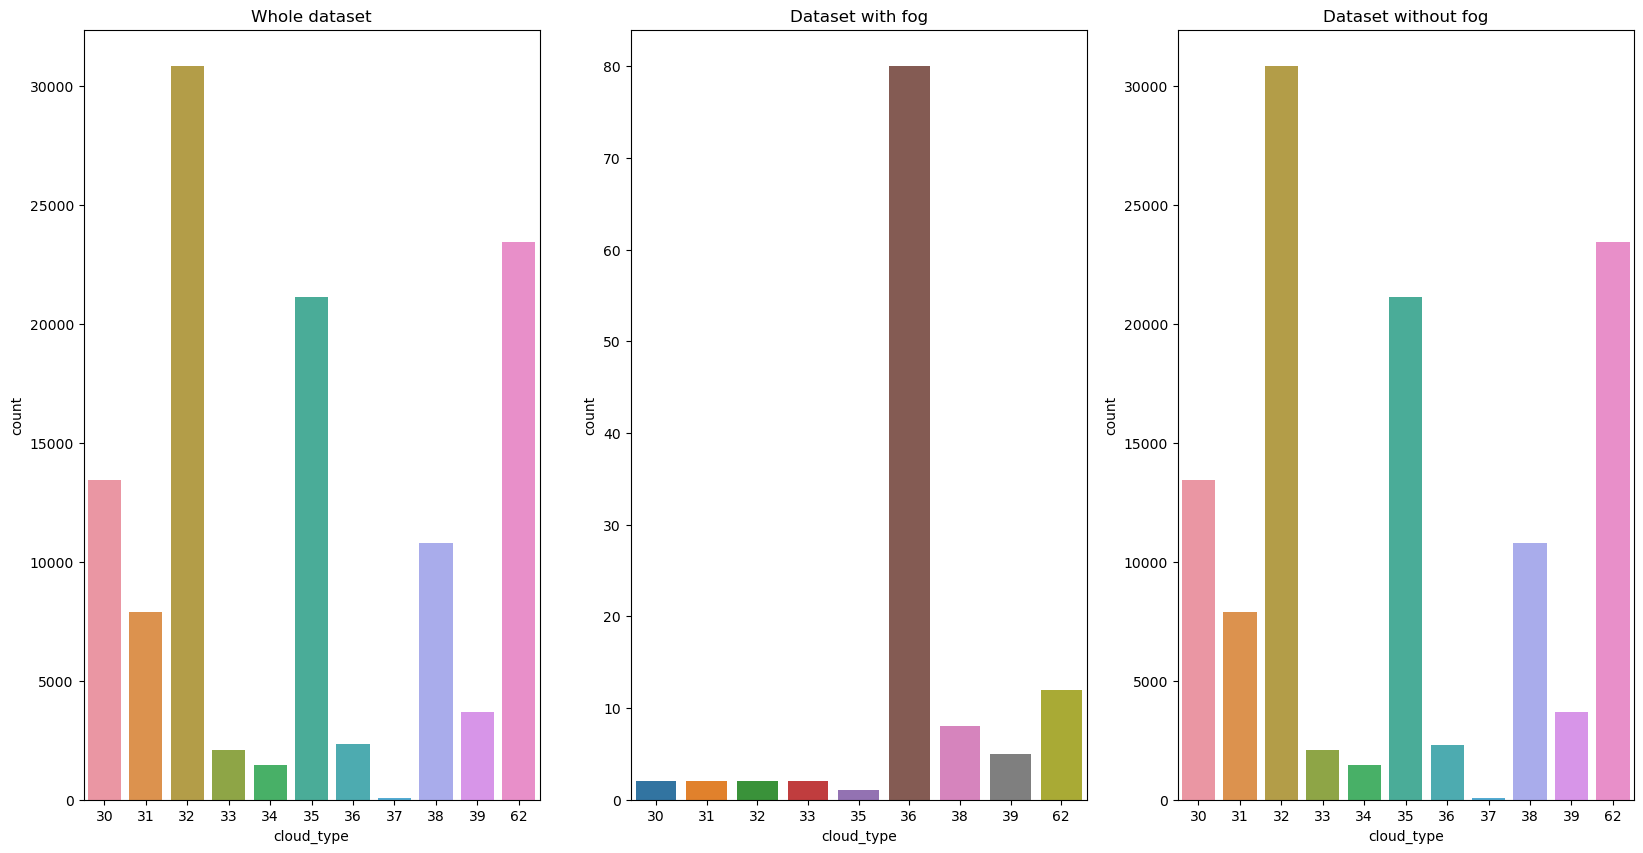

In [62]:
fig, axes = plt.subplots(1,3,figsize = (20,10))

sns.countplot(data = df, x = 'cloud_type', ax = axes[0])
sns.countplot(data = df[df['fog'] == 1], x = 'cloud_type', ax = axes[1])
sns.countplot(data = df[df['fog'] == 0], x = 'cloud_type', ax = axes[2])

axes[0].set_title('Whole dataset')
axes[1].set_title('Dataset with fog')
axes[2].set_title('Dataset without fog')

## Drybulb/Dewpoint

In [63]:
var = 'drybulb'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

72782 Nan out of 117114 data


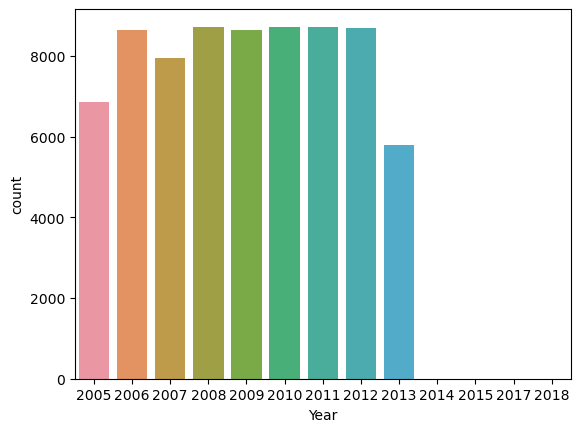

In [64]:
sns.countplot(data = df[['Year']][df[var].isna()], x = 'Year')
plt.show()

In [65]:
var = 'dewpoint'
print(f"{df[var].isna().sum()} Nan out of {df.shape[0]} data")

72783 Nan out of 117114 data


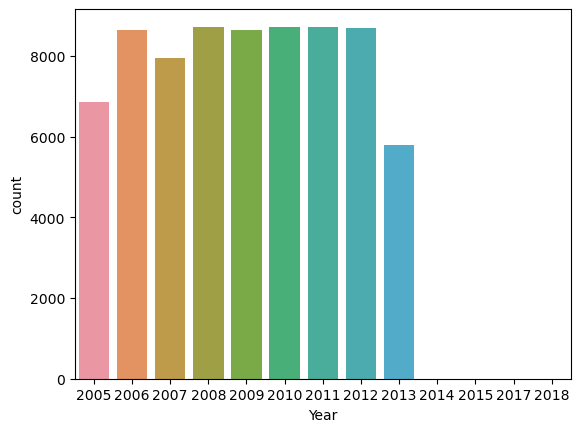

In [66]:
sns.countplot(data = df[['Year']][df[var].isna()], x = 'Year')
plt.show()

In [67]:
# when all two are NaN
df1 = df[(~df['drybulb'].isna()) & (~df['dewpoint'].isna())].copy()
df1 = df1.reset_index(drop = True)

<AxesSubplot:xlabel='fog', ylabel='value'>

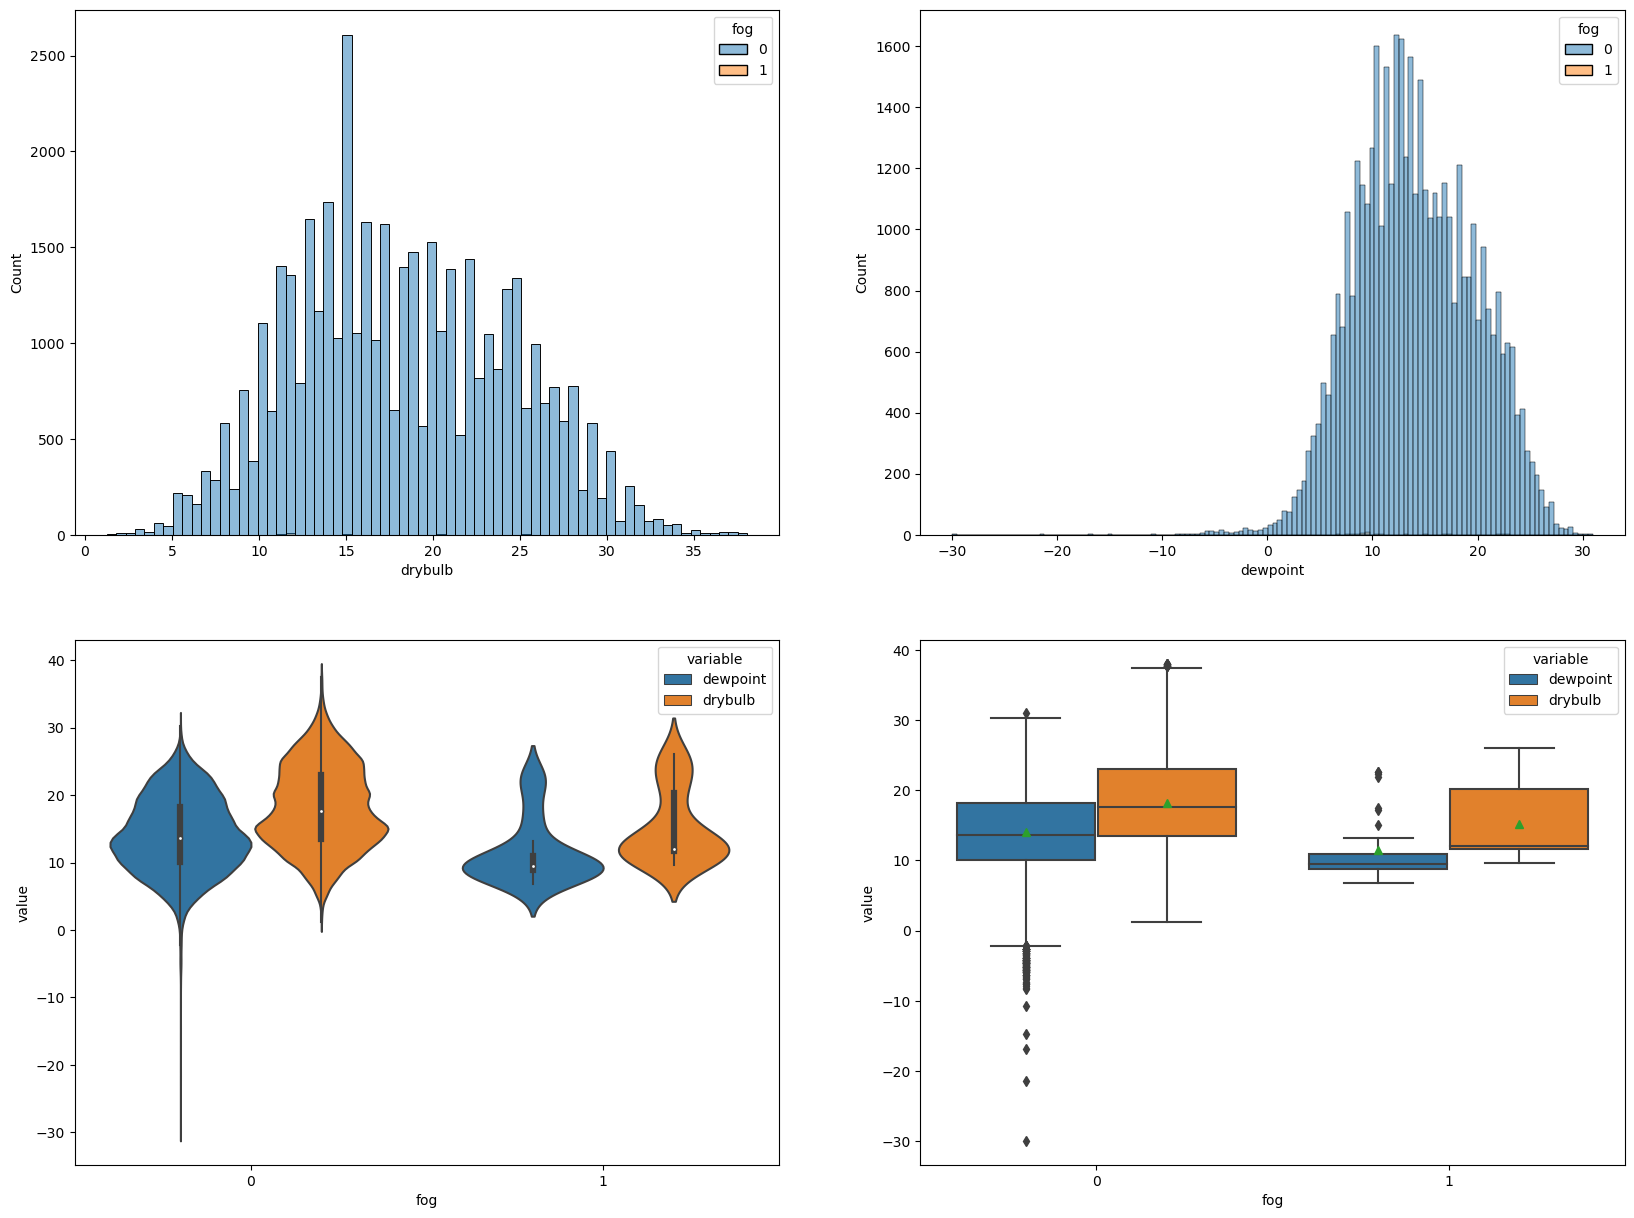

In [68]:
a = pd.melt(df1[['dewpoint', 'drybulb']])
b = list(df1['fog'])
b += b
a['fog'] = b

fig, axes = plt.subplots(2, 2, figsize = (20,15))
sns.histplot(data = df[~df['drybulb'].isna()], x = 'drybulb',hue = 'fog', ax = axes[0, 0])
sns.histplot(data = df[~df['dewpoint'].isna()], x = 'dewpoint', hue = 'fog', ax = axes[0, 1])
sns.violinplot(data = a, x = 'fog', y = 'value', hue = 'variable', showmeans = True, ax = axes[1,0])
sns.boxplot(data = a, x = 'fog', y = 'value', hue = 'variable', showmeans = True, ax = axes[1,1])

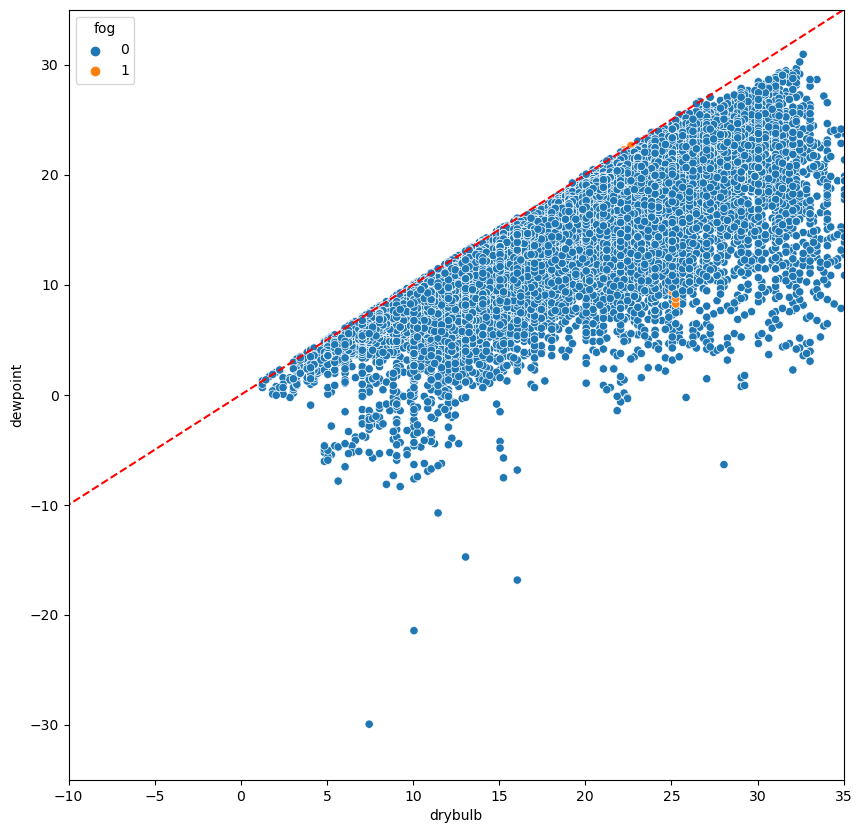

In [69]:
plt.figure(figsize = (10,10))
sns.scatterplot(data = df, x = 'drybulb', y = 'dewpoint', hue = 'fog')
plt.plot([-50,50], [-50,50], 'r', ls = '--')
plt.xlim((-10,35))
plt.ylim((-35,35))
plt.show()

In [70]:
# import plotly.express as px
# fig = px.scatter_3d(df, x='dewpoint', y='drybulb', z='Month',
#                     color='fog',size_max=18,
#                     opacity=0.7)
 
# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

In [71]:
# # event increasing during the years?
# import plotly.express as px
# fig = px.scatter_3d(df, x='dewpoint', y='drybulb', z='Year',
#                     color='fog',size_max=18,
#                     opacity=0.7)
 
# # tight layout
# fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# fig.show()

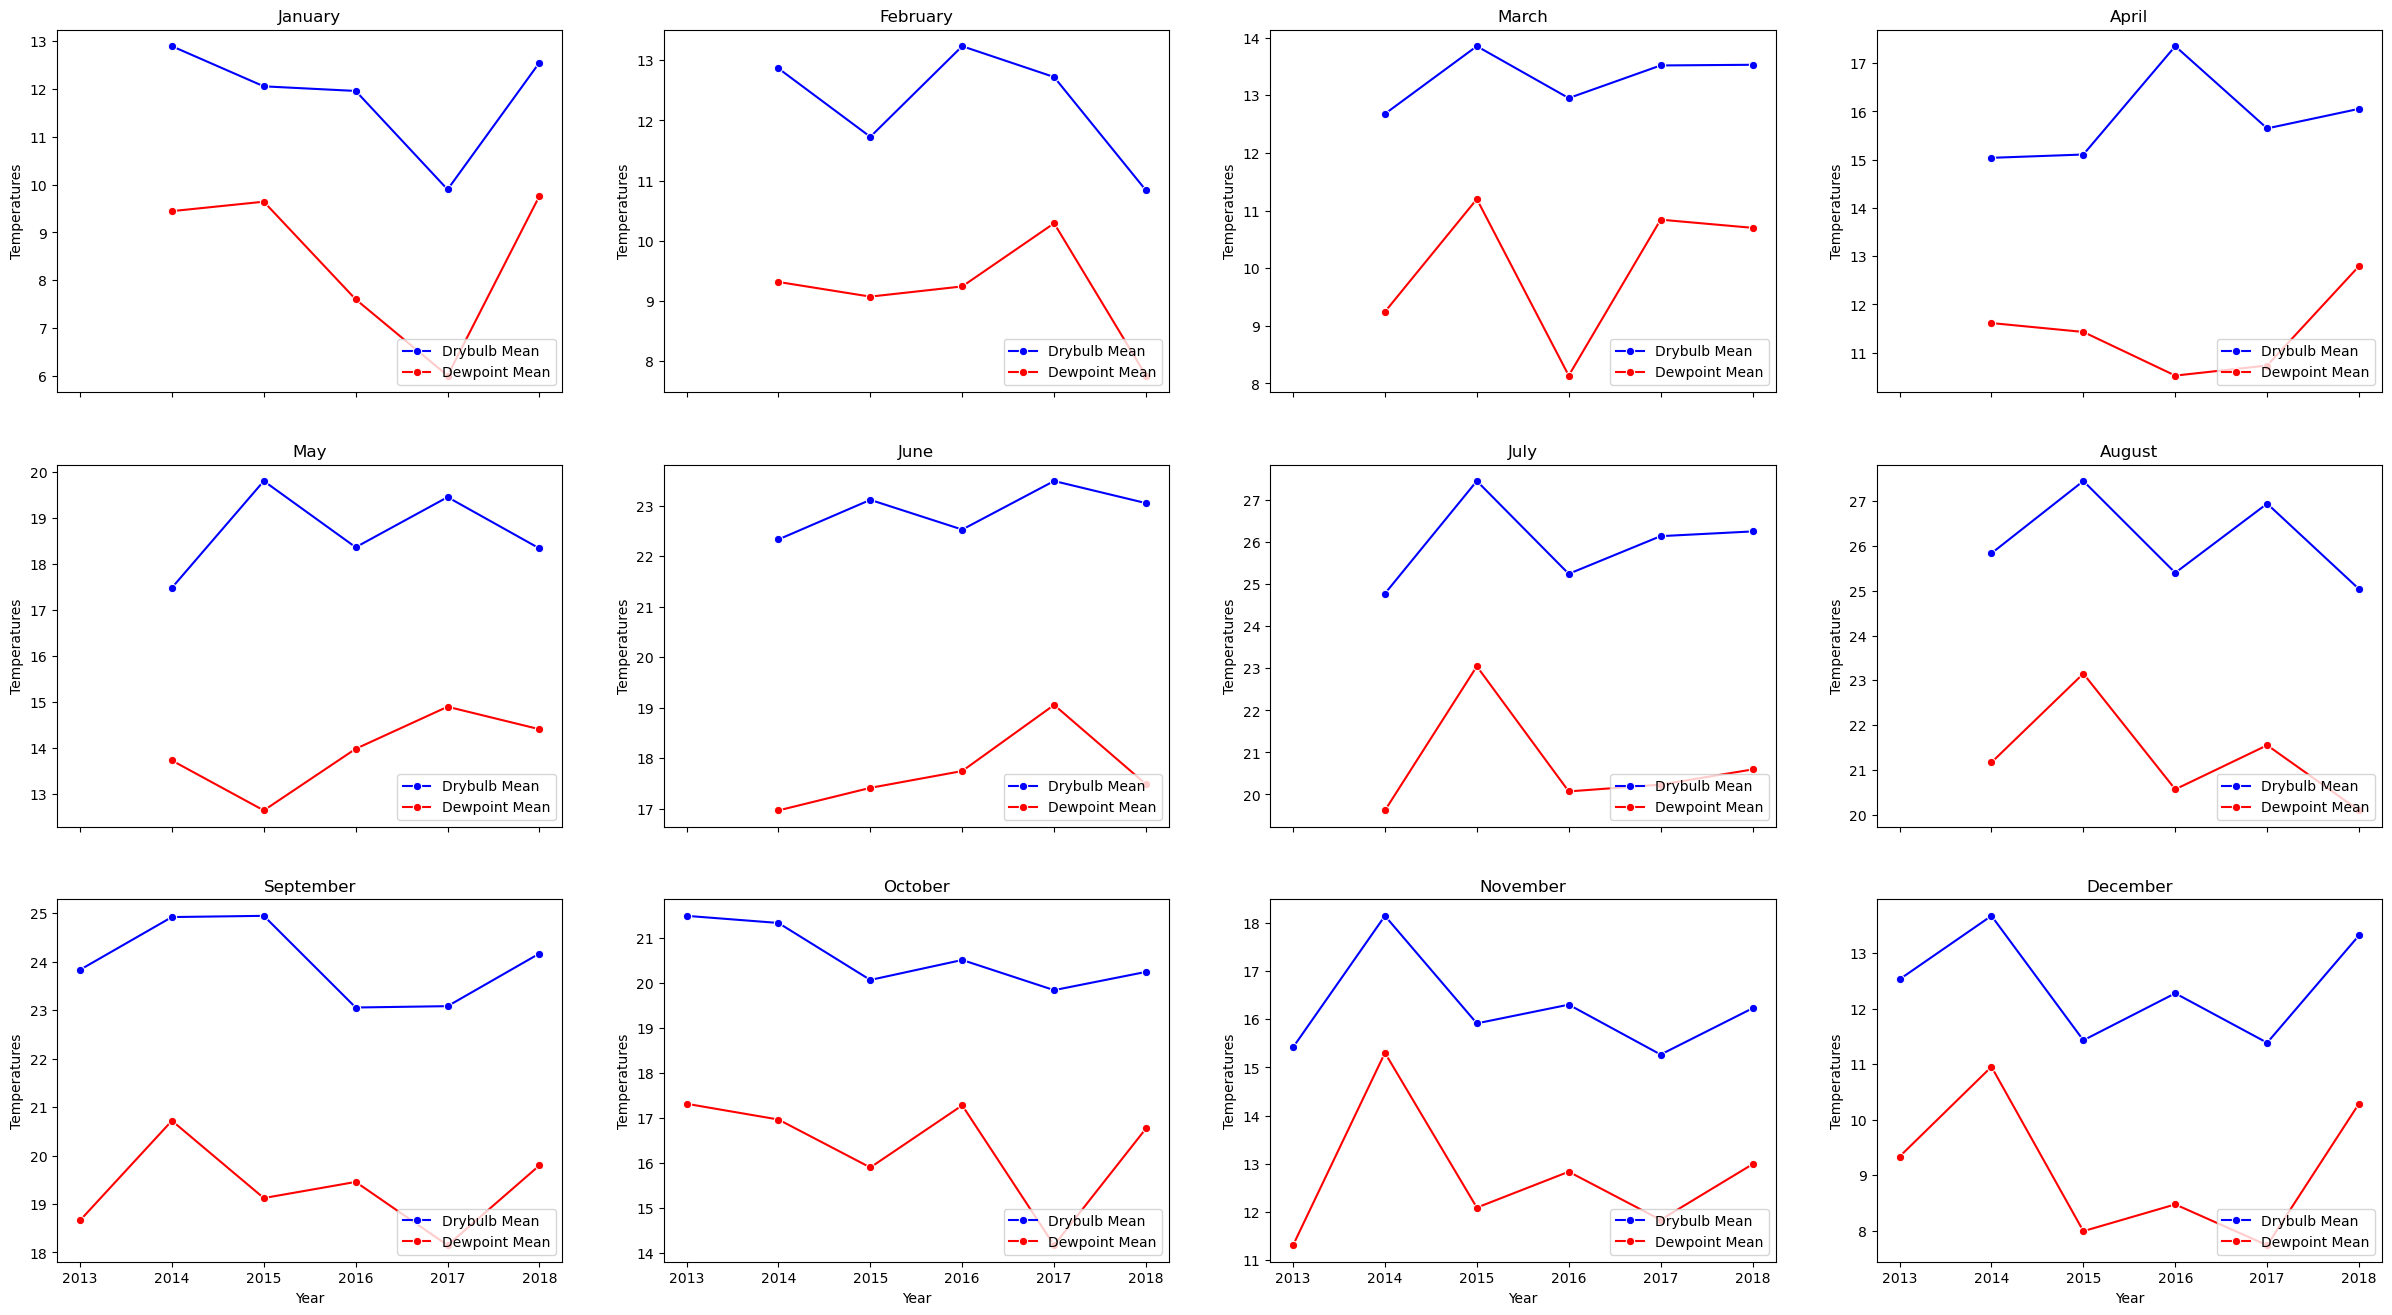

In [72]:
tst = df.groupby(['Year', 'Month'], as_index=False).agg(mean_drybulb=('drybulb','mean'), mean_dewpoint=('dewpoint','mean'))
fig,axes = plt.subplots(3, 4, figsize = (30,16), sharex=True)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.lineplot(data = tst[tst['Month'] == i], x = 'Year', y = 'mean_drybulb', marker = 'o', color = 'blue', ax = ax, label = 'Drybulb Mean')
    sns.lineplot(data = tst[tst['Month'] == i], x = 'Year', y = 'mean_dewpoint', marker = 'o', color = 'red', ax = ax, label = 'Dewpoint Mean')

    ax.set_title(months[i-1])
    ax.set_ylabel('Temperatures')
    ax.legend(loc='lower right')

    col += 1
    if col % 4 == 0:
        col = 0
        row += 1

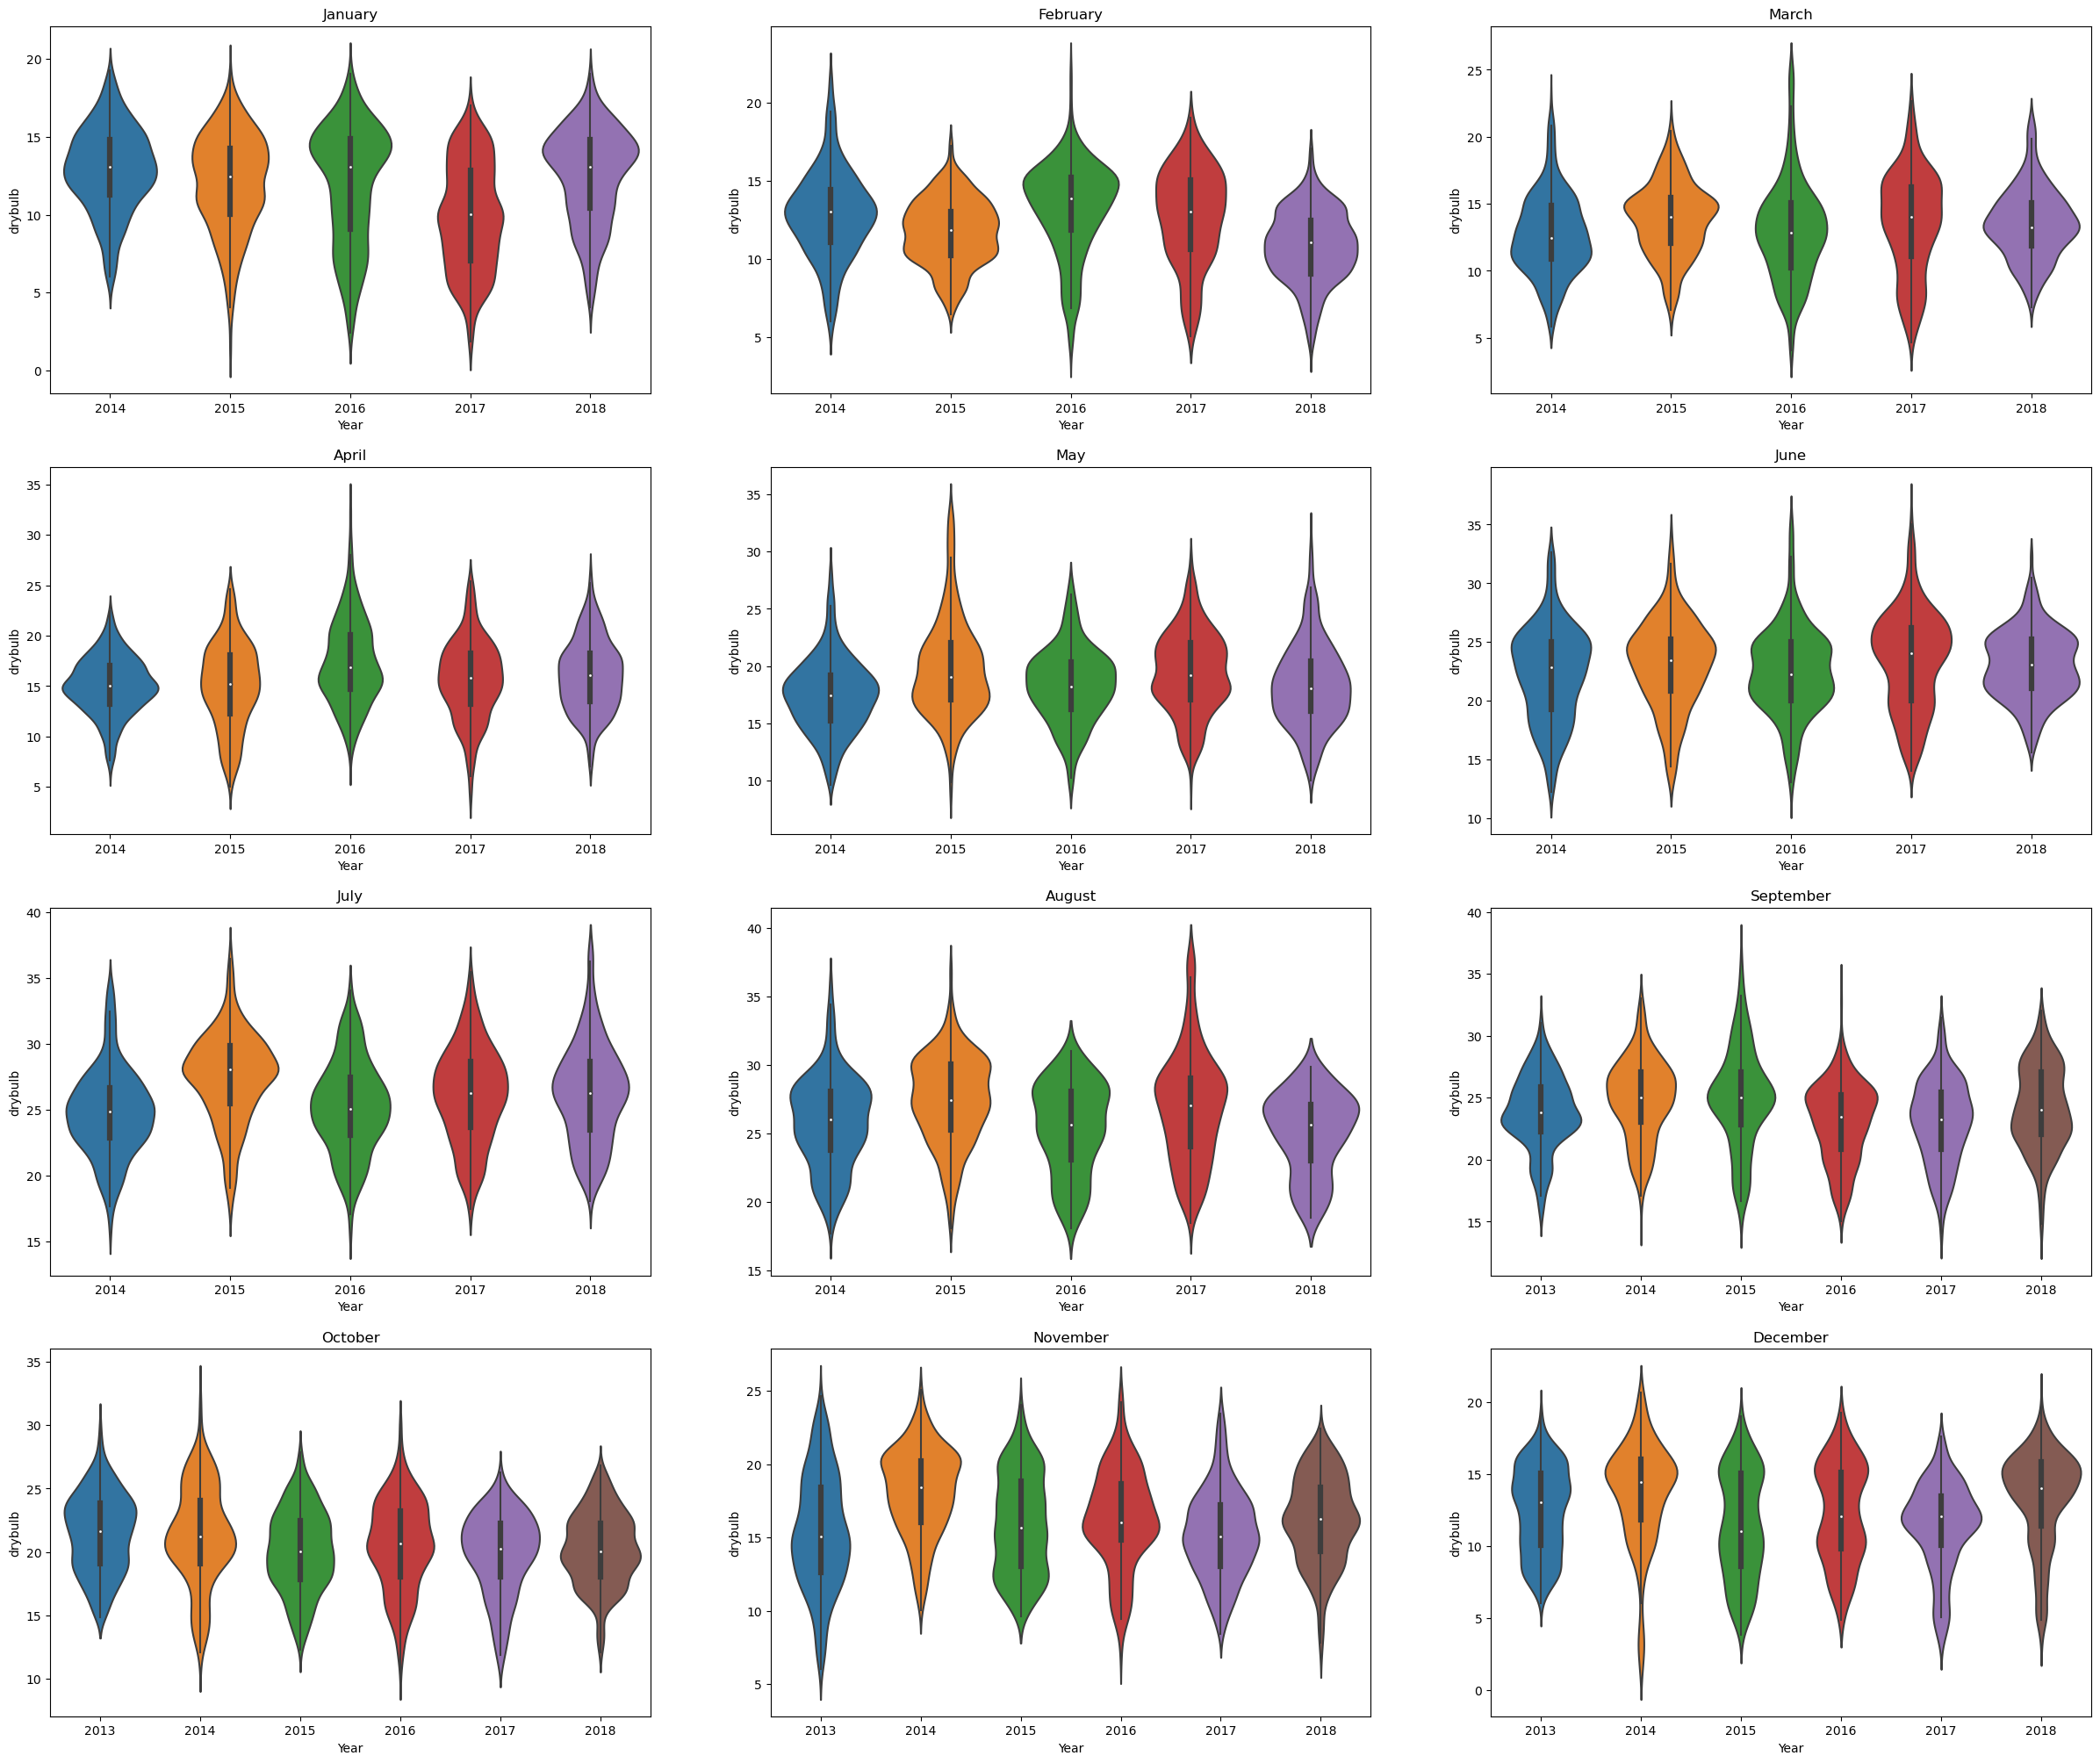

In [73]:
fig,axes = plt.subplots(4, 3, figsize = (30,25))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.violinplot(data = df[(df['Month'] == i) & (~df['drybulb'].isna())], x = 'Year', y = 'drybulb', marker = 'x', ax = ax)
    

    ax.set_title(months[i-1])
    ax.set_ylabel('drybulb')
    

    col += 1
    if col % 3 == 0:
        col = 0
        row += 1

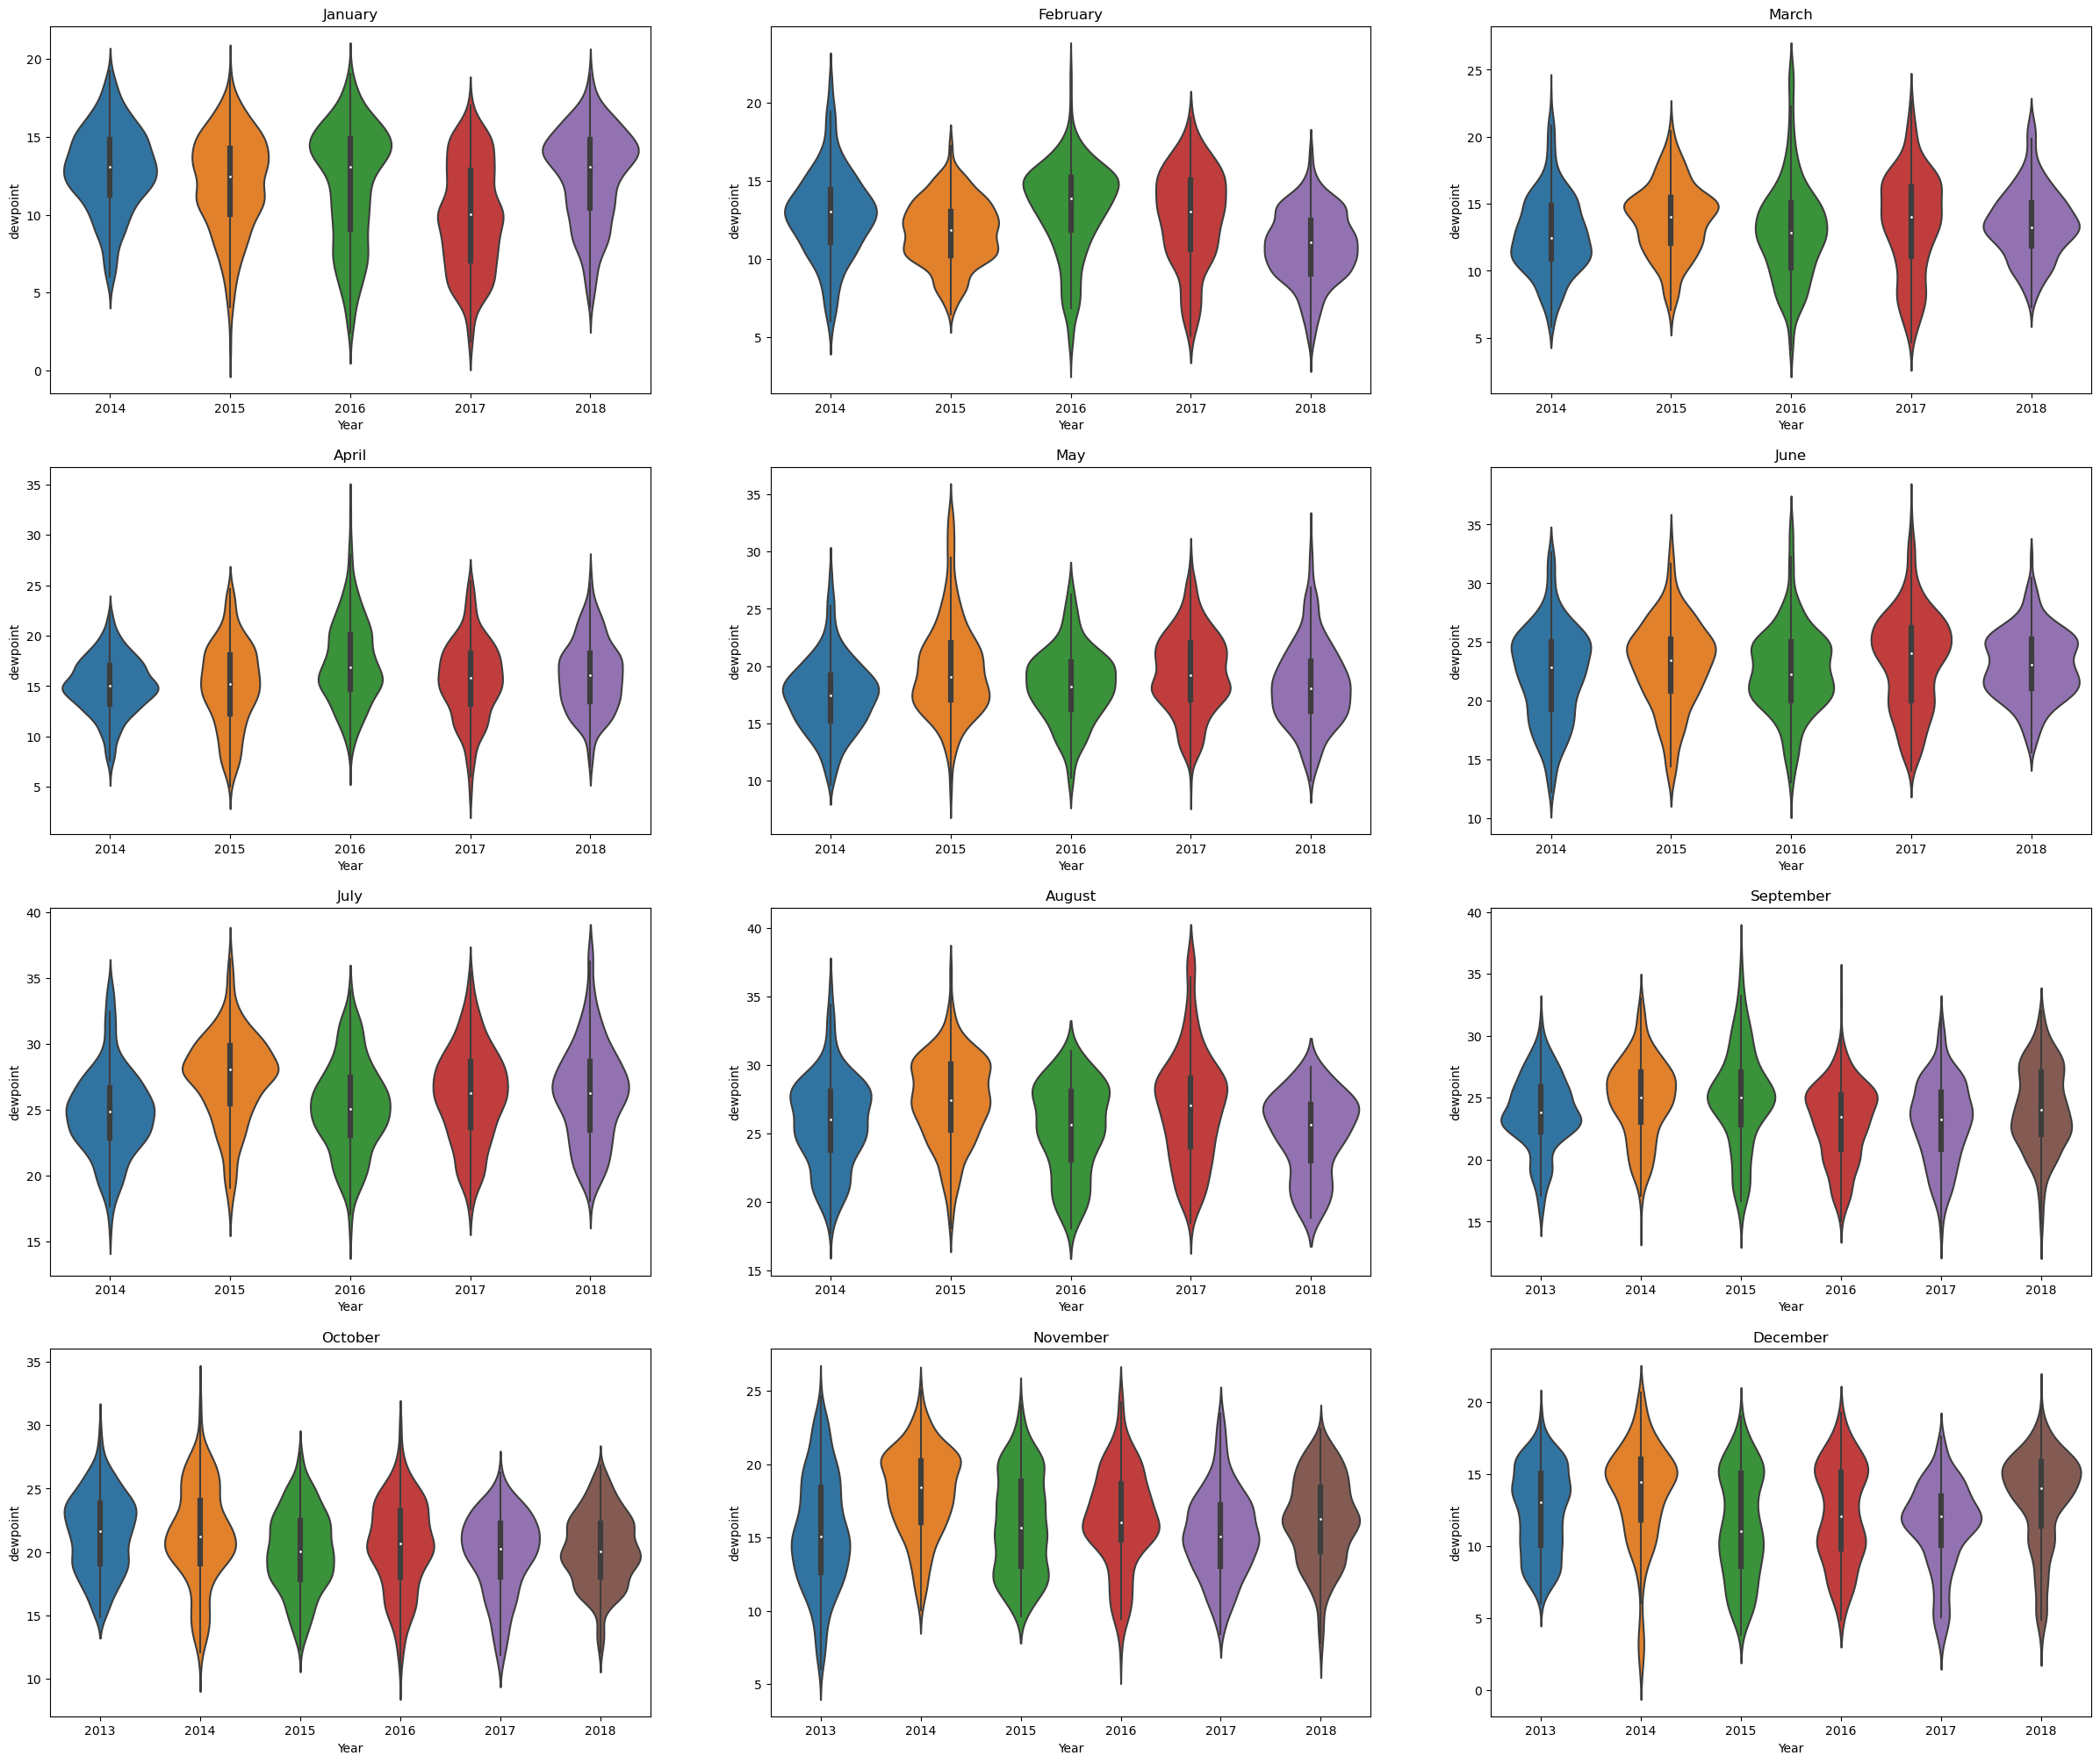

In [74]:
fig,axes = plt.subplots(4, 3, figsize = (30,25))
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
row, col = 0, 0

for i in range(1,13):
    
    ax = axes[row, col]
    sns.violinplot(data = df[(df['Month'] == i) & (~df['dewpoint'].isna())], x = 'Year', y = 'drybulb', marker = 'x', ax = ax)
    

    ax.set_title(months[i-1])
    ax.set_ylabel('dewpoint')
    

    col += 1
    if col % 3 == 0:
        col = 0
        row += 1

In [75]:
df.to_csv('trapani.csv')

# Neural Networks

## Without drybulb and dewpoint

In [114]:
df1 = df.copy()
df1 = df1.reset_index(drop = 1)

columns = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'past_weather1', 'past_weather2', 'fog']
categorical = ['past_weather1', 'past_weather2']
numerical = ['Julian', 'pressure', 'wind_direction', 'wind_speed']

df1 = df1[columns]
df1 = df1.reset_index(drop = 1)

df_cat = df1[categorical].copy()
df_num = df1[numerical].copy()

scaler = StandardScaler()  

df_num1 = scaler.fit_transform(df_num)
df_num1 = pd.DataFrame(df_num1, columns = df_num.columns.values)

df_cat = pd.get_dummies(df_cat, columns = df_cat.columns.values)


dfNN = pd.concat([df_cat, df_num1], axis = 1)
dfNN['fog'] = df1['fog']
print(dfNN.shape)
dfNN.isna().sum()

(117114, 25)


past_weather1_0    0
past_weather1_1    0
past_weather1_2    0
past_weather1_3    0
past_weather1_4    0
past_weather1_5    0
past_weather1_6    0
past_weather1_7    0
past_weather1_8    0
past_weather1_9    0
past_weather2_0    0
past_weather2_1    0
past_weather2_2    0
past_weather2_3    0
past_weather2_4    0
past_weather2_5    0
past_weather2_6    0
past_weather2_7    0
past_weather2_8    0
past_weather2_9    0
Julian             0
pressure           0
wind_direction     0
wind_speed         0
fog                0
dtype: int64

In [116]:
pct = dfNN[dfNN['fog'] == 1].shape[0]*100/dfNN.shape[0]

print(f'The {round(pct, 3)}% of the dataset has fog cases')

The 0.097% of the dataset has fog cases


In [117]:
X = dfNN.drop('fog', axis=1)  
y = dfNN['fog']

In [118]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# build a model
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                800       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [119]:
np.random.seed(10)
model.compile(optimizer= optimizers.Adam(learning_rate =  10 ** (-3)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=30,
                                   restore_best_weights=True)

es1= tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="max",
    min_lr=10**(-10)
)


history =  model.fit(X_train, y_train, epochs=500, batch_size=64, shuffle=True, validation_data = (X_test, y_test), verbose=1, callbacks = [es, es1])

Epoch 1/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0442 - accuracy: 0.9943 - val_loss: 0.0051 - val_accuracy: 0.9990 - lr: 0.0010
Epoch 2/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0043 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 3/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0037 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 4/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0045 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 5/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0045 - val_accuracy: 0.9991 - lr: 0.0010
Epoch 6/500
1464/1464 [==============================] - 2s 1ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0044 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 7/500
1464/1464 [=============================

In [1]:
history_dict = history.history

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss_values) + 1) 

print(round(np.max(val_acc) * 100, 2)) 

fig, axes = plt.subplots(1, 2, figsize = (20, 10))



axes[0].plot(epochs, loss_values, 'b', label='Training loss')
axes[0].plot(epochs, val_loss_values, 'orange', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, acc, 'b', label='Training accuracy')
axes[1].plot(epochs, val_acc, 'orange', label='Validation accuracy')
axes[1].set_title('Training and validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

NameError: name 'history' is not defined

732/732 [==============================] - 1s 752us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23400
           1       0.86      0.26      0.40        23

    accuracy                           1.00     23423
   macro avg       0.93      0.63      0.70     23423
weighted avg       1.00      1.00      1.00     23423



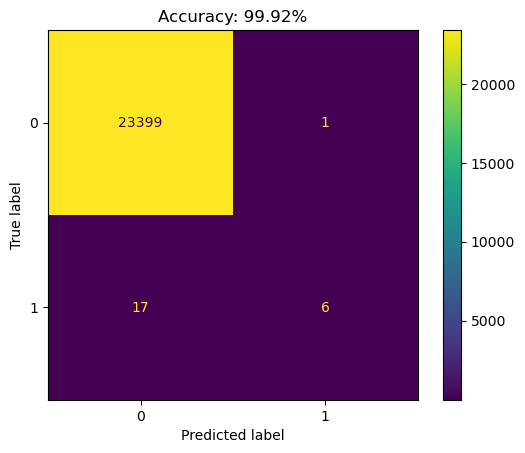

In [120]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = np.round(model.predict(X_test),0)
# confusion matrix

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
print(classification_report(y_test, preds))
disp.plot()

plt.title(f'Accuracy: {round(accuracy_score(y_test, preds) * 100, 2)}%')
plt.show()

## With drybulb and dewpoint

In [121]:
df2 = df.copy()
df2 = df2.reset_index(drop = 1)

columns = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'past_weather1', 'past_weather2', 'drybulb', 'dewpoint', 'fog']
categorical = ['past_weather1', 'past_weather2']
numerical = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'drybulb', 'dewpoint']



df2 = df2[columns]
df2 = df2.dropna()
df2 = df2.reset_index(drop = 1)



df_cat = df2[categorical].copy()
df_num = df2[numerical].copy()

scaler = StandardScaler()  

df_num1 = scaler.fit_transform(df_num)
df_num1 = pd.DataFrame(df_num1, columns = df_num.columns.values)

df_cat = pd.get_dummies(df_cat, columns = df_cat.columns.values)
df_cat = df_cat.reset_index(drop = 1)


dfNN = pd.concat([df_cat, df_num1], axis = 1)
dfNN['fog'] = df2['fog']
print(dfNN.shape)
dfNN.isna().sum()

(44330, 27)


past_weather1_0    0
past_weather1_1    0
past_weather1_2    0
past_weather1_3    0
past_weather1_4    0
past_weather1_5    0
past_weather1_6    0
past_weather1_7    0
past_weather1_8    0
past_weather1_9    0
past_weather2_0    0
past_weather2_1    0
past_weather2_2    0
past_weather2_3    0
past_weather2_4    0
past_weather2_5    0
past_weather2_6    0
past_weather2_7    0
past_weather2_8    0
past_weather2_9    0
Julian             0
pressure           0
wind_direction     0
wind_speed         0
drybulb            0
dewpoint           0
fog                0
dtype: int64

In [122]:
X = dfNN.drop('fog', axis=1)  
y = dfNN['fog']

pct = dfNN[dfNN['fog'] == 1].shape[0]*100/dfNN.shape[0]
print(f'The {round(pct, 2)}% of the dataset has fog cases')

The 0.07% of the dataset has fog cases


In [123]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# build a model
model = Sequential()
model.add(Dense(32, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                864       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [124]:
np.random.seed(10)
model.compile(optimizer= optimizers.Adam(learning_rate =  10 ** (-3)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=30,
                                   restore_best_weights=True)

es1= tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="max",
    min_lr=10**(-10)
)


history =  model.fit(X_train, y_train, epochs=500, batch_size=32, shuffle=True, validation_data = (X_test, y_test), verbose=1, callbacks = [es, es1])

Epoch 1/500
1109/1109 [==============================] - 2s 2ms/step - loss: 0.0561 - accuracy: 0.9888 - val_loss: 0.0043 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 2/500
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 3/500
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 4/500
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 5/500
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 6/500
1109/1109 [==============================] - 1s 1ms/step - loss: 0.0022 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9994 - lr: 0.0010
Epoch 7/500
1109/1109 [=============================

99.97


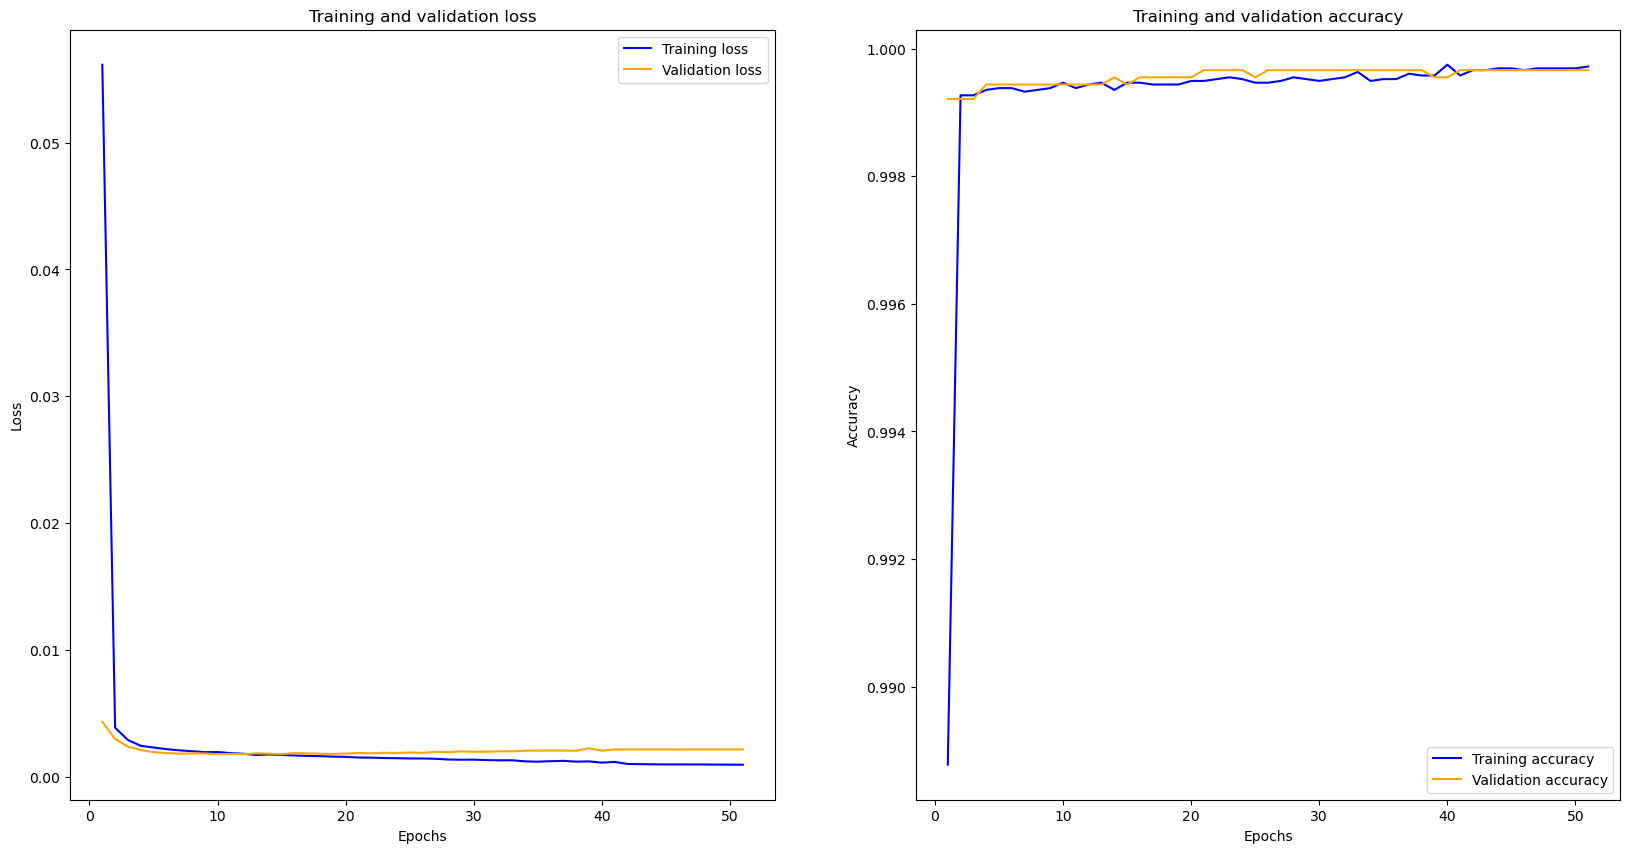

In [125]:
history_dict = history.history

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss_values) + 1) 

print(round(np.max(val_acc) * 100, 2)) 

fig, axes = plt.subplots(1, 2, figsize = (20, 10))

axes[0].plot(epochs, loss_values, 'b', label='Training loss')
axes[0].plot(epochs, val_loss_values, 'orange', label='Validation loss')
axes[0].set_title('Training and validation loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(epochs, acc, 'b', label='Training accuracy')
axes[1].plot(epochs, val_acc, 'orange', label='Validation accuracy')
axes[1].set_title('Training and validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

278/278 [==============================] - 0s 711us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8859
           1       0.83      0.71      0.77         7

    accuracy                           1.00      8866
   macro avg       0.92      0.86      0.88      8866
weighted avg       1.00      1.00      1.00      8866



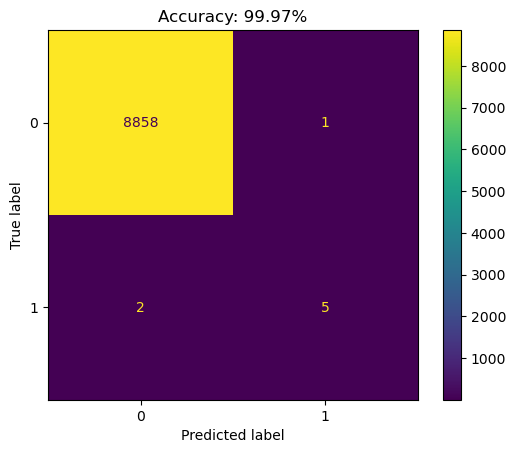

In [126]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = np.round(model.predict(X_test),0)
# confusion matrix

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(cm)
print(classification_report(y_test, preds))
disp.plot()

plt.title(f'Accuracy: {round(accuracy_score(y_test, preds) * 100, 2)}%')
plt.show()

# Tuning

In [75]:
df2 = df.copy()
df2 = df2.reset_index(drop = 1)

columns = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'past_weather1', 'past_weather2', 'drybulb', 'dewpoint', 'fog']
categorical = ['past_weather1', 'past_weather2']
numerical = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'drybulb', 'dewpoint']



df2 = df2[columns]
df2 = df2.dropna()
df2 = df2.reset_index(drop = 1)



df_cat = df2[categorical].copy()
df_num = df2[numerical].copy()

scaler = StandardScaler()  

df_num1 = scaler.fit_transform(df_num)
df_num1 = pd.DataFrame(df_num1, columns = df_num.columns.values)

df_cat = pd.get_dummies(df_cat, columns = df_cat.columns.values)
df_cat = df_cat.reset_index(drop = 1)


dfNN = pd.concat([df_cat, df_num1], axis = 1)
dfNN['fog'] = df2['fog']
print(dfNN.shape)
dfNN.isna().sum()

(44330, 27)


past_weather1_0    0
past_weather1_1    0
past_weather1_2    0
past_weather1_3    0
past_weather1_4    0
past_weather1_5    0
past_weather1_6    0
past_weather1_7    0
past_weather1_8    0
past_weather1_9    0
past_weather2_0    0
past_weather2_1    0
past_weather2_2    0
past_weather2_3    0
past_weather2_4    0
past_weather2_5    0
past_weather2_6    0
past_weather2_7    0
past_weather2_8    0
past_weather2_9    0
Julian             0
pressure           0
wind_direction     0
wind_speed         0
drybulb            0
dewpoint           0
fog                0
dtype: int64

In [76]:
from keras.metrics import Recall  # Import Recall metric
from sklearn.metrics import recall_score
import keras.backend as K  # Import K from Keras backend


In [77]:
X = dfNN.drop('fog', axis=1)  
y = dfNN['fog']
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values

activationL = ['relu', 'sigmoid', 'tanh', 'exponential']

results = []

for neurons in [8, 16, 32, 64]:
    for activation in activationL:
        for opt in ['SGD', 'Adam', 'RMSprop', 'Adadelta']:
            for batch_size in [8, 16, 32]:
                from keras.metrics import Recall  # Import Recall metric
                print('*' * 50)
                print('Parameters:')
                print(f'No. neurons: {neurons}')
                print(f'Activation: {activation}')
                print(f'Optimizer: {opt}')
                print(f'Batch size: {batch_size}')

                
                model = Sequential()
                model.add(Dense(neurons, input_dim = X_train.shape[1], activation = activation))
                model.add(Dense(1, activation = 'sigmoid'))



                # Compile the model with custom recall metric
                model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Recall(name = None)])
                    
                es = EarlyStopping(monitor='val_accuracy', 
                                mode='max',
                                patience=10,
                                restore_best_weights=True)

                model.fit(X_train, y_train, validation_data=(X_test, y_test), verbose = 1, epochs = 100, batch_size = batch_size, callbacks=[es])


                preds = np.round(model.predict(X_test),0)
                

                score1 = recall_score(y_test, preds, pos_label=1)
                score2 = accuracy_score(y_test, preds)
                params = [neurons, activation, batch_size, opt, (score1, score2)]
                results.append(params)



**************************************************
Parameters:
No. neurons: 8
Activation: relu
Optimizer: SGD
Batch size: 8
Epoch 1/100
4433/4433 [==============================] - 7s 1ms/step - loss: 0.0315 - accuracy: 0.9990 - recall: 0.0000e+00 - val_loss: 0.0060 - val_accuracy: 0.9992 - val_recall: 0.0000e+00
Epoch 2/100
4433/4433 [==============================] - 6s 1ms/step - loss: 0.0052 - accuracy: 0.9993 - recall: 0.0000e+00 - val_loss: 0.0044 - val_accuracy: 0.9992 - val_recall: 0.0000e+00
Epoch 3/100
4433/4433 [==============================] - 6s 1ms/step - loss: 0.0044 - accuracy: 0.9993 - recall: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.9992 - val_recall: 0.0000e+00
Epoch 4/100
4433/4433 [==============================] - 6s 1ms/step - loss: 0.0040 - accuracy: 0.9993 - recall: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.9992 - val_recall: 0.0000e+00
Epoch 5/100
4433/4433 [==============================] - 6s 1ms/step - loss: 0.0038 - accuracy: 0.9993 - recall:

In [79]:
import numpy as np

recalls = [x[4][0] for x in results]
accuracies = [x[4][1] for x in results]

rec_max = np.max(recalls)
ind_rec = recalls.index(rec_max)
print(results[ind_rec])
acc_max = np.max(accuracies)
ind_acc = accuracies.index(acc_max)
print(results[ind_acc])

best_model = results[ind_rec]
best_model

[8, 'exponential', 32, 'Adam', (0.7142857142857143, 0.9996616286938868)]
[8, 'exponential', 32, 'Adam', (0.7142857142857143, 0.9996616286938868)]


[8, 'exponential', 32, 'Adam', (0.7142857142857143, 0.9996616286938868)]